
# Optimal Hedging with Advanced Delta Modelling

I would like to show you an essential excerpt from my final CQF (Certificate of Quantitative Finance) project which focused on Optimal Delta Hedging in a Dynamic context. 



# Sections

## Part I: Volatility Arb with improved GBM and Monte-Carlo


### 1.  Abstract

### 1.1 The Black-Scholes Option Pricing and Hedging Engine

### 1.2 Introduction on Volatility Arbitrage and Optimal Hedging

- More on Volatility Arbitrage

-  Volatility in its Forms

- Volatility Definitions

- A Quick Tour around a couple of Volatility Models

     - Deterministic (or Local) Volatility (Dupire, Derman and Kani - 1994)
     - Uncertain Volatility (Avellaneda, Levy & Par´as and Lyons) - 1995

- Simple Volatility Arbitrage Condition

### 1.3 Stochastic Calculus: A Quick Paradigmatic Overview

- Stochastic Differential Equations

- Quick Detour - From the Discrete Random Walk to GBM

     - The Discrete Random Walk
     - The Wiener Process (or Brownian Motion)
     - Further Properties of Bronwian Motion
     - The Geometric Brownian Motion 

- Ito's Lemma

     - Pseudo-Derivation through Taylor series expansion
     - Analytical Derivation of the Solution to GBM

- Numerical Approaches for SDEs

     - The Euler-Maruyama Numerical Scheme
     - The Milstein Scheme
     - Convergence Analysis
     - Rate of Convergence
     
- Monte Carlo Methods for Option Pricing
     - Antithetic Variates Introduction
     - Antithetic Variates for Monte Carlo
     
     
### 1.4 Black-Scholes Pricing and Delta Hedging

- Derivation (through constructing the Delta Hedging Portfolio)
- The Greeks
- Derivation of the Greeks
     - Delta
     - Gamma
     - Vega
- Computed Greeks 
     
     
### 1.5  Optimal Hedging

- Hedging with Actual Volatility
     - Mark to Market Profits Mathematical Results  
     - Multiple Simulations and Results for Actual Volatility Hedging 
     
    
- Hedging with Implied Volatility
     - Mark to Market Mathematical Profits 
     - Multiple Simulations and Results for Implied Volatility Hedging 

- Delta Hedging
     - Multiple Simulations across Delta Hedging

- Simulated Greeks over Time

### 1.6 A Panoramic View on Merton Jump Diffusion Process

- Counting Process
- Poisson Process
- Compound Poisson Process
- Model Derivation for Merton Jump Diffusion
- Merton Jump Diffusion Process


### 2.2 References

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.precision", 5)
import seaborn as sns
import scipy.stats as stats
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings('ignore')  
import yfinance as yf
import math
from math import log, e
from scipy.stats import norm

# Brownian Motion Visualization
from aleatory.processes import BrownianMotion

#Statistical Models
import statsmodels.api as sm 

from tqdm import tqdm
import pandas as pd
import os

# Part I: Volatility Arb with improved GBM and Monte-Carlo


## 1. Abstract


In this project, I will be diving into the intricacies of volatility arbitrage and optimal hedging, presenting first some fundamental mathematical results in the field, and contextualize with the Black-Scholes universe. 

The volatility arbitrage conditions will be tested thoroughly both from the financial mathematics point of view but also with some statistical significance, proving that the implied volatility hedging will lead to more unstable results than hedging with actual volality. All the defininitions of volatility will be treated throroughly.

In this context, I will be touching upon the Minimum Variance Delta, from the Hull and White research.

For the sake of the research, fundamental results in the field of Stochastic Calculus and the formulation of the Black-Scholes Partial Differential Equation alongside the Delta-Hedging argument and the No-Abitrage Principle are also treated in this respect. 

In a smaller scale, different ways to model underlying asset dynamics are also presented in the forms of Merton Jump Diffusion models, which include the variability of jumps, that are not taken into accounts in the standard Log-Normal Random walk simulated in a Monte Carlo environment. The complexity of the SDE and the opportunity of exploring Closed-Form solutions within the Merton Jump Diffusion environment will not be treated in depth. 

The underlying asset path simulation will include variance reduction techniques for Monte Carlo such as the Antithetic Variates.

First, let me indulge into anticipating the Black-Scholes class that I am going to recall in different instances.


## 1.1 The Black-Scholes Option Pricing and Hedging Engine

Below the attempt is to armonize all the various approaches to perform Delta Hedging, and to allow the reader for flexibility in choosing the following methodologies:
##### i.  Option Pricing Tool

- Black Scholes
- Monte Carlo

##### ii.  Asset Path Simulation Model Type

- Risk Neutral Log-normal random walk
- Merton Jump Diffusion (will be treated in another class)

##### iii.  Numerical Methods

- Geometric Brownian Motion
- Euler-Maruyama Scheme
- Milstein Scheme

##### iv.  Variance Reduction Techniques

- Antithetic Variates

##### v.  Delta Hedging Methodologies

- Actual Volatility
- Implied Volatility
- Pure Delta Hedging (when actual equals implied volatility)



In [3]:
class BlackScholes:
    """
    This class is based on the Black-Scholes Option Pricing model and serves as:
    - A Black-Scholes like pricing tool to obtain option prices
    - An Advanced Greeks Computational Tool
    - An Integration from the Black-Scholes framework to the Geometric Brownian Motion Simulated Asset Paths
    """
    def __init__(self, spot, strike, r, T, option_type, timesteps, nsim, number_shares, SDE_sim_type, hedging_type, pricing_method, implied_vol, actual_vol, var_red_method=None, path_type = None):
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.r = r
        # Days To Expiration
        self.T = T
        # Time-steps
        self.ts = timesteps
        # Number of Simulations
        self.N = nsim
        # Initial Number of Shares 
        self.number_shares = number_shares
        # Option type
        self.option_type = option_type
        # Hedging Type 
        self.hedging_type = hedging_type
        # Pricing Methodology
        self.pricing_method = pricing_method
        # Actual Volatility
        self.actual_vol = actual_vol
        # Implied Volatility
        self.implied_vol = implied_vol

        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')

        # Monte Carlo Simulation Type for the SDE for the Underlying Asset
        self.SDE_sim_type = SDE_sim_type
        # variance reduction techniques
        self.var_red_method = var_red_method
        # Path Type, specific for Antithetic Variates
        self.path_type = path_type
        
    def single_MonteCarlo_simulator(self):
        np.random.seed(2024)
        dt = self.T / self.ts
        if self.SDE_sim_type == 'Exact GBM':
            S = np.zeros(self.ts+1)  # Initialize S array with zeros
            t = np.linspace(0, self.T, self.ts+1)
            W = np.random.standard_normal(size=self.ts+1)
            W = np.cumsum(W) * np.sqrt(dt)
            S = self.spot * np.exp((self.r - 0.5 * self.actual_vol**2) * t + self.actual_vol * W)
        elif self.SDE_sim_type == 'Euler-Maruyama':
            t = np.linspace(0, self.T, self.ts+1)
            S = np.zeros(self.ts+1)  # Initialize S array with zeros
            S[0] = self.spot
            for i in range(self.ts):
                # change in Brownian Motion
                # w is the Brownian Motion (a Standard Normal Variable scaled by square root of time)
                w = np.random.standard_normal() * np.sqrt(dt)
                # Euler-Maruyama method
                S[i+1] = S[i] * (1 + self.r * dt + self.actual_vol * w)

        elif self.SDE_sim_type == 'Milstein':
            # Milstein Approximation
            X_mil, X = [], X0
            # Brownian Motion terms
            dB = np.sqrt(dt) * np.random.randn(N)
            B  = np.cumsum(dB)
            for j in range(N):
                X += self.r*X*dt + self.actual_vol*X*dB[j] + 0.5*self.actual_vol**2 * X * (dB[j] ** 2 - dt)
                Xmil.append(X)
            #S = np.array(X_mil)
        else:
            raise ValueError("Invalid SDE Simulation Type, please either choose Exact GBM, Euler-Maruyama or Milstein")
                

        return t, S
        

    def multiple_MonteCarlo_simulator(self):
        '''This function is our Asset Path Monte Carlo Simulator in the Risk-Neutral Setting, based on the following chosen logics:
        - Exact Geometric Brownian Motion
        - Euler-Maruyama Approximation
        - Milstein Scheme (not implemented)
        '''
        
        np.random.seed(2024)
        dt = self.T / self.ts
        
        if self.var_red_method == None:
            if self.SDE_sim_type == 'Exact GBM':
                t = np.linspace(0, self.T, self.ts+1)
                S = np.zeros((self.ts+1, self.N))  # Initialize S array with zeros
                # defining the Brownian Motion
                W = np.random.standard_normal(size=(self.ts+1, self.N))
                W = np.cumsum(W, axis=0) * np.sqrt(dt)
                S = self.spot * np.exp((self.r - 0.5 * self.actual_vol**2) * t[:, np.newaxis] + self.actual_vol * W)
            elif self.SDE_sim_type == 'Euler-Maruyama':
                S = np.zeros((self.ts, self.N))  # Initialize S array with zeros
                S[0] = self.spot
                for i in range(0, self.ts-1):
                    w = np.random.standard_normal(self.N) * np.sqrt(dt)
                    S[i+1] = S[i] * (1 + self.r * dt + self.actual_vol * w)
                    
            elif self.SDE_sim_type == 'Milstein':
                S = np.zeros((self.ts+1, self.N))  # Initialize S array with zeros
                S[0] = self.spot
                for i in range(self.ts):
                    w = np.random.standard_normal(self.N) * np.sqrt(dt)
                    S[i+1] = S[i] * (1 + self.r * dt + self.actual_vol * w + 0.5 * self.actual_vol**2 * (w**2 - dt))
                
            else:
                raise ValueError("Invalid SDE Simulation Type, please either choose Exact GBM, Euler-Maruyama or Milstein")
            
        elif self.var_red_method == 'Antithetic Variates':
            if self.SDE_sim_type == 'Exact GBM':
                t = np.linspace(0, self.T, self.ts+1)
                S_u = np.zeros((self.ts+1, self.N))
                S_d = np.zeros((self.ts+1, self.N))
                
                Z_t = np.random.standard_normal(size=(self.ts+1, self.N))
                # Up Path 
                S_u = self.spot*np.exp((self.r - 0.5 * self.actual_vol**2) * dt + self.actual_vol * np.sqrt(dt) * Z_t)
                # Down Path
                S_d = self.spot *np.exp((self.r - 0.5 * self.actual_vol**2) * dt - self.actual_vol * np.sqrt(dt) * Z_t)
                
                if self.path_type == 'Up':
                    return S_u
                if self.path_type == 'Down':
                    return S_d
                
            elif self.SDE_sim_type == 'Euler-Maruyama':
                S_u = np.zeros((self.ts+1, self.N))
                S_d = np.zeros((self.ts+1, self.N))
                S_u[0] = self.spot
                S_d[0] = self.spot
                for i in range(self.ts):
                    w = np.random.standard_normal(self.N) * np.sqrt(dt)
                    S_u[i+1] = S_u[i] * (1 + self.r * dt + self.actual_vol * w)
                    S_d[i+1] = S_d[i] * (1 + self.r * dt - self.actual_vol * w)
                
                if self.path_type == 'Up':
                    return S_u
                elif self.path_type == 'Down':
                    return S_d
                else:
                    raise ValueError("Invalid path type. Choose 'Up' or 'Down'.")
                
            else:
                raise ValueError("Invalid SDE Simulation Type, please either choose Exact GBM, Euler-Maruyama or Milstein")
                
        else:
            raise ValueError("Invalid Variance Reduction Techniques, please either choose Antithetic Variates or another method")

        return S  
            

    def option_pricer(self):
        '''This function returns an option price depending on the following pricing techiques:
        - Black-Scholes 
        - Monte Carlo
        
        The functions computes standard European Call and Put options, based on inputted implied volatility
        '''
        
        # Initialize the price, so price is defined
        price = None
        
        if self.pricing_method == 'Black Scholes':
            if self.implied_vol == 0 or self.T == 0:
                call = max(0.0, self.spot - self.strike)
                put = max(0.0, self.strike - self.spot)
            else:
                self.d1 = (math.log(self.spot / self.strike) + 
                      (self.r + (self.implied_vol**2) / 2) * self.T) / (self.implied_vol * math.sqrt(self.T))
                self.d2 = self.d1 - self.implied_vol * math.sqrt(self.T)
                
                if self.option_type == 'Call':
                    price = self.spot * norm.cdf(self.d1) - self.strike * math.exp(-self.r * self.T) * norm.cdf(self.d2)
                elif self.option_type == 'Put':
                    price = self.strike * math.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.spot * norm.cdf(-self.d1)
                else:
                    raise ValueError("Invalid option type. Choose 'Call' or 'Put'.")
                
        elif self.pricing_method == 'Monte Carlo':
            if self.var_red_method == None:
                S = self.multiple_MonteCarlo_simulator()
                if self.option_type == 'Call':
                    price = np.exp(-self.r*self.T)*np.mean(np.maximum(0, S[-1]-self.strike))
                elif self.option_type == 'Put':
                    price = np.exp(-self.r*self.T) * np.mean(np.maximum(0, self.strike-S[-1]))
                else:
                    raise ValueError("Invalid option type. Choose 'Call' or 'Put'.")
            elif self.var_red_method == 'Antithetic Variates':
                dt = self.T/self.ts
                # Monte Carlo Iteration for Upward and Downward Paths
                drift_term = (self.r -  0.5 * self.actual_vol**2) * dt
                vol_term = self.actual_vol * np.sqrt(dt)
                lnS = np.log(self.spot)
                Z = np.random.normal(size=(self.ts, self.N))
                delta_lnSt1 = drift_term + vol_term * Z
                delta_lnSt2 = drift_term - vol_term * Z
                lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
                lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
                # Compute final asset prices
                ST1 = np.exp(lnSt1[-1])
                ST2 = np.exp(lnSt2[-1])
            
                if self.option_type == 'Call':
                    antithetic = 0.5 * (np.maximum(0, ST1 - self.strike) + np.maximum(0, ST2 - self.strike))
                elif self.option_type == 'Put':
                    antithetic = 0.5 * (np.maximum(0, self.strike - ST1) + np.maximum(0, self.strike - ST2))
                else:
                    raise ValueError("Invalid option type. Choose 'Call' or 'Put'.")
                    
                # Discount payoffs
                price = np.exp(-self.r * self.T) * np.mean(antithetic)
                
                    
            
        
        else:
            raise ValueError("Invalid Pricing Method")
        
        if price is None:
            raise ValueError("Price was not computed. Please check the inputs and methods.")
            

        return price


    def var_reduction_data_retrieval(self):
        '''This function produces the underlying data, namely price, standard deviation and standard error 
        for the 'variance_reduction_plots' function
        
        '''
        if self.var_red_method == 'Antithetic Variates':
            # Antithetic Variate Method
            dt = self.T/self.ts
            # Monte Carlo Iteration for Upward and Downward Paths
            drift_term = (self.r -  0.5 * self.actual_vol**2) * dt
            vol_term = self.actual_vol * np.sqrt(dt)
            lnS = np.log(self.spot)
            Z = np.random.normal(size=(self.ts, self.N))
            delta_lnSt1 = drift_term + vol_term * Z
            delta_lnSt2 = drift_term - vol_term * Z
            lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
            lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
            # Compute final asset prices
            ST1 = np.exp(lnSt1[-1])
            ST2 = np.exp(lnSt2[-1])
            
            if self.option_type == 'Call':
                antithetic = 0.5 * (np.maximum(0, ST1 - self.strike) + np.maximum(0, ST2 - self.strike))
            elif self.option_type == 'Put':
                antithetic = 0.5 * (np.maximum(0, self.strike - ST1) + np.maximum(0, self.strike - ST2))
            else:
                raise ValueError("Invalid option type. Choose 'Call' or 'Put'.")
                    
            # Discount payoffs
            price = np.exp(-self.r * self.T) * np.mean(antithetic)
            #Sigma calculation
            sigma = np.sqrt(np.sum((antithetic[-1] - price)**2) / (self.N-1))
            #Standard Error
            std_error = sigma/np.sqrt(self.N)
            
        else:
            raise ValueError("Invalid Variance Reduction Method")
            
            
        return [price,sigma,std_error]
    
    
    def MonteCarlo_data_retrieval(self):
        '''This function produces the underlying data, namely price, standard deviation, and standard error 
    for the 'variance_reduction_plots' function for the pure Monte Carlo method'''
        
        # Monte Carlo Method
        dt = self.T/self.ts
        drift_term = (self.r -  0.5 * self.actual_vol**2) * dt
        vol_term = self.actual_vol * np.sqrt(dt)
        lnS = np.log(self.spot)
        Z = np.random.normal(size=(self.ts, self.N))
        delta_lnSt = drift_term + vol_term * Z
        lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
        lnSt = np.concatenate( (np.full(shape=(1, self.N), fill_value=lnS), lnSt))
        
        # Compute Expectation and Standard Error
        terminal_underlying = np.exp(lnSt)
        payoff = np.maximum(0, terminal_underlying - self.strike)  # Changed self.K to self.strike
        mc_price = np.exp(-self.r*self.T) * np.sum(payoff[-1]) / self.N
        var_red_price = self.var_reduction_data_retrieval()[0]
        mc_sigma = np.sqrt(np.sum((payoff[-1] - var_red_price)**2) / (self.N-1))
        mc_std_error = mc_sigma / np.sqrt(self.N)
        
        return [mc_price, mc_sigma, mc_std_error]

    
    
    
    def variance_reduction_plots(self):
        '''This function creates the visualization for statistical analysis to show results when exploiting variance reduction methods, namely:
    - Antithetic Variates
    '''
        mc_price = self.MonteCarlo_data_retrieval()[0]
        mc_std_error = self.MonteCarlo_data_retrieval()[2]
        var_red_price = self.var_reduction_data_retrieval()[0]
        var_red_std_error = self.var_reduction_data_retrieval()[2]
        
        if self.var_red_method == 'Antithetic Variates':
            x1 = np.linspace(var_red_price-3*var_red_std_error, var_red_price-1*var_red_std_error, 100)
            x2 = np.linspace(var_red_price-1*var_red_std_error, var_red_price+1*var_red_std_error, 100)
            x3 = np.linspace(var_red_price+1*var_red_std_error, var_red_price+3*var_red_std_error, 100)
            xw = np.linspace(mc_price-3*mc_std_error, mc_price+3*mc_std_error, 100)
            
            s1 = stats.norm.pdf(x1, var_red_price, var_red_std_error)
            s2 = stats.norm.pdf(x2, var_red_price, var_red_std_error)
            s3 = stats.norm.pdf(x3, var_red_price, var_red_std_error)
            sw = stats.norm.pdf(xw, mc_price, mc_std_error)
            
            plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
            plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
            plt.fill_between(x3, s3, color='tab:blue')
            plt.plot(xw, sw, 'g-')
            plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')
            
            plt.plot([var_red_price,var_red_price],[0, max(s2)*1.1], 'k',label='Theoretical Value')
            plt.plot([mc_price,mc_price],[0, max(s2)*1.1], color='tab:green',label='Value w/o Antithetic')
            
            plt.ylabel("Probability")
            plt.xlabel("Option Price")
            plt.legend()
            plt.show()
            
        else:
            raise ValueError("Invalid Variance Reduction Method")

        

    def delta_greeks(self):
        '''This function includes all the Delta Greeks (including mixed partial derivatives)
        Delta
        Elasticity
        Charm - DdeltaDtime
        Vanna - DDeltaDvol
        '''
        
        # Initialize the Greeks
        delta = None
        elasticity = None
        charm = None
        vanna = None
        
        
        if self.hedging_type == 'Actual':
            vol = self.actual_vol
        elif self.hedging_type == 'Implied':
            vol = self.implied_vol
        elif self.hedging_type == 'Delta-Hedging':
            vol = self.actual_vol = self.implied_vol
        else:
            raise ValueError("Invalid Hedging Type. Choose 'Actual', 'Implied' or 'Delta-Hedging'.")

        if vol == 0 or self.T == 0:
            if self.option_type == 'Call' and self.spot > self.strike:
                delta = 1.0
            else:
                delta = 0.0
            if self.option_type == 'Put' and self.spot < self.strike:
                delta = -1.0
            else:
                delta = 0.0
        else:
            self.d1 = (math.log(self.spot / self.strike) + 
                      (self.r + (vol**2) / 2) * self.T) / (vol * math.sqrt(self.T))
            self.d2 = self.d1 - vol * math.sqrt(self.T)

            if self.option_type == 'Call':
                delta = norm.cdf(self.d1)
                charm = -math.exp(-self.r * self.T) * (norm.cdf(self.d1) * (-self.d2 / (2 * self.T)) - self.r * norm.cdf(self.d1))
            elif self.option_type == 'Put':
                delta = -norm.cdf(-self.d1)
                charm = -math.exp(-self.r * self.T) * (norm.cdf(self.d1) * (-self.d2 / (2 * self.T)) + self.r * norm.cdf(-self.d1))

        price = self.option_pricer()
        elasticity = delta * self.spot / price
        vanna = -math.exp(-self.r * self.T) * self.d2 * norm.cdf(self.d1) / vol
        
        if delta is None and elasticity is None and charm is None and vanna is None:
            raise ValueError("Greeks were not computed. Please check the inputs and methods.")


        return [delta, elasticity, charm, vanna]

    def gamma_greeks(self):
        '''This function calculates all the Gamma Greeks, namely:
        - Gamma
        - Zomma
        - Speed
        - Color
        '''
        
        if self.hedging_type == 'Actual':
            vol = self.actual_vol
        elif self.hedging_type == 'Implied':
            vol = self.implied_vol
        elif self.hedging_type == 'Delta-Hedging':
            vol = self.actual_vol = self.implied_vol
        else:
            raise ValueError("Invalid Hedging Type. Choose 'Actual', 'Implied' or 'Delta-Hedging'.")
            
        self.d1 = (math.log(self.spot / self.strike) + 
                      (self.r + (vol**2) / 2) * self.T) / (vol * math.sqrt(self.T))
        self.d2 = self.d1 - vol * math.sqrt(self.T)

        gamma = norm.pdf(self.d1)*1/(self.spot*vol*math.sqrt(self.T))
        # Zomma or DGammaDVol
        zomma = gamma*(self.d1*self.d2-1)/vol
        #Speed or DGammaDSpot
        speed = -gamma*(1+self.d1/vol*math.sqrt(self.T))/self.spot
        #Color or DgammaDtime
        color = gamma*(self.r+(1-self.d1*self.d2)/self.T)
        
        
        return [gamma,zomma,speed,color]
    
    
    def vega_greeks(self):
        '''This function calculates the Vega Greeks, namely
        
        
        It includes also Theta and Rho, not previously included in the aforementioned functions
        '''
        
        # Initialize the Greeks
        vega = None
        vomma = None
        theta = None
        rho = None
        
        if self.hedging_type == 'Actual':
            vol = self.actual_vol
        elif self.hedging_type == 'Implied':
            vol = self.implied_vol
        elif self.hedging_type == 'Delta-Hedging':
            vol = self.actual_vol = self.implied_vol
        else:
            raise ValueError("Invalid Hedging Type. Choose 'Actual', 'Implied' or 'Delta-Hedging'.")
            
        self.d1 = (math.log(self.spot / self.strike) + 
                      (self.r + (vol**2) / 2) * self.T) / (vol * math.sqrt(self.T))
        self.d2 = self.d1 - vol * math.sqrt(self.T)
        
        # Vega
        vega = self.strike*math.exp(-self.r*self.T)*norm.pdf(self.d2)*math.sqrt(self.T)
        #Vomma or DVegaDVol
        vomma = vega*self.d1*self.d2/vol
        
        
        #Theta and Rho
        if self.option_type == 'Call':
            theta = -self.spot*norm.pdf(self.d1)*vol/(2*math.sqrt(self.T))-self.r*self.strike*math.exp(-self.r*self.T)*norm.cdf(self.d2)
            rho = self.strike*self.T*math.exp(-self.r*self.T)*norm.cdf(self.d2)
        elif self.option_type == 'Put':
            theta = -self.spot*norm.pdf(self.d1)*vol/(2*math.sqrt(self.T))+self.r*self.strike*math.exp(-self.r*self.T)*norm.cdf(-self.d2)
            rho = -self.strike*self.T*math.exp(-self.r*self.T)*norm.cdf(-self.d2)
        
        
        if vega is None and vomma is None and theta is None and rho is None:
            raise ValueError("Greeks were not computed. Please check the inputs and methods.")

        return [vega,vomma,theta,rho]
        
        
        
        

    def asset_path_plot(self):
        asset = self.multiple_MonteCarlo_simulator()
        # Plot generation
        plt.figure(figsize=(16, 8))
        # Plotting only up to 10 paths for clarity
        plt.plot(asset)
        plt.title(f'Asset Path Simulated via {self.SDE_sim_type} Scheme', fontsize=14)
        plt.xlabel('Time $t$', fontsize=12)
        plt.ylabel('Stock price S', fontsize=12)
        plt.xlim([0, self.ts])
        plt.show()

    def option_sim_data_generator(self):
        '''This function will create a dataframe populated with option prices, Greeks, portfolio metrics (e.g. P&L) at each
        time step, based on a single Monte Carlo simulation'''
        t, S = self.single_MonteCarlo_simulator()
        dt = self.T / self.ts

        # Initializing all the various lists
        
        option_prices = []
        # Delta Greeks
        deltas = []
        elasticities = []
        charms = []
        vannas = []
        # Gamma Greeks 
        gammas = []
        zommas = []
        speeds = []
        colors = []
        # P&L related lists
        cashflows = []
        cash_account = []

        for spot in S:
            bs = BlackScholes(spot, self.strike, self.r, self.T, self.option_type, self.ts, self.N, self.number_shares, self.SDE_sim_type, self.hedging_type, 
                                   self.pricing_method, self.implied_vol, self.actual_vol, self.var_red_method, self.path_type)
            option_prices.append(bs.option_pricer())
            delta_greeks = bs.delta_greeks()
            gamma_greeks = bs.gamma_greeks()
            deltas.append(delta_greeks[0])
            elasticities.append(delta_greeks[1])
            charms.append(delta_greeks[2])
            vannas.append(delta_greeks[3])
            gammas.append(gamma_greeks[0])
            zommas.append(gamma_greeks[1])
            speeds.append(gamma_greeks[2])
            colors.append(gamma_greeks[3])

        # Calculate initial portfolio value
        initial_portfolio_value = option_prices[0] - deltas[0] * S[0]
        cash_account.append(-initial_portfolio_value)
        cashflows.append(0)  # Initial cashflow is zero
        

        for i in range(1, len(t)):
            cashflow = (deltas[i] - deltas[i - 1]) * S[i]
            cash_account_value = cash_account[-1] * math.exp(self.r * dt) + cashflow
            cashflows.append(cashflow)
            cash_account.append(cash_account_value)

        option_df = pd.DataFrame({
            'Time Step': t,
            'Underlying Price': S,
            'Option Price': option_prices,
            'Delta': deltas,
            'Elasticity': elasticities,
            'Charm': charms,
            'Vanna': vannas,
            'Gamma': gammas,
            'Zomma': zommas,
            'Speed': speeds,
            'Color': colors,
            'Replicating Cashflow': cashflows,
            'Cash Account': cash_account
        })

        option_df['Portfolio'] = option_df['Option Price'] - option_df['Delta'] * option_df['Underlying Price']
        option_df['Cumulative P&L'] = option_df['Portfolio'] + option_df['Cash Account']
        option_df['Interest'] = option_df['Cumulative P&L']*(math.exp(self.r*dt)-1)
        
        #Option Delta Hedging
        option_df['Delta %'] = option_df['Delta']*100
        
        #Total Delta Position
        option_df['Total Delta Position'] = (option_df['Delta %'].shift(1) - option_df['Delta %'])*self.number_shares
        option_df['Total Delta Position'] = option_df['Total Delta Position'].astype(float).round(1)
        abs_total_delta_position = option_df['Total Delta Position'].abs().round(1).astype(str)
        
        # Strategy Adjustments using temporary absolute values
        option_df['Contract Adjustments'] = np.where(option_df['Total Delta Position'] > 0,
                                             'Short ' + abs_total_delta_position + ' Stock',
                                             'Long ' + abs_total_delta_position + ' Stock')

        

        return option_df
    
    
    
    def multiple_sim_generator(self):
        """This method generates a dataframe of option prices based on the given simulations of underlying prices."""
        mult_underlying_sim = pd.DataFrame(self.multiple_MonteCarlo_simulator())
        mult_option_px_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        
        for i in range(mult_underlying_sim.shape[0]):
            for j in range(mult_underlying_sim.shape[1]):
                spot_price = mult_underlying_sim.iloc[i, j]
                bs_temp = BlackScholes(spot=spot_price, strike=self.strike, r=self.r, T=self.T, 
                                   timesteps=self.ts, nsim=self.N, number_shares=self.number_shares, 
                                   option_type=self.option_type, SDE_sim_type=self.SDE_sim_type, 
                                   hedging_type=self.hedging_type, implied_vol=self.implied_vol, 
                                   actual_vol=self.actual_vol, pricing_method = self.pricing_method)
                mult_option_px_sim.iloc[i, j] = bs_temp.option_pricer()
                
        return mult_option_px_sim
    
    
    def multiple_sim_delta(self):
        """This method generates a dataframe of deltas, gammas based on the given simulations of underlying prices."""
        mult_underlying_sim = pd.DataFrame(self.multiple_MonteCarlo_simulator())
        mult_delta_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        
        for i in range(mult_underlying_sim.shape[0]):
            for j in range(mult_underlying_sim.shape[1]):
                spot_price = mult_underlying_sim.iloc[i, j]
                bs_temp = BlackScholes(spot=spot_price, strike=self.strike, r=self.r, T=self.T, 
                                   timesteps=self.ts, nsim=self.N, number_shares=self.number_shares, 
                                   option_type=self.option_type, pricing_method = self.pricing_method, SDE_sim_type=self.SDE_sim_type, 
                                   hedging_type=self.hedging_type, implied_vol=self.implied_vol, 
                                   actual_vol=self.actual_vol)
                mult_delta_sim.iloc[i, j] = bs_temp.delta_greeks()[0]
                
        print(f' Deltas DataFrame across {self.N} simulations, when hedging with {self.hedging_type}')
                
        return mult_delta_sim
    
    def multiple_sim_gamma(self):
        # Our starting dataframe (i.e. the simulated asset prices)
        mult_underlying_sim = pd.DataFrame(self.multiple_MonteCarlo_simulator())
        dt = self.T / self.ts
        # The dataframe for option gammas
        mult_gamma_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        for i in range(mult_underlying_sim.shape[0]):
            for j in range(mult_underlying_sim.shape[1]):
                spot_price = mult_underlying_sim.iloc[i, j]
                # Calling an instance of the class
                bs_temp = BlackScholes(spot=spot_price, strike=self.strike, r=self.r, T=self.T, 
                                       timesteps=self.ts, nsim=self.N, number_shares=self.number_shares, 
                                       option_type=self.option_type, SDE_sim_type=self.SDE_sim_type, 
                                       hedging_type=self.hedging_type, implied_vol=self.implied_vol, pricing_method = self.pricing_method, 
                                       actual_vol=self.actual_vol)
                # gamma dataframe creation
                mult_gamma_sim.iloc[i, j] = bs_temp.gamma_greeks()[0]
                
        return mult_gamma_sim
    
    
    def multiple_pandlsim(self):
        '''This function builds a set of dataframes of dimension: Time step x Number of Simulations for each of the following:
        - Option Price
        - Delta
        - Gamma
        - Portfolio Stats'''
        
        dt = self.T / self.ts
        # Our starting dataframe (i.e. the simulated asset prices)
        mult_underlying_sim = pd.DataFrame(self.multiple_MonteCarlo_simulator())
        # All the dataframes
        mult_option_px_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        mult_delta_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        mult_gamma_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        mult_port_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        mult_cash_acc_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        mult_cash_flow_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        mult_pandl_sim = pd.DataFrame(index=mult_underlying_sim.index, columns=mult_underlying_sim.columns)
        
        for i in range(mult_underlying_sim.shape[0]):
            for j in range(mult_underlying_sim.shape[1]):
                spot_price = mult_underlying_sim.iloc[i, j]
                bs_temp = BlackScholes(spot=spot_price, strike=self.strike, r=self.r, T=self.T, 
                                       timesteps=self.ts, nsim=self.N, number_shares=self.number_shares, 
                                       option_type=self.option_type, SDE_sim_type=self.SDE_sim_type, 
                                       hedging_type=self.hedging_type, implied_vol=self.implied_vol, pricing_method = self.pricing_method,  
                                       actual_vol=self.actual_vol)
                # option price dataframe creation
                mult_option_px_sim.iloc[i, j] = bs_temp.option_pricer()
                # delta dataframe creation
                mult_delta_sim.iloc[i, j] = bs_temp.delta_greeks()[0]
                # gamma dataframe creation
                mult_gamma_sim.iloc[i, j] = bs_temp.gamma_greeks()[0]
                # portfolio dataframe creation
                mult_port_sim.iloc[i, j] = mult_option_px_sim.iloc[i, j] - mult_delta_sim.iloc[i, j] * spot_price
                if i == 0:
                    mult_cash_acc_sim.iloc[i, j] = - mult_port_sim.iloc[i, j]
                    mult_cash_flow_sim.iloc[i, j] = 0
                else:
                    mult_cash_flow_sim.iloc[i, j] = (mult_delta_sim.iloc[i, j] - mult_delta_sim.iloc[i-1, j]) * mult_underlying_sim.iloc[i, j]
                    mult_cash_acc_sim.iloc[i, j] = mult_cash_acc_sim.iloc[i-1, j] * math.exp(-self.r * dt) + mult_cash_flow_sim.iloc[i, j]
                    
                #P&L calculation
                mult_pandl_sim.iloc[i, j] = mult_port_sim.iloc[i, j] + mult_cash_acc_sim.iloc[i, j] 
        
        return mult_pandl_sim
                
        
        
            
    
    def plot_option_price_distribution(self):
        """This method plots a statistical distribution of option prices generated by multiple_sim_generator."""
        option_prices = self.multiple_sim_generator().values.flatten()
        mean_price = np.mean(option_prices)
        median_price = np.median(option_prices)
        plt.figure(figsize=(12, 6))
        plt.hist(option_prices, bins=50, color='blue', edgecolor='black', alpha=0.7)
        plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_price:.2f}')
        plt.axvline(median_price, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_price:.2f}')
        plt.title('Statistical Distribution of Option Prices')
        plt.xlabel('Option Price')
        plt.ylabel('Frequency')
        plt.text(mean_price, plt.ylim()[1]*0.95, f'Mean: {mean_price:.2f}', color='red', bbox=dict(facecolor='white', edgecolor='red'))
        plt.text(median_price, plt.ylim()[1]*0.90, f'Median: {median_price:.2f}', color='green', bbox=dict(facecolor='white', edgecolor='green'))
        plt.grid(True)
        plt.show()
        
        
    def pandl_distribution(self):
        '''This function plots the distribution of the Profit & Loss'''
        pandl = self.multiple_pandlsim()
        terminal_pandl = pandl.iloc[-1, :]  # Extract terminal P&L (last time step)
        mean_pandl = np.mean(terminal_pandl)
        median_pandl = np.median(terminal_pandl)
        plt.figure(figsize=(12, 6))
        plt.hist(terminal_pandl, bins=50, color='blue', edgecolor='black', alpha=0.7)
        plt.axvline(mean_pandl, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_pandl:.2f}')
        plt.axvline(median_pandl, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_pandl:.2f}')
        plt.title(f'Statistical Distribution of P&L for {self.N} simulations when hedging with {self.hedging_type}')
        plt.xlabel('P&L')
        plt.ylabel('Frequency')
        plt.text(mean_pandl, plt.ylim()[1]*0.95, f'Mean: {mean_pandl:.2f}', color='red', bbox=dict(facecolor='white', edgecolor='red'))
        plt.text(median_pandl, plt.ylim()[1]*0.90, f'Median: {median_pandl:.2f}', color='green', bbox=dict(facecolor='white', edgecolor='green'))
        plt.grid(True)
        plt.show()
        
    def delta_pandl(self):
        '''This function plots the Delta evolution over time against the P&L'''
        pandl = self.multiple_pandlsim()
        delta = self.multiple_sim_delta()
        # Plotting Delta and P&L
        fig, ax1 = plt.subplots(figsize=(16, 8))
        
        color = 'tab:blue'
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('P&L', color=color)
        line1, = ax1.plot(pandl, color=color, label='P&L')
        ax1.tick_params(axis='y', labelcolor=color)
        
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Delta', color=color)
        line2, = ax2.plot(delta, color=color, label='Delta')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'Delta and P&L over Time when Hedging with {self.hedging_type}')
        
    def gamma_pandl(self):
        '''This function plots the Gamma evolution over time against the P&L'''
        pandl = self.multiple_pandlsim()
        gamma = self.multiple_sim_gamma()
        # Plotting Delta and P&L
        fig, ax1 = plt.subplots(figsize=(16, 8))
        
        color = 'tab:blue'
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('P&L', color=color)
        line1, = ax1.plot(pandl, color=color, label='P&L')
        ax1.tick_params(axis='y', labelcolor=color)
        
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Gamma', color=color)
        line2, = ax2.plot(gamma, color=color, label='Gamma')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'Gamma and P&L over Time when Hedging with {self.hedging_type}')
        

        
        
    
    def delta_hedging_plots(self):
        
        option_df = BlackScholes(self.spot, self.strike, self.r, self.T, self.option_type, self.ts, self.N, self.number_shares, self.SDE_sim_type, self.hedging_type, 
                                   self.pricing_method, self.implied_vol, self.actual_vol, self.var_red_method, self.path_type).option_sim_data_generator()

        # Extract columns from the dataframe
        t = option_df['Time Step']
        S = option_df['Underlying Price']
        option_prices = option_df['Option Price']
        deltas = option_df['Delta']
        profit_and_loss = option_df['Cumulative P&L']
        
        # Plotting Asset and Option
        fig, ax1 = plt.subplots(figsize=(16, 8))
        
        color = 'tab:blue'
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Underlying Price', color=color)
        line1, = ax1.plot(t, S, color=color, label='Underlying Price')
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Option Price', color=color)
        line2, = ax2.plot(t, option_prices, color=color, label='Option Price')
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        plt.title(f'Underlying Price and Option Price over Time when Hedging with {self.hedging_type}')
        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='upper left')
        
        plt.show()
        
        # Plotting P&L and Underlying
        fig2, ax1 = plt.subplots(figsize=(16, 8))
        color = 'tab:blue'
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Underlying Price', color=color)
        line1, = ax1.plot(t, S, color=color, label='Underlying Price')
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Cumulative P&L', color=color)
        line2, = ax2.plot(t, profit_and_loss, color=color, label='Cumulative P&L')
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        plt.title(f'Underlying Price and Cumulative P&L over Time when Hedging with {self.hedging_type}')
        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='upper left')
        
        plt.show()
        

    
    def greeks_plot_generator(self):
        
        option_df = BlackScholes(self.spot, self.strike, self.r, self.T, self.option_type, self.ts, self.N, self.number_shares, self.SDE_sim_type, self.hedging_type, 
                                   self.pricing_method, self.implied_vol, self.actual_vol, self.var_red_method, self.path_type).option_sim_data_generator()
        # Extract columns from the dataframe
        t = option_df['Time Step']
        S = option_df['Underlying Price']
        option_prices = option_df['Option Price']
        deltas = option_df['Delta']
        charms = option_df['Charm']
        
        
        # Plotting Delta and Charm
        fig, ax3 = plt.subplots(figsize=(16, 8))
        
        color = 'tab:green'
        ax3.set_xlabel('Time Step')
        ax3.set_ylabel('Delta', color=color)
        line3, = ax3.plot(t, deltas, color=color, label='Delta')
        ax3.tick_params(axis='y', labelcolor=color)
        ax4 = ax3.twinx()
        color = 'tab:purple'
        ax4.set_ylabel('Charm', color=color)
        line4, = ax4.plot(t, charms, color=color, label='Charm')
        ax4.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        plt.title('Delta and Charm over Time')
        lines = [line3, line4]
        labels = [line.get_label() for line in lines]
        ax3.legend(lines, labels, loc='upper left')
        
        plt.show()
        
        #Plotting Delta and Gamma
        gammas = option_df['Gamma']
        fig1, ax4 = plt.subplots(figsize=(16, 8))
        color = 'tab:green'
        ax4.set_xlabel('Time Step')
        ax4.set_ylabel('Delta', color=color)
        line3, = ax4.plot(t, deltas, color=color, label='Delta')
        ax4.tick_params(axis='y', labelcolor=color)
        
        ax5 = ax4.twinx()
        color = 'tab:purple'
        ax4.set_ylabel('Gamma', color=color)
        line4, = ax4.plot(t, gammas, color=color, label='Gamma')
        ax4.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title('Delta and Gamma over Time')
        
        
                 
        
        


## 1.2 Introduction on Volatility Arbitrage and Optimal Hedging

With volatility arbitrage (or vol arb), we identify a specific financial arbitrage set of techniques directly dependent and based on volatility.
A common type of volatility arbitrage consists in applying statistical arbitrage that is implemented by trading a delta neutral portfolio of an option and its underlying. The scope of this action is to exploit differences between the implied volatility of the option, and a forecast of future realized volatility of the option's underlying. 

In volatility arbitrage, the direction of the underlying asset does not matter itself, in that the trade is based on volatility, which is used as metric rather than price is used as the unit of relative measure (i.e. traders attempt to buy volatility when it is low and sell volatility when it is high).

Before glimpsing over the volatility arbitrage specific cases, I would like to also mention the importance of replication (i.e. the existence of a dynamic portfolio composed of simpler, more liquid securities). The price of the financial contract is the cost to trade a self-financing portfolio of more liquid and simpler securities, in order  to match the option payoff in every state of the world. This idea bases its foundations in the possibility of eliminating risk (i.e. the vanishing of the Brownian motion term) and consequently the application of the Non-Arbitrage principle.

### More on Volatility Arbitrage

To an option trader engaging in volatility arbitrage, an option contract is a mean to speculate in the volatility of the underlying rather than a directional bet on the underlying's price. If a trader buys options as part of a delta-neutral portfolio, they are referred as to be long volatility. If they sell options, then they are short volatility. So long as the trading is done delta-neutral, buying an option is a bet that the underlying's future realized volatility will be high, while selling an option is a bet that future realized volatility will be low. Because of the put–call parity, it doesn't matter if the options traded are calls or puts. This is true because put-call parity exhibits a risk neutral equivalence relationship between a call, a put and some amount of the underlying. Therefore, being long a delta-hedged call results in the same returns as being long a delta-hedged put.

Volatility arbitrage does not consist into "true economic arbitrage" (in the sense of a risk-free profit opportunity, as it relies on predicting the future direction of implied volatility. Volatility risk across multiple securities cannot indeed be under-estimated and black-swan events are at time dreadful as asset classes show higher correlations duirng unprecedented times (Long Term Capital Management exemplifies the concept).

We therefore would like to take a neutral approach and presents volatility arbitrage in its different intricacies, and shine some light over optimal delta heding, these so-called delta-neutral portfolios that rebalance delta within frequent timesteps.

### Volatility in its Forms

Volatility represents the most fundamental and without doubt the most untrivial metric to model within the spectrum of mathematical finance. 

Volatility can be thought as:

- Actual Volatility (or local volatility)

- Implied Volatility

- Realized (or past, historical) volatility


Volatility does not behave how the Black and Scholes equation would like it to behave; it is not constant, it is not predictable, it is not even directly observable. Volatility is difficult to forecast - although not impossible


### Volatility Definitions:


#### Actual Volatility

The actual (or local) volatility is represented by the coefficient of the diffusion term (i.e. $\sigma$) in our log-normal random walk, and therefore it is the contribution to the random component of our SDE:

\begin{equation}
dS = rSdt+\sigma S dW
\end{equation}


#### Historical (or Realized) Volatility

Historical volatility represents a metric of the amount of randomness that occured over some period in the past. This could be streamlined through some quick statistical calculation, and it is usually associated with a long and a short time-scale.


#### Implied Volatility

The implied volatility is the volatility which when input into an option pricing model (e.g. the Black-Scholes option pricing formulae), it equals the market price of the option. It is often perceived as the market’s view of the future actual volatility over the lifetime of the particular option. However, it is also influenced by other effects such as supply and
demand, as being a market quantity. The only time-scale for this kind of volatility is option expiration.



### A Quick Tour around a couple of Volatility Models


#### Deterministic (or Local) Volatility (Dupire, Derman and Kani - 1994)

In the deterministic view of volatility, the variable is percevied as a function of both the current asset level $S_t$ and of time $t$. Hence, it is a generalisation of the Black–Scholes model, where the volatility is treated as a constant.

Local volatility is indeed deterministic, and depends only on the time and asset level, with no randomness involved, which is a subject treated more deeply in stochastic volatility models.

${\displaystyle \sigma _{t}=\sigma (S_{t},t)}$


${\displaystyle {\frac {\partial C}{\partial T}}={\frac {1}{2}}\sigma ^{2}(K,T;S_{0})K^{2}{\frac {\partial ^{2}C}{\partial K^{2}}}-(r-d)K{\frac {\partial C}{\partial K}}-dC}$


From the deterministic view of volatility, we can indeed derive volatility surfaces (i.e. implied volatility against both maturity and strike in a three-dimensional plot).

This implied volatility surface represents the constant value of volatility that gives each traded option a theoretical value equal to the market value. This technique is based on constant calibration, and continuous fitting.

We seek to find ${\displaystyle \sigma _{t}=\sigma (S_{t},t)}$ given a set of market prices of options, from which we have their implied volatility, strike and expiry (i.e. ${\displaystyle \sigma _{i}(E,T)}$ )



#### Uncertain Volatility (Avellaneda, Levy & Par´as and Lyons) - 1995

The uncertain volatility model is purely based on the concept of best and worst cases for volatility. Indeed, when valuing options with uncertain parameters, we may acknowledge that we can only estimate a ranges for the future values of the parameter, so this range may be the range of past historical volatility, or implied volatilities, or encompass both of
these. Being an educated guess, the range we choose represents our estimate of the upper and lower bounds for the parameter value for the life of the option or portfolio in question. These ranges for parameters lead to ranges for the option’s value.

Suppose that the volatility lies within the range:

${\displaystyle \sigma ^{-} < \sigma < \sigma ^{+}}$


In this instance, the construction of a delta-hedging portfolio is essential (i.e. $\Pi = V-\Delta S $).

The whole hedging argument similar to the one in Black Scholes will lead to a non-linear pricing equation. The whole derivation is not included, however the conditions we are interested in is to set the return on this worst-case portfolio to be equal to the risk-free rate:

$ min_{σ^-<σ<σ^+} (dΠ) = rΠ dt$

Set then:

$ min_{σ^-<σ<σ^+} ( \displaystyle{\frac{\partial V}{\partial t} + \frac{1}{2}\sigma ^2 S^2 \frac{\partial ^2 V}{\partial S^2} }) dt = \displaystyle {r(V-S \frac{\partial V}{\partial S}) dt}$


Therefore the value of σ that will give this its minimum value depends on the sign of the gamma. When the gamma is positive we choose σ to be the lowest value $σ^-$ and when it is negative we choose σ to be its highest value $σ^+$.

The worst case value of V (i.e. $V^-$) satisfies the following PDE:


$\displaystyle{\frac{\partial V^-}{\partial t} + \frac{1}{2}\sigma ^2 S^2 \frac{\partial ^2 V^-}{\partial S^2} -rV^- + rS \frac{\partial V^-}{\partial S}} =0 $



where $\Gamma = \frac{\partial ^2 V^-}{\partial S^2} $ and


${\displaystyle \sigma (\Gamma ):={\begin{cases} \sigma ^+ ,& \Gamma < 0\\\sigma^-,&\Gamma >0\end{cases}}}$

Similarly, for the best case scenario (i.e.  best option value $V^+$), a similar PDE could be generated.

The equation must in general be solved numerically, because it is non linear and that is its peculiarity compared to most option pricing models (e.g. Black Scholes) where the equation is a linear PDE.

### Simple Volatility Arbitrage Condition


Let us consider the simple volatility arbitrage under condition of future realised volatility being above the implied, $V_a > V_i$. This is when our estimates for actual volatility is higher than what has been priced from the market (i.e. implied volatility).

A common type of volatility arbitrage technique consists of statistical arbitrage that is implemented by trading a delta neutral portfolio of an option and its underlying. The objective is to take advantage of divergences between the implied volatility of the option, and a forecast of future realized volatility of the option's underlying.


##  1.3 Stochastic Calculus: A Quick Paradigmatic Overview 


Before glimpsing over the data analysis and the code, let us appreciate one more time the outstanding results in the field of Stochastic Calculus, in a smooth overview that recaps the most fundamental results in the field, that would be essential in modelling an asset price behaviour and understanding the Black Scholes option pricing framework along with the Delta-Hedging argument. 

I would then initiate our journey in Stochastic Calculus from the basics, the stochastic differential equations.


#### Stochastic Differential Equations

By definition, a stochastic differential equation (SDE) is a type of differential equation that includes at least one term involving a stochastic process, typically represented by Brownian motion. The general form of an SDE is:

\begin{equation}
dY(t) = a(t,Y(t))dt + b(t,Y(t))dW(t) 
\end{equation}

where $a(⋅)$ and $𝑏(⋅)$ are functions known as the "drift" and "diffusion" coefficients, respectively, and $W(t)$ is a Brownian motion.

Thus, the SDE is often expressed in "integral form" as follows:
\begin{equation}
Y(t) = Y(0) + \int^t_0 a(s,Y(s))ds + \int^t_0 b(s,Y(s)) dW(s)
\end{equation}

where $Y(0)$ is given, and the last integral is an "Ito integral." This formulation implicitly defines the solution $Y(t)$

If the diffusion and drift terms present a nice form, as in the case of Geometric Brownian Motion, we can solve $Y(t)$ analytically by calculating the integrals.

The Geometric Brownian Motion Stochastic Differential Equation is given 
\begin{equation}
dY(t) = \mu Y(t) dt + \sigma Y(t)dW(t)
\end{equation}

The analytical solution of the Geometric Brownian motion is: 
\begin{equation}
Y(t)=Y(0)\exp\left(\left(\mu - \sigma^2/2\right)t + \sigma W(t)\right)
\end{equation}

A solution to an SDE is itself a stochastic function, meaning its value $Y(t)$ at any time $t$ is a random variable. We will start by simulating four sample paths for $Y(t)$ to demonstrate this. Sample paths vary due to different realizations of the Brownian motion term. 

In the following sections, we will glimpse over numerical methods to solve SDEs, that do not often have an analytical solution, so we will discretize a given time interval ${\displaystyle [0,T]}$ into $𝑁$ sub-intervals $0 = t_0 < t_1 < \ldots < t_N = T$ and calculate the value of $Y$ at any point $t_i$. 

Before doing so, I would like to reflect on the fact that a Stochastic Differential Equations is composed by two parts, a deterministic side (i.e. the drift term) and a random component (i.e. the diffusion term). In the case that the random component is zero, this reduces simply to an ordinary differential equation (ODE).

Let us then focus on the stochastic component, which is driven by the so called "Brownian motion" or "Wiener process".

### Quick Detour - From the Discrete Random Walk to GBM

#### The Discrete Random Walk

A random walk, sometimes known as a drunkard's walk, is a random process that describes a path that consists of a succession of random steps on some mathematical space. While there are various random walks that exist in mathematics, we are going to explore the simplest version, which is a random walk starting at 0, and at each step moving +1 or -1 in an equally likely scenario (e.g. a fair coin flipping).

In an equally likely scenario, the distribution is Uniform, and in order to define this walk formally, we choose independent random variables $Z_1, Z_2, \ldots$, where each variable is either 1 or $-1$, with a 50% probability for either value, and set $S_0 = 0$ and $S_n = \sum_{j=1}^{n} Z_j$. The series $\{S_n\}$ is called the simple random walk on $\mathbb{Z}$. This series consists of the sum of the sequence of $-1$s and $1$s and gives the net distance walked, if each part of the walk is of length one. The expectation is zero, the mean of all coin flips approaches zero as the number of flips increases. This follows by the linearity of the expectation operator:
\begin{equation}
\mathbb{E}(S_n) = \mathbb{E}[\sum_{j=1}^{n}Z_j)] = \sum_{j=1}^{n}\mathbb{E}[Z_j]
\end{equation}


For the sake of modelling the Random Walk, we are going to use np.random.random to generate the continuous uniform random variables. This return random floats in the half-open interval [0,1] and we are going to set the size to be initially 100. As we will increase the initial size, the graph will start to look more "continuous". 




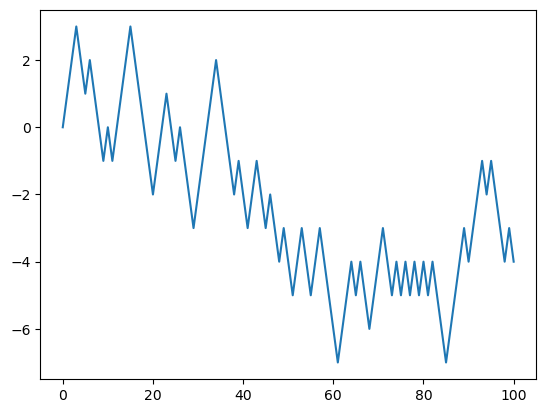

In [4]:
def randomwalk(size):
    # Probability array to move up or down being 0.5 in the equally likely scenario
    prob = [0.5, 0.5]  
    # Statically defining the starting position
    start = 0
    positions = [start]
    # Creating the random points through the np.random.random()
    random_variable = np.random.random(size=size)
    downp = random_variable < prob[0]
    upp = random_variable >= prob[1]  
    # Avoiding potential overlap between up and down events
    upp = upp & (~downp)  # Applying a logical AND with the negation of downp
    for down, up in zip(downp, upp):
        positions.append(positions[-1] - down + up)
        # Plotting down the graph of the random walk in 1D
    plt.plot(positions)
    plt.show()
    return None
        
# set initial size to be 100
randomwalk(100)

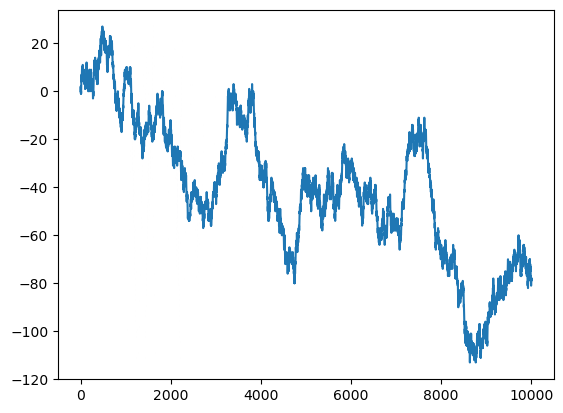

In [5]:
# incrementing the size to be 10000
randomwalk(10000)

We can observe that as we increase the size, we obtain a more "continuous" plot, although this is still defined in discrete terms. However, it gives the idea that if we were modelling it over time, the smaller our step size Δt and the closer we will be to the "idea of continuous". This is the starting point to define our Brownian motion or Wiener Process. 

#### The Wiener Process (or Brownian Motion)

The Wiener process is real-valued continuous-time stochastic process named in honor of the American mathematician Norbert Wiener for his investigations on the mathematical properties of the one-dimensional Brownian motion. It is often also called Brownian motion due to its historical connection with the physical process of the same name originally observed by Scottish botanist Robert Brown.

The Wiener process $W_t$ is characterized by the following properties:

- $W_0 = 0$ almost surely
- $W$ has independent increments: ∀ $t > 0$, the future increments $W_{t+u} - W_t$, $u \geq 0$, are independent of the past values $W_s$, $s < t$.
- $W$ has Gaussian increments: $W_{t+u} - W_t$ is normally distributed with mean $0$ and variance $u$, $W_{t+u} - W_t \sim \mathcal{N}(0,u)$.
- $W$ has almost surely continuous paths: $W_t$ is almost surely continuous in $t$.


That the process has independent increments means that if $0 \leq s_1 < t_1 \leq s_2 < t_2$ then $W_{t_1} - W_{s_1}$ and $W_{t_2} - W_{s_2}$ are independent random variables, and the similar condition holds for $n$ increments.


Some important properties of a one-Dimensional Wiener process:

- The unconditional probability density function follows a normal distribution with mean $0$ and variance $t$, at a fixed time $t$:
\begin{equation}
f_{W_{t}}(x) = \frac{1}{\sqrt{2\pi t}} exp({-\frac{x^2}{2t}})
\end{equation}

- The expectation is zero
\begin{equation}
\mathbb{E}(W_t) = 0
\end{equation}

- The variance is t, as:
\begin{equation}
Var(W_t) = 0
\end{equation}


In order to model the Brownian motion, we are going to use np.random.randn, which returns a sample from the Standard Normal distribution. Utilising the scaling property of the Brownian motion (i.e. $Var(W_t) = 0$), we can therefore say that our Brownian motion at time t (i.e. $W_t$) will be a standard Normal $N(0,1)$ scaled by $\sqrt{t}$


#### Further Properties of Bronwian Motion

The Probability Density Function of a Bronwian Motion satisfies the Fokker-Planck PDE as:

\begin{equation}
\dfrac{\partial}{\partial t}f(x,t)= \dfrac{1}{2}\dfrac{\partial}{\partial x^2}f(x,t).
\end{equation}


The shrinking of the probability distribution, becoming smaller and smaller reminds of the well known Dirac delta function (or δ distribution), also known as the unit impulse is a generalized function on the real numbers, whose value is zero everywhere except at zero, and whose integral over the entire real line is equal to one. This is exactly the property that we are seeking, as continuous probabilities add up to one in an integral sense while the higher the $a$ term the close we get to infinity.

In a heuristic fashion, the Dirac-delta is defined as:

${\displaystyle \delta (x)\simeq {\begin{cases}+\infty ,&x=0\\0,&x\neq 0\end{cases}}}$

and which is also constrained to satisfy the identity (the integral summing up to 1, which characterizes probability density functions):

${\displaystyle \int _{-\infty }^{\infty }\delta (x)\,dx=1.}$

Below a gif of the behaviour of the Dirac-delta function.

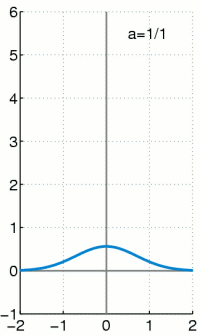

###### Long Time Behaviour

Almost surely,

\begin{equation*}
\lim_{t \rightarrow \infty} \frac{W_t}{t}  = 0
\end{equation*}


This is equivalent of the Law of Large Numbers.

Below some visualizations for Brownian Motion,with the first chart showing the tendency over time to have expectation centered at zero, and for all the realizations, a terminal normal distribution that scales with square root of time.

The second chart shows the shrinking of the probability distributions over smaller time step, while the third chart exemplifieis the Long Time behaviour exhibited by Brownian motion.

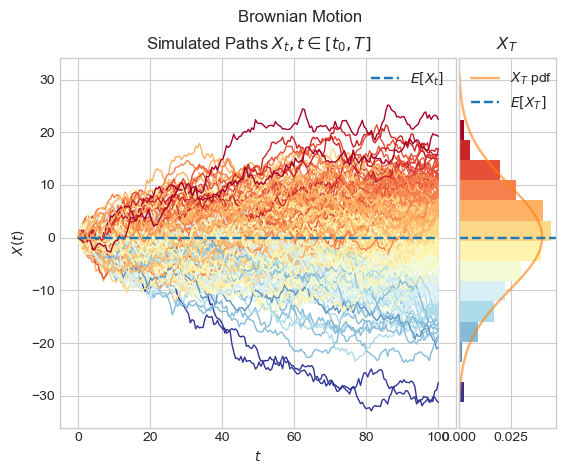

In [6]:
process = BrownianMotion(T=100)
process.draw(n=200, N=200)
plt.show()

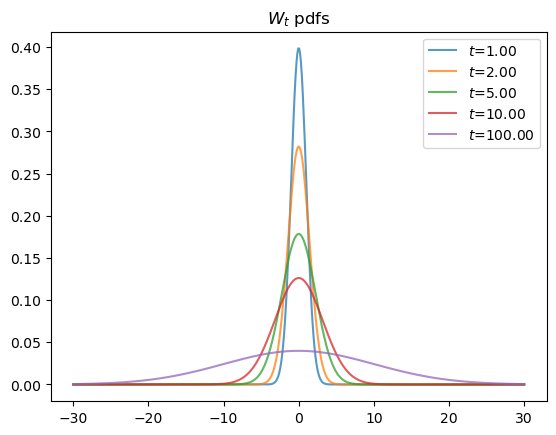

In [7]:
fig, ax1 = plt.subplots(1, 1)
for t in [1,2,5, 10, 100]:
    W_t= process.get_marginal(t)
    x = np.linspace(-30, 30, 500)
    ax1.plot(x, W_t.pdf(x), '-', lw=1.5,
             alpha=0.75, label=f'$t$={t:.2f}')
ax1.legend()
plt.title('$W_t$ pdfs')
plt.show()

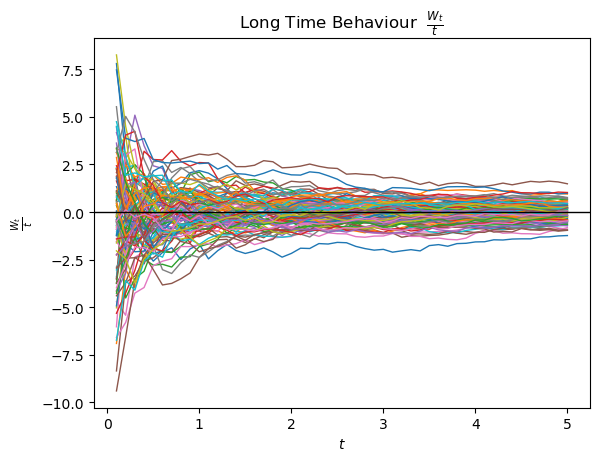

In [8]:
process = BrownianMotion(T=500)
paths = process.simulate(n=5000, N=100)
t = process.times

for w in paths:
    plt.plot(t[1:51], w[1:51]/t[1:51], '-', lw=1)
plt.axhline(y=0, lw=1., color='black')
plt.title('Long Time Behaviour  $\\frac{W_t}{t}$ ')
plt.xlabel('$t$')
plt.ylabel('$\\frac{W_t}{t}$')
plt.show()

#### The Geometric Brownian Motion

A geometric Brownian motion (GBM) (also known as exponential Brownian motion) is a continuous-time stochastic process in which the logarithm of the randomly varying quantity follows a Brownian motion with drift.

In the Risk-Neutral world, a stochastic process $S_t$ follows a GBM if the following stochastic differential equation (SDE) is satisfied:

\begin{equation}
dS_t = rS_tdt + σS_tdW_t
\end{equation}

where $W_t$ is a  Wiener process or Brownian motion, and r the risk-free rate and  𝜎 (i.e. the volatility or the diffusion of the SDE) are constants.

In order for us to appreciate how we obtain the analytic solution for a Geometric Brownian motion, let us treat Ito's Lemma, a milestone in Stochastic Calculus. 

Below some visualizations for Geometric Brownian motion. You will be able to visualize the log-normality in the distribution of each realization, as shown in the right graph, as well as the sample solutions in the left chart. Once we start adding simulations, then we will eventually cover the full region with realizations, as shown in the second chart below, that shows a set of Monte-Carlo simulated asset paths, based on the Geometric Brownian Motion scheme.

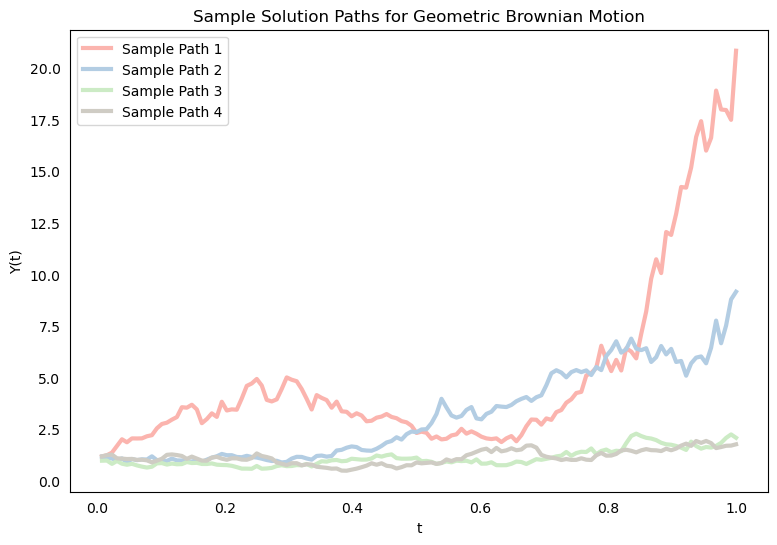

In [9]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
pal = ["#FBB4AE","#B3CDE3", "#CCEBC5","#CFCCC4"]

# SDE model parameters
mu, sigma, X0 = 2, 1, 1

# Simulation parameters
T, N = 1, 2**7
dt = 1.0 / N
t = np.arange(dt, 1 + dt, dt)  # Start at dt because Y = X0 at t = 0

# Initiate plot object
plt.title('Sample Solution Paths for Geometric Brownian Motion')
plt.ylabel('Y(t)'); plt.xlabel('t')

# Create and plot sample paths
for i in range(len(pal)):
    
    # Create Brownian Motion
    np.random.seed(i)
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Compute exact solution
    Y = X0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * B)
    
    # Add line to plot
    plt.plot(t, Y, label = "Sample Path " + str(i+1), color=pal[i])

# Add legend
plt.legend(loc = 2);


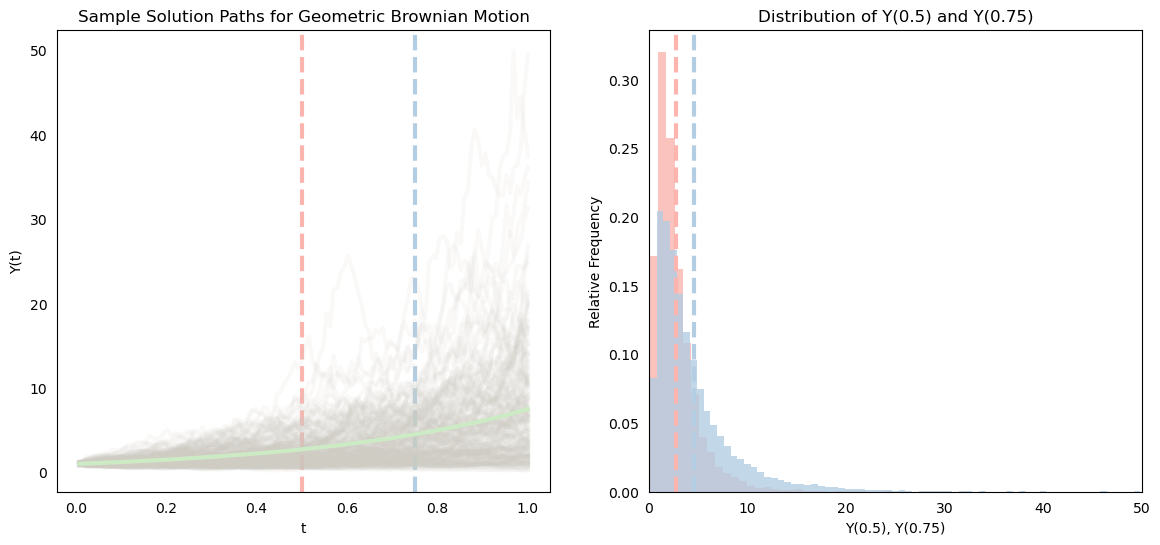

In [10]:
# Initiate lineplot object
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plt.ylabel('Y(t)'); plt.xlabel('t')
plt.title('Sample Solution Paths for Geometric Brownian Motion')
plt.axvline(x=.50, linestyle='--', color=pal[0])
plt.axvline(x=.75, linestyle='--', color=pal[1])

# Simulate sample paths
Y_1, Y_2, Y_total = [], [], []
for i in range(10000):
    
    # Create Brownian Motion
    np.random.seed(i)
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Exact Solution
    Y = X0 * np.exp(((mu - 0.5 * sigma**2) * t) + (sigma * B))
    Y_1.append(Y[int(0.50 * N)])
    Y_2.append(Y[int(0.75 * N)])
    Y_total.append(Y)
    
    # Plot first 200 sample paths
    if i < 200:
        ax.plot(t, Y, label = "Sample Path " + str(i), color=pal[3], alpha=0.1)

# Plot average line
ax.plot(t, np.mean(Y_total, 0), label="Sample Path " + str(i), color=pal[2])

# --------------
# Right-hand plot
# --------------

fig.add_subplot(122)
plt.xlabel('Y(0.5), Y(0.75)'); plt.ylabel('Relative Frequency')
plt.xlim(0,50)
plt.title('Distribution of Y(0.5) and Y(0.75)')
plt.hist(Y_1,color=pal[0],bins=30,density=1,alpha=0.8)
plt.hist(Y_2,color=pal[1],bins=150,density=1,alpha=0.8)
plt.axvline(np.mean(Y_total, 0)[int(0.50 * N)],linestyle='--',color=pal[0])
plt.axvline(np.mean(Y_total, 0)[int(0.75 * N)],linestyle='--',color=pal[1]);

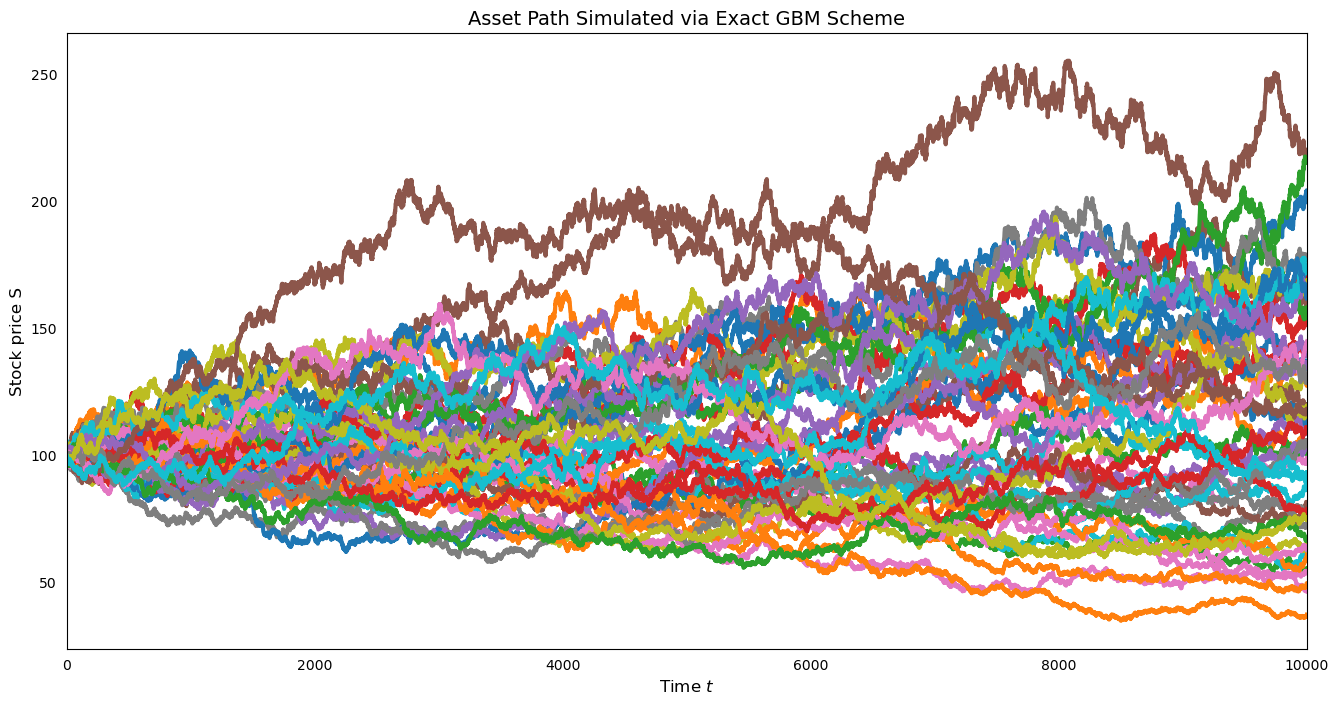

In [11]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 10000, nsim= 50, number_shares=1, option_type='Put',pricing_method = 'Monte Carlo', SDE_sim_type='Exact GBM',hedging_type='Actual',implied_vol=0.2,actual_vol=0.4)
a = bs.asset_path_plot()

### Ito's Lemma


As part of our quick delving into Stochastic Calculus, I would like to present a cornerstone result, which will be essential in deriving the Black-Scholes PDE. Ito's Lemma or Itô's formula (also called the Itô–Doeblin formula, especially in the French literature) is an identity used in Itô calculus to find the differential of a time-dependent function of a stochastic process. It serves as the stochastic calculus counterpart of the chain rule and can be thought as "the stochastic version" of the Taylor expansion, that is deployed for deterministic functions. In a heuristic manner, it can be derived by forming the Taylor series expansion of the function up to its second derivatives and retaining terms up to first order in the time increment and second order in the Wiener process increment. 

Published in 1951 by 
Kiyoshi I, the formula has become a 




#### Pseudo-Derivation through Taylor series expansion

A formal proof of the lemma relies on applying the limit of a sequence of random variables, which involves several technicalities, which we are not going to cover at this stage. We are going, instead, to derive Itô's lemma by expanding a Taylor series and applying the rules of stochastic calculus (i.e. the below Ito's multiplication rule)

##### Ito's Multiplication Rule

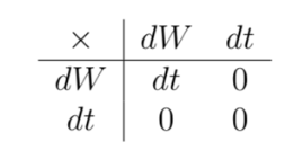

Suppose $X_t$ is an Itô drift-diffusion process that satisfies the stochastic differential equation, where $B_t$ is a Wiener process or a Brownian motion:

\begin{equation}
{\displaystyle dX_{t}=\mu _{t}\,dt+\sigma _{t}\,dB_{t},}
\end{equation}


If $f(t,x)$ is a twice-differentiable scalar function, its expansion in a Taylor series is:

\begin{equation}
{\displaystyle df={\frac {\partial f}{\partial t}}\,dt+{\frac {1}{2}}{\frac {\partial ^{2}f}{\partial t^{2}}}\,dt^{2}+\cdots +{\frac {\partial f}{\partial x}}\,dx+{\frac {1}{2}}{\frac {\partial ^{2}f}{\partial x^{2}}}\,dx^{2}+\cdots .}.\end{equation}

Substituting $X_t$ for $x$ and therefore $μ_tdt+σ_tdB_t$ for $dx$ gives:

\begin{equation}
{\displaystyle df={\frac {\partial f}{\partial t}}\,dt+{\frac {1}{2}}{\frac {\partial ^{2}f}{\partial t^{2}}}\,dt^{2}+\cdots +{\frac {\partial f}{\partial x}}(\mu _{t}\,dt+\sigma _{t}\,dB_{t})+{\frac {1}{2}}{\frac {\partial ^{2}f}{\partial x^{2}}}\left(\mu _{t}^{2}\,(dt)^{2}+2\mu _{t}\sigma _{t}\,dt\,dB_{t}+\sigma _{t}^{2}\,(dB_{t})^{2}\right)+\cdots .}
\end{equation}


In the limit $dt → 0$, the terms $dt^2, dtdB_t → 0$ faster than $dB^2$ which is $O(dt)$. With further manipulation, we come to the famous result:

\begin{equation}
{\displaystyle df=\left({\frac {\partial f}{\partial t}}+\mu _{t}{\frac {\partial f}{\partial x}}+{\frac {\sigma _{t}^{2}}{2}}{\frac {\partial ^{2}f}{\partial x^{2}}}\right)dt+\sigma _{t}{\frac {\partial f}{\partial x}}\,dB_{t}}
\end{equation}







#### Analytical Derivation of the Solution to GBM

In this section, I would like to present the analytical solution for Geometric Brownian Motion using Ito's. 

We can solve the SDE for an arbitrary initial value $S_0$, the above stochastic differential equation (SDE) has the analytic solution (under Itô's interpretation):

\begin{equation}
S_t = S_0 \exp\left((r - \frac{\sigma^2}{2})t + \sigma W_t\right)
\end{equation}

To derive the solution, let us apply Itô calculus. Through Itô's formula leads to:

\begin{equation}
d(\ln S_t) = (\ln S_t)'dS_t + \frac{1}{2}(\ln S_t)''dS_t dS_t = \frac{dS_t}{S_t} - \frac{1}{2}\frac{1}{S_t^2}dS_t dS_t,
\end{equation}

where $dS_t dS_t$ is the quadratic variation of the SDE.

\begin{equation}
dS_t dS_t = \sigma^2 S_t^2 dW_t^2 + 2\sigma S_t^2 r dW_t dt + r^2 S_t^2 dt^2.
\end{equation}

From the Mean Square Limit of the Brownian motion $W_t$
\begin{equation}
\int_{0}^{t}dW^2_t = t
\end{equation}

$dt \to 0$, $dt$ converges to $0$ faster than $dW_t$, since $dW_t^2 = O(dt)$. 

So the above infinitesimal can be simplified by:

$dS_t dS_t = \sigma^2 S_t^2 dt$

Plugging the value of $dS_t$ in the above equation and simplifying, we obtain:

\begin{equation}
\ln\left(\frac{S_t}{S_0}\right) = \left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t.
\end{equation}

Taking the exponential and multiplying both sides by $S_0$, we therefore obtain the above analytic solution.

In the defined SDE, we can observe the deterministic term (i.e. the $rSdt$, also called the drift) and the stochastic part (i.e. the $\sigma SW_t$ term, also called the diffusion). These two components constitute our stochastic differential equation, and in a similar fashion, we retrieve this bifurcation in our analytic solution, where the deterministic term is the $S_0exp(r-0.5σ^2) $ whereas the stochastic term is driven by the Brownian motion $S_0exp(σW_t)$

We can therefore model our Geometric Brownian motion in this fashion, and use the np.random.standard_normal to obtain our Standard Normal random variable, and np.cumsum, which returns the cumulative sum of the elements along a given axis. This is further scaled to $\sqrt{dt}$ according to the Scaling property of the Wiener process

### Numerical Approaches for SDEs

There are various numerical schemes to solve stochastic differential equations, we will focus on the Euler-Maruyama method. This is an extension of the Euler method for ordinary differential equations (ODEs) to stochastic differential equations. It is named after Leonhard Euler and Gisiro Maruyama and it is one of the cornerstone numerical methods within Ito's Calculus We will also touch upon the Milstein Scheme, named after Grigori N. Milstein who first published it in 1974. This techniques increases the accuracy of the Euler-Maruyama approximation by adding a second-order “correction” term, which is derived from the stochastic Taylor series expansion..

#### The Euler-Maruyama Numerical Scheme

The Euler–Maruyama method is a method for the approximate numerical solution of a stochastic differential equation (SDE). 

Consider the general SDE given by:

\begin{equation}
\mathrm{d}X_{t} = a(X_{t},t)dt + b(X_{t},t)dW_{t}
\end{equation}

where $W_t$ stands for the Wiener process (or Brownian Motion)

Then the Euler–Maruyama approximation to the true solution $X$ is the Markov chain $Y$ defined as follows:

- partition the interval $[0, T]$ into N equal subintervals of width  $Δt>0$

\begin{equation}
0 = \tau_0 < \tau_1 < \ldots < \tau_N = T
\end{equation}

- Set \begin{equation} Y_0=x_0 \end{equation}

- Recursively, define \begin{equation} Y_n: ∀ 0 ≤ n ≤ N-1 \end{equation} by

\begin{equation} Y_{n+1} = Y_n + a(Y_n,\tau_n) \end{equation}

In case of the Geometric Brownian Motion, our Euler-Maruyama scheme will be the following discretized SDE:

\begin{equation}
S_{i+1} = S_{i}(1+rdt + σw)
\end{equation}

where

- $w$ is a random number sampled from a standard Normal Distribution $N(0,1)$ and scaled by the square root of time

The Euler-Maruyama scheme turns out to be incredibly useful when we do not have an analytic formulation for the solution of a SDE, while we do have in the case of the Geometric Brownian Motion (as explained above)



##### Euler Maruyama in Integral Form:

\begin{equation}
Y(t_{n+1}) - Y(t_{n}) = \mu\int^{t_{n+1}}_{t_n}  Y(s) ds + \sigma\int^{t_{n+1}}_{t_n}  Y(s) dB(s)
\end{equation}


Below some visualizations for the Euler-Maruyama scheme, to show you how close it is able to approximate a solution of a stochastic differential equations (e.g. GBM), and a set of Monte Carlo simulated asset paths via the Euler-Maruyama scheme, in the context of Geometric Brownian motion. Moreover, in the last chart, I would like to show the terminal underlying price distribution for the analytical solution and the Euler-Maruyama scheme, which turns to be "almost visually" Log-normal. We can further see that the larger the timeframe we observe underlying price, its empirical density will converge to a Log-Normal distribution.

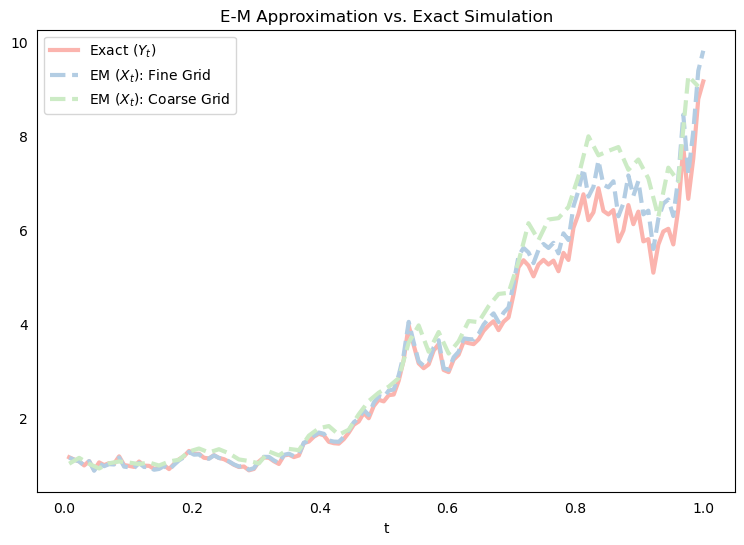

In [12]:
# Create Brownian Motion
np.random.seed(1)
dB = np.sqrt(dt) * np.random.randn(N)
B  = np.cumsum(dB)

# Exact Solution
Y = X0 * np.exp((mu - 0.5*sigma**2)*t + (sigma * B))

# EM Approximation - small dt
X_em_small, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j]
    X_em_small.append(X)

# EM Approximation - big dt
X_em_big, X, R = [], X0, 2
coarse_grid = np.arange(dt,1+dt,R*dt)
for j in range(int(N/R)):
    X += mu*X* (R*dt) + sigma*X*sum(dB[R*(j-1):R*j])
    X_em_big.append(X)    
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)", color=pal[0])
plt.plot(t, X_em_small, label="EM ($X_t$): Fine Grid", color=pal[1], ls='--')
plt.plot(coarse_grid, X_em_big, label="EM ($X_t$): Coarse Grid", color=pal[2], ls='--')
plt.title('E-M Approximation vs. Exact Simulation'); plt.xlabel('t'); plt.legend(loc = 2);

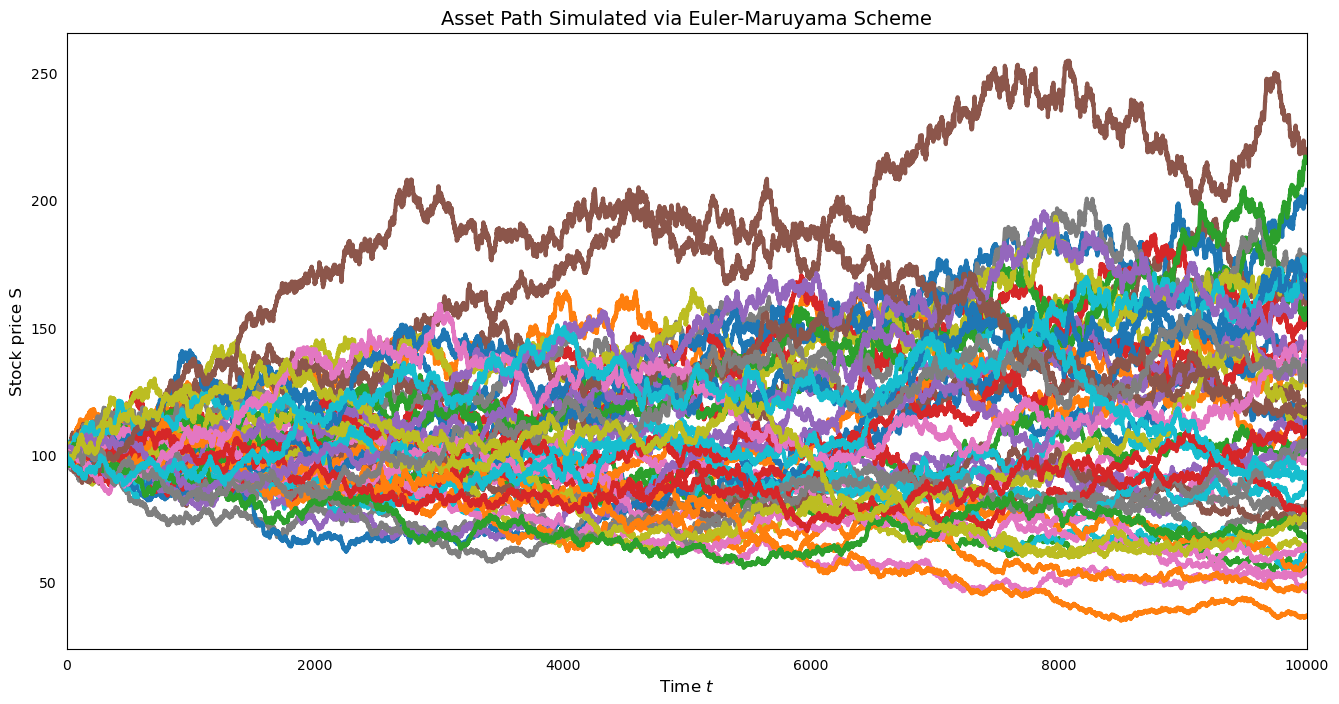

In [13]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 10000, nsim= 50, number_shares = 1, option_type='Put',pricing_method = 'Monte Carlo', SDE_sim_type='Euler-Maruyama',hedging_type='Actual',implied_vol=100,actual_vol=0.4)
a = bs.asset_path_plot()

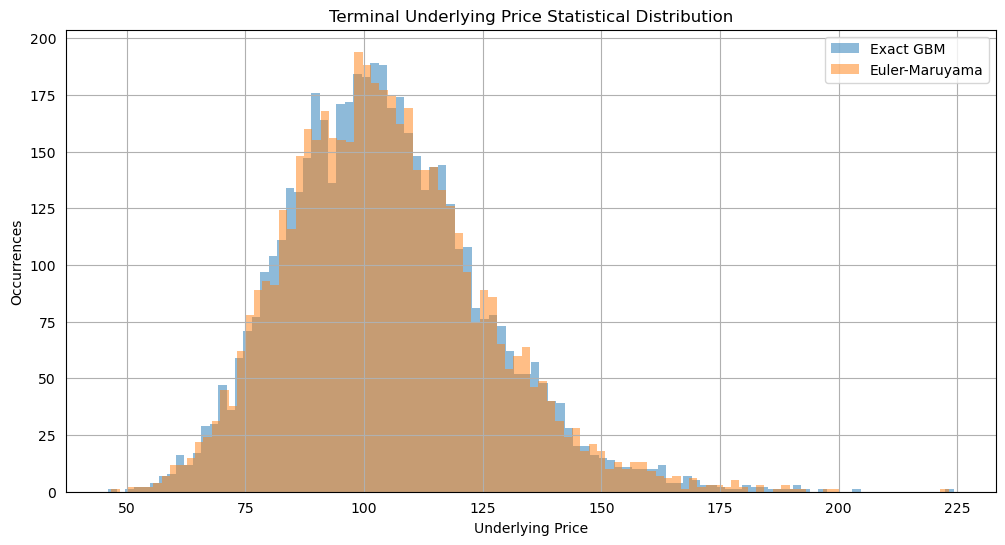

In [14]:
# Create an instance of the BlackScholes class
black_scholes_simulator = BlackScholes(
    spot=100, strike=100, r=0.05, T=1, option_type='call', timesteps=365, 
    nsim=5000, number_shares=100, SDE_sim_type='Exact GBM', hedging_type=None, 
    pricing_method=None, implied_vol=0.2, actual_vol=0.2, var_red_method=None
)

# Simulate using the Exact GBM method
black_scholes_simulator.SDE_sim_type = 'Exact GBM'
gbm_paths = black_scholes_simulator.multiple_MonteCarlo_simulator()

# Simulate using the Euler-Maruyama method
black_scholes_simulator.SDE_sim_type = 'Euler-Maruyama'
em_paths = black_scholes_simulator.multiple_MonteCarlo_simulator()

# Plot the results
plt.figure(figsize=(12, 6))
plt.hist(gbm_paths[-1], bins=100, alpha=0.5, label='Exact GBM')
plt.hist(em_paths[-1], bins=100, alpha=0.5, label='Euler-Maruyama')
plt.xlabel('Underlying Price')
plt.ylabel('Occurrences')
plt.title('Terminal Underlying Price Statistical Distribution')
plt.legend()
plt.grid(True)
plt.show()

#### The Milstein Scheme

Consider the general SDE given by:

\begin{equation}
\mathrm{d}X_{t} = a(X_{t},t)dt + b(X_{t},t)dW_{t}
\end{equation}


\begin{equation}
 X_{n+1} - X_n = a(X_n)\Delta t + b(X_n)\Delta B_n {+ \frac{1}{2}b'(X_n)b(X_n)\left((\Delta B_n)^2-\Delta t\right)} 
\end{equation}

with initial condition ${\displaystyle X_{0}=x_{0}}$, where $W_t$ denotes the Wiener process, and suppose that we wish to solve this SDE on some interval of time ${\displaystyle [0,T]}$. 



Then the Milstein approximation to the true solution $X$  is the Markov chain ${\displaystyle Y}$ defined as follows:

- Partition the interval ${\displaystyle [0,T]}$ into N of equal size sub-intervals of width $ {\displaystyle \Delta t>0}$

\begin{equation}
{\displaystyle 0=\tau _{0}<\tau _{1}<\dots <\tau _{N}=T{\text{ with }}\tau _{n}:=n\Delta t{\text{ and }}\Delta t={\frac {T}{N}}}
\end{equation}

- Set ${\displaystyle Y_{0}=x_{0};}$
- Recursively define ${\displaystyle Y_{n}:  \forall n   {\displaystyle 1\leq n\leq N}} $ 







The Milstein derivation is the following: 

${\displaystyle {\begin{aligned}X_{t+\Delta t}&=X_{t}\exp \left\{\int _{t}^{t+\Delta t}\left(\mu -{\frac {1}{2}}\sigma ^{2}\right)\mathrm {d} t+\int _{t}^{t+\Delta t}\sigma \mathrm {d} W_{u}\right\}\\&\approx X_{t}\left(1+\mu \Delta t-{\frac {1}{2}}\sigma ^{2}\Delta t+\sigma \Delta W_{t}+{\frac {1}{2}}\sigma ^{2}(\Delta W_{t})^{2}\right)\\&=X_{t}+a(X_{t})\Delta t+b(X_{t})\Delta W_{t}+{\frac {1}{2}}b(X_{t})b'(X_{t})((\Delta W_{t})^{2}-\Delta t)\end{aligned}}}$


Below some visualizations for the Milstein scheme, as we would like to simulate a single path using the same draw from the Brownian motion above, and plot it with the exact solution and the Euler-Maruyama approximation (E-M). We can observe that the Milstein approximation line in green looks to be closer than the corresponding E-M approximation. This is because of the second order nature of the Milstein approximation, resulting in a lower approximation error. Also, in the second chart, I would like to present a set of Monte Carlo simulated asset paths via the Milstein scheme, in the context of Geometric Brownian motion. Lastly, a chart that similarly to the Euler-Maruyama scheme, it shows the terminal underlying price distribution.


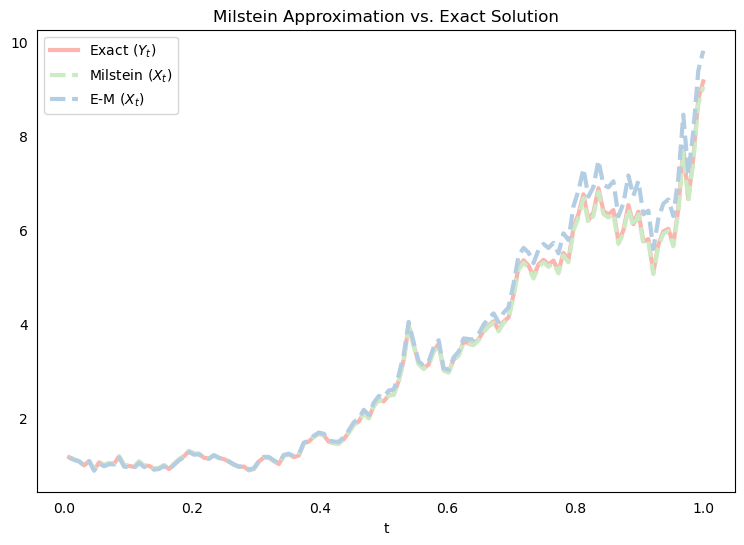

In [15]:
# Milstein Approximation
Xmil, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j] + 0.5*sigma**2 * X * (dB[j] ** 2 - dt)
    Xmil.append(X)
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)",color=pal[0])
plt.plot(t, Xmil, label="Milstein ($X_t$)",color=pal[2],ls='--')
plt.plot(t, X_em_small, label="E-M ($X_t$)",color=pal[1],ls='--')
plt.title('Milstein Approximation vs. Exact Solution')
plt.xlabel('t'); plt.legend(loc=2);

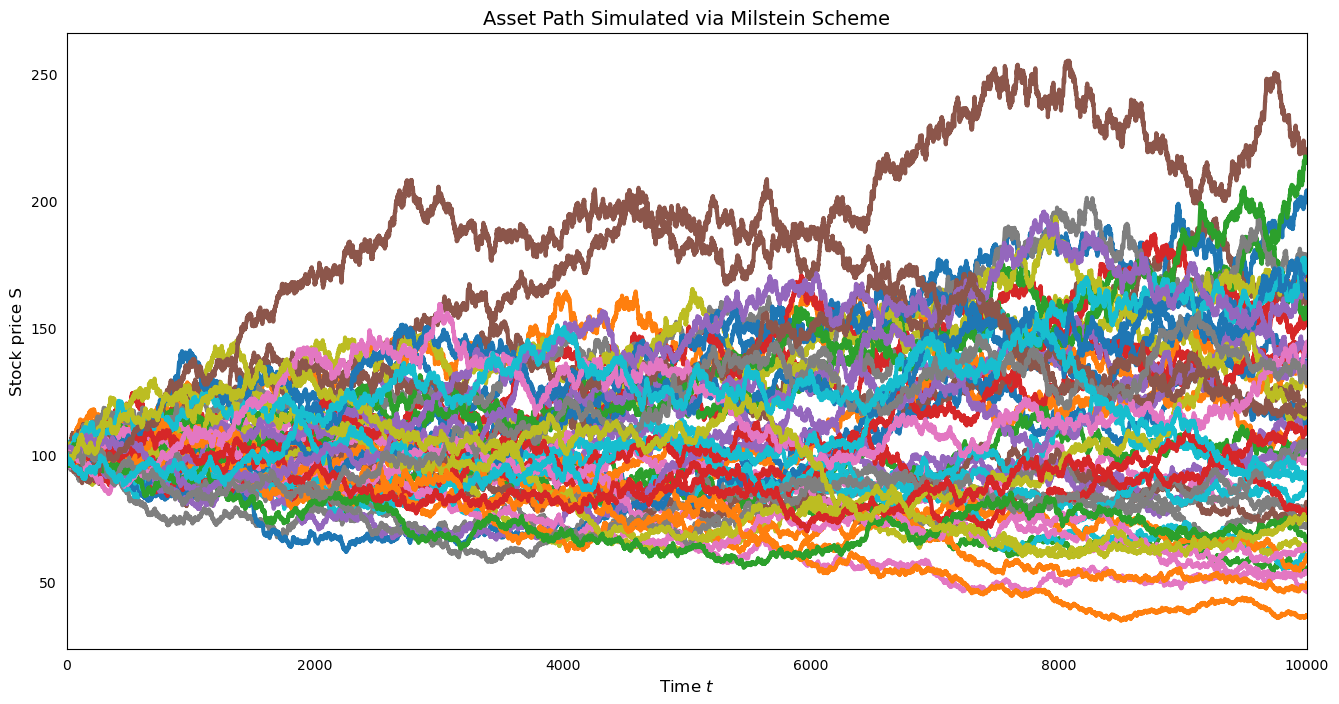

In [16]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 10000, nsim= 50, number_shares = 1, option_type='Put',SDE_sim_type='Milstein',hedging_type='Actual',implied_vol=100,actual_vol=0.4,pricing_method = 'Black Scholes')
a = bs.asset_path_plot()

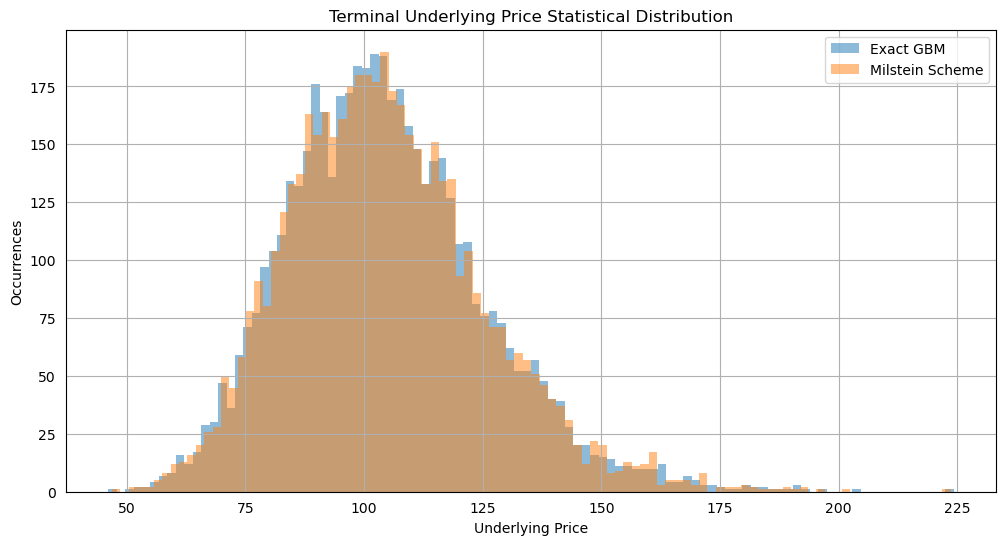

In [17]:
# Create an instance of the BlackScholes class
black_scholes_simulator = BlackScholes(
    spot=100, strike=100, r=0.05, T=1, option_type='call', timesteps=365, 
    nsim=5000, number_shares=100, SDE_sim_type='Exact GBM', hedging_type=None, 
    pricing_method=None, implied_vol=0.2, actual_vol=0.2, var_red_method=None
)

# Simulate using the Exact GBM method
black_scholes_simulator.SDE_sim_type = 'Exact GBM'
gbm_paths = black_scholes_simulator.multiple_MonteCarlo_simulator()

# Simulate using the Euler-Maruyama method
black_scholes_simulator.SDE_sim_type = 'Milstein'
milstein_paths = black_scholes_simulator.multiple_MonteCarlo_simulator()

# Plot the results
plt.figure(figsize=(12, 6))
plt.hist(gbm_paths[-1], bins=100, alpha=0.5, label='Exact GBM')
plt.hist(milstein_paths[-1], bins=100, alpha=0.5, label='Milstein Scheme')
plt.xlabel('Underlying Price')
plt.ylabel('Occurrences')
plt.title('Terminal Underlying Price Statistical Distribution')
plt.legend()
plt.grid(True)
plt.show()

### Convergence Analysis

In the spectrum of numerical analysis, we then wish to formalise the concept of convergence in the context of stochastic processes,(i.e. one stochastic process to get closer to another as the discrete time $\Delta t \to 0$


#### Weak Convergence
For weak convergence, we define the following error term:
\begin{equation}
e^w(\Delta t) = \sup_{t_n}|E(X(t_n)) - E(Y(t_n))|
\end{equation}

#### Strong Convergence
For strong convergence we define
\begin{equation}
e^s(\Delta t) = \sup_{t_n} E(|X(t_n) - Y(t_n)|)
\end{equation}




These terms are also often alternatively defined for a particular point rather than the the supremum over the interva
l $\lim_{\Delta t\rightarrow 0}e^i(\Delta t) = 0$





The Milstein scheme has both weak and strong order of convergence ${\displaystyle \Delta t}$ which is superior to the Euler–Maruyama method, which in turn has the same weak order of convergence ${\displaystyle \Delta t}$ but inferior strong order of convergence ${\displaystyle {\sqrt {\Delta t}}}$


$\lim_{\Delta t\rightarrow 0}e^i(\Delta t) = 0$

Notice the difference between the two types of convergence. The weak error term simply computes the error between the expected values of the two stochastic processes at a given point. So weak convergence captures the average behavior of the simulated approximations. The strong error term, on the other hand, is the mean of errors, which captures the difference between the approximation and the exact solution for each individual sample path before the average is taken. Strong convergence is therefore more demanding.

So the appropriate sense of convergence here depends on whether we are interested in the “closeness” of the whole trajectory of the solution to the SDE (in which case we care about strong convergence) or in the expected value of some function of the process (which relates to weak convergence). For a European put option, for example, we are only interested in the the price of a stock at a given date, so we would mostly be interested in weak convergence. 

In [18]:
# Initiate dt grid and lists to store errors
str_err_em, str_err_mil, weak_err_em, weak_err_mil = [], [], [], []
dt_grid = [2 ** (R-10) for R in range(7)]
mc = 10000

# Loop over values of dt
for Dt in dt_grid:
    
    # Setup discretized grid 
    t = np.arange(Dt, 1 + Dt, Dt)
    n = len(t)
    
    # Initiate vectors to store errors and time series
    err_em, err_mil = np.zeros(n), np.zeros(n)
    Y_sum, Xem_sum, Xmil_sum = np.zeros(n), np.zeros(n), np.zeros(n)
    
    # Generate many sample paths
    for i in range(mc):
        
        # Create Brownian Motion
        np.random.seed(i)
        dB = np.sqrt(Dt) * np.random.randn(n)
        B  = np.cumsum(dB)
        
        # Exact solution
        Y = X0 * np.exp((mu - 0.5*sigma**2)*t + sigma * B)
        
        # Simulate stochastic processes
        Xemt, Xmilt, Xem, Xmil = X0, X0, [], []
        for j in range(n):

            # Euler-Maruyama
            Xemt += mu*Xemt* Dt + sigma * Xemt * dB[j]
            Xem.append(Xemt)
            
            # Milstein
            Xmilt += mu*Xmilt*Dt + sigma*Xmilt*dB[j] + 0.5*sigma**2*Xmilt*(dB[j]**2 - Dt)
            Xmil.append(Xmilt)
            
        # Compute strong errors and add to those across from other sample paths
        err_em  += abs(Y - Xem)
        err_mil += abs(Y - Xmil)
        
        # Add Y and X values to previous sample paths
        Y_sum += Y
        Xem_sum += Xem
        Xmil_sum += Xmil
        
    # Compute mean of absolute errors and find maximum (strong error)
    str_err_em.append(max(err_em / mc))
    str_err_mil.append(max(err_mil / mc))
    
    # Compute error of means and find maximum (weak error)
    weak_err_em.append(max(abs(Y_sum - Xem_sum)/mc))
    weak_err_mil.append(max(abs(Y_sum - Xmil_sum)/mc))

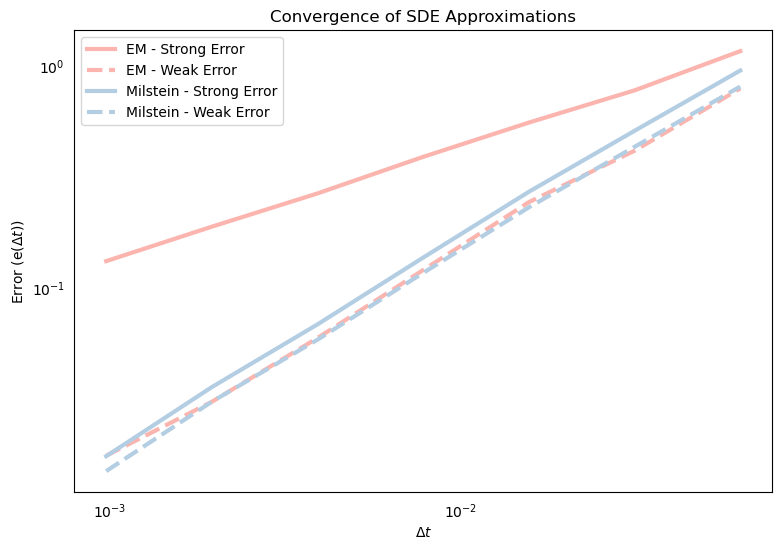

In [19]:
# Plot
plt.loglog(dt_grid, str_err_em, label="EM - Strong Error",color=pal[0])
plt.loglog(dt_grid, weak_err_em, label="EM - Weak Error",color=pal[0],ls='--')
plt.loglog(dt_grid, str_err_mil, label="Milstein - Strong Error",color=pal[1])
plt.loglog(dt_grid, weak_err_mil, label="Milstein - Weak Error",color=pal[1],ls='--')
plt.title('Convergence of SDE Approximations')
plt.xlabel('$\Delta t$'); plt.ylabel('Error (e($\Delta t$))'); plt.legend(loc=2);

We can observe that the strong and weak error terms fall with $\Delta t$ which suggests that both approximations are stongly and weakly convergent. We can also convene that the both numerical schemes converge to approximate the SDE, but we are wondering about the rate of convergence, as we are mostly interested in the speed of this convergence.

### Rate of Convergence

In numerical analysis, the order of convergence and the rate of convergence of a convergent sequence are quantities that represent how quickly the sequence approaches its limit. A sequence ${\displaystyle (x_{n})}$ that converges to $L$ has order of convergence $q≥1$ and a rate of convergence $\mu$ if 

${\displaystyle \lim _{n\rightarrow \infty }{\frac {\left|x_{n+1}-L\right|}{\left|x_{n}-L\right|^{q}}}=\mu .}$

The rate of convergence $\mu$ is also defined as the asymptotic error constant. 

In the context of stochastic differential equations, we look at how close the error shrinks with $\Delta t$, so we say that an approximation numerical scheme  has a rate of convergence equal to $\gamma$ if and only if:


$e(\Delta t) \leq C (\Delta t) ^ \gamma$

The order of convergence is therefore $\gamma$ and we are then interested to reduce $\Delta t$ and so let us look at strong convergence via the Markov's inequality, as the probability that a random variable $Z$ is greater than a positive constant $a$, so: 

$\mathbb{P}(Z\geq a) \leq \mathbb{E}(Z)/a$

Substituting in the error term, then it yields:

$\displaystyle{\mathbb{P}(|X(t) - Y(t)|\geq a) \leq \mathbb{E}(|X(t) - Y(t)|)/a \leq C(\Delta t)^\gamma/a}$


which also:

$\displaystyle{\mathbb{P}(|X(t) - Y(t)| < (\Delta t)^{\gamma/2}) \geq 1 - C(\Delta t)^{\gamma/2}}$

This translates into having the error at any fixed point being small with probability close to 1.

If the inequality then holds as an equality, by taking the logarithms, we then obtain the following linear relationship.

$\log(e(\Delta t)) =  \log(C) + \gamma \log(\Delta t)$

This can be estimated by running an Ordinary Least Square model (OLS) to obtain the various rates of convergences as below.

In [20]:
X = sm.add_constant(np.log(dt_grid))

# Run OLS on above simulations to estimate gamma values
results = sm.OLS(np.log(weak_err_em),X).fit()
print("Weak E-M Convergence:        "+ str(results.params[1]))

results = sm.OLS(np.log(weak_err_mil),X).fit()
print("Weak Milstein Convergence:   "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_em),X).fit()
print("\nStrong E-M Convergence:      "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_mil),X).fit()
print("Strong Milstein Convergence: "+ str(results.params[1]))

Weak E-M Convergence:        0.9297415482552578
Weak Milstein Convergence:   0.9597912253628358

Strong E-M Convergence:      0.5203110424727103
Strong Milstein Convergence: 0.9631946258771567


### Monte Carlo Methods for Option Pricing

In the context of option pricing, with a special remark to exotic options, that will not be treated in this instance, Monte Carlo option pricing methods are extremely useful and very much utilised in the industry. 

To price our options, we will deploy the Fundamental Theorem of Asset Pricing in the Monte Carlo framework, under the Risk Neutral measure $\mathbb{Q}$, the value of an option $V(S,t)$ is simply computed through the expected discounted payoff based on simulating a set of terminal underlying prices. 


\begin{equation}
V(S, t) = \exp(-r(T-t)) \mathbb{E}^\mathbb{Q}[\text{Payoff}(S_T)]
\end{equation}


Since the Monte Carlo methods accept a greater level of variability in the underlying price realizations, this increase the variance around the fair value of an option. This is then impacting our estimates of the option price by increased noise around the true value. Monte Carlo methods are also computationally expensive (i.e. a decent estimation of an option price as shown below requires at least 10,000 if not 100,000 simulations to get closer to the Black-Scholes price. So, if we seek to minimize the number of simulations, we can lean on Variance Reduction methods which work on the same principles as that of hedging an option position (i.e. the variability of a hedged option portfolio will have a smaller variance that that of it's unhedged counterpart).


### Antithetic Variates Introduction

In statistics, the antithetic variates method is a variance reduction technique used in Monte Carlo methods. Considering that the error in the simulated signal (using Monte Carlo methods) has a one-over square root convergence, a very large number of sample paths is required to obtain an accurate result. The antithetic variates method reduces the variance of the simulation results.


#### The Philosophy of Antithetic Variates

Within the context of random variables, the antithetic variates technique consists, for every sample path obtained, in taking its antithetic path — that is given a path ${\displaystyle \{\varepsilon _{1},\dots ,\varepsilon _{M}\}}$ to also take ${\displaystyle \{-\varepsilon _{1},\dots ,-\varepsilon _{M}\}}$. 


The advantage of this technique is quintessential in reducing the number of normal samples to be taken to generate N paths, as well as the variance of the sample paths, improving the precision.

Suppose that we would like to estima the below parameter:

${\displaystyle \theta =\mathrm {E} (h(X))=\mathrm {E} (Y)\,}$

For that we have generated two samples

${\displaystyle Y_{1}{\text{ and }}Y_{2}\,}$


An unbiased estimate of ${\displaystyle {\theta }}$ is given by:

${\displaystyle {\hat {\theta }}={\frac {Y_{1}+Y_{2}}{2}}.}$


${\displaystyle {\text{Var}}({\hat {\theta }})={\frac {{\text{Var}}(Y_{1})+{\text{Var}}(Y_{2})+2{\text{Cov}}(Y_{1},Y_{2})}{4}}}$



### Antithetic Variates for Monte Carlo 

Within the context of Monte Carlo simulations to generate asset price paths with the goal of computing the option price, this variance reduction techniques turns extremely useful in decreasing overall variance.

Let us assume a pair of assets $(S_1,S_2)$ of perfectly negatively correlated asset processes, which satisfy the below SDEs:

$S^u_t = S_{t-1} exp[(\mu - \frac{1}{2}\sigma ^2)dt + \sigma \sqrt{dt} Z_{t}]$

$S^d_t = S_{t-1} exp[(\mu - \frac{1}{2}\sigma ^2)dt - \sigma \sqrt{dt} Z_{t}]$

Since the price and volatility of the two assets are identical, so is the value of these two options. However, when designing the portfolio composed of the two options, it will exhibit less variance in its pay-off compared to the variance of the pay-off of each individual contract. In essence, the goal is to remove the large spike in probability distribution of a single contract pay-off (i.e. when one option pays out, the other does not).

In order to implement an antithetic variate pricing tool for European Options, we create a hypothetical asset which is perfectly negatively correlated with the original asset.  

#### Contract Simulation

$ C_{T,i} = max(0, S \exp( \nu \Delta T + \sigma \sqrt{T} (\epsilon_i) ) – K)$

$(z_{t+\Delta t}- z_t) \sim N(0,\Delta t) \sim \sqrt{\Delta t} N(0,1) \sim \sqrt{\Delta t} \epsilon_i$


Below, an application to option pricing via Antithetic Variates and the proof that we have recuced variance around our estimates by running a very small number of simulations, compared to standard Monte Carlo methods.

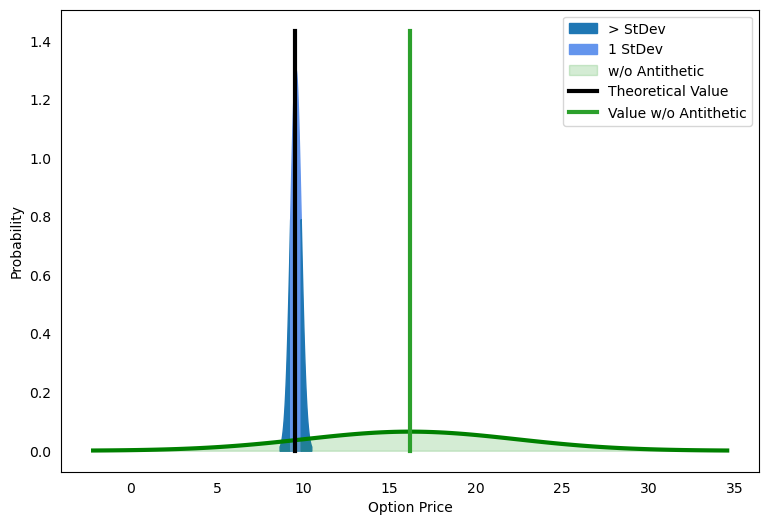

In [21]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 15, number_shares = 1, option_type='Call',SDE_sim_type='Milstein',hedging_type='Actual',implied_vol=0.2,actual_vol=0.2,pricing_method = 'Black Scholes',var_red_method='Antithetic Variates')
var_red_plot = bs.variance_reduction_plots()

In [22]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 10000, nsim= 1000, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',hedging_type='Actual',implied_vol=0.2,actual_vol=0.2,pricing_method = 'Monte Carlo', var_red_method = None)
print("Standard Monte Carlo with only 1,000 Simulations:")
print(bs.option_pricer())


Standard Monte Carlo with only 1,000 Simulations:
9.499085129759159


In [23]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 10000, nsim= 1000, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',hedging_type='Actual',implied_vol=0.2,actual_vol=0.2,pricing_method = 'Monte Carlo', var_red_method = 'Antithetic Variates')
print("Monte Carlo with Antithetic Variates Price:")
print(bs.option_pricer())


Monte Carlo with Antithetic Variates Price:
10.552422822526264


With only 1,000 simulations, we were able to obtain a fair estimates closer to Black-Scholes price (10.45), then the normal Monte Carlo (9.49). Below, I also want to show you that in order to obtain the fair value of the option, within a normal Monte Carlo method, it is required to run 100,000 simulations.

In [24]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100000, number_shares = 1, option_type='Call',SDE_sim_type='Euler-Maruyama',hedging_type='Implied',implied_vol=0.2,actual_vol=0.2,pricing_method = 'Monte Carlo')
print(f"Monte Carlo Price with 100,000 simulations:")
print(bs.option_pricer())


Monte Carlo Price with 100,000 simulations:
10.471421394809846


## 1.4 Black-Scholes Pricing and Delta Hedging

In this section, moving away from Monte Carlo methods, I am going to present the typical Black-Scholes continuous time delta hedging and contemplate the famous Black-Scholes Partial Differential Equation:

\begin{equation}
{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}} - rV = 0
\end{equation}

I will derive the PDE using the No-Arbitrage priciple and Ito's Lemma.


### Derivation (through constructing the Delta Hedging Portfolio)


Let us assume that the underlying asset S follows a risk-neutral log-normal random walk, that is described by the below SDE:

\begin{equation}
{\displaystyle {\frac {dS}{S}}=r \,dt+\sigma \,dW\,}
\end{equation}

where:

- $W$ is Brownian motion (or Wiener process)
- $r$ is the risk-free rate
- $\sigma$ is the volatility 

By applying Ito's Lemma, we obtain:
\begin{equation}
{\displaystyle dV=\left(r S{\frac {\partial V}{\partial S}}+{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}\right)dt+\sigma S{\frac {\partial V}{\partial S}}\,dW}
\end{equation}



Construct the portfolio $\Pi$ defined by:

${\displaystyle \Pi =V - \Delta S }$

This portfolio is long one option and short a position of such quantity ($\Delta$) in the underlying asset.

Let us analyse the change in the portfolio, over the time period ${\displaystyle [t,t+dt]}$, as the $\Delta$ is fixed in the time span, the total profit or loss from changes in the values of the portfolio is:

${\displaystyle  d\Pi =dV-\Delta\,dS}$

Apply then Ito's Lemma to obtain:

\begin{equation}
{\displaystyle dV= \frac{\partial V}{\partial t}dt + \frac{\partial V}{\partial S}dS + \frac{1}{2}\sigma ^2 S^2 \frac{\partial ^2 V}{\partial S^2}dt}
\end{equation}


This can also be expressed, separating the deterministic and stochastic component as:

\begin{equation}
{\displaystyle dV= (\frac{\partial V}{\partial t} + \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma ^2 S^2 \frac{\partial ^2 V}{\partial S^2})dt + \sigma S \frac{\partial V}{\partial S}dX}
\end{equation}

The risk is captured in the stochastic component, and we would like to eliminate risk.

Then, again separating the $dt$ and $dS$ term (in which the randomness lies into), the portfolio changes can be therefore written as:

\begin{equation}
{\displaystyle d\Pi = (\frac{\partial V}{\partial t} + \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma ^2 S^2 \frac{\partial ^2 V}{\partial S^2})dt + (\frac{\partial V}{\partial S} - \Delta)dS}
\end{equation}


By choosing the quantity delta to be:

$\displaystyle{\Delta = \frac{\partial V}{\partial S}}$

we can eliminate risk, and therefore the randomness arising from the Brownian motion term has fully vanished (i.e. the $dX$ term).

Any reduction in randomness is generally termed hedging. The perfect elimination of risk, by exploiting correlation between two instruments (in this case an option and its underlying) is what we are seeking in this project,(i.e. Delta hedging).

When executed dynamically, this means continuous rebalancing to always reach the perfect hedge.

Moving on, after choosing the quantity ∆ as suggested above, we hold a portfolio whose value changes by the amount:

\begin{equation}
{\displaystyle d\Pi = (\frac{\partial V}{\partial t} + \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma ^2 S^2 \frac{\partial ^2 V}{\partial S^2})dt}
\end{equation}


The change is completely risk-less and therefore, in the case we have a completely risk-free change dΠ in the value Π then it must be equivalent as putting the amount of cash in a risk-free interest-bearing account. Hence, we can apply the devoted No-Abitrage priciple (i.e. the arbitrage-free portfolio must earn the risk-free rate), so:

\begin{equation}
{\displaystyle d \Pi =r\Pi \,dt}
\end{equation}

Therefore, substituting our results, we obtain:

\begin{equation}
{\displaystyle \left({\frac {\partial V}{\partial t}} + {\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}\right)dt=r\left(V-S{\frac {\partial V}{\partial S}}\right)dt}
\end{equation}

Simplifying the $dt$ term as we defined the equation in the neighbourhood around dt, we therefore obtain the very much acclaimed  Black–Scholes partial differential equation:
\begin{equation}
{\displaystyle {\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0}
\end{equation}



We will not treat the derivation of the solution in detail, but I would like to then apply the Black Scholes pricing engine code to price a European call in this manner:

${\displaystyle {\begin{aligned}C(S_{t},t)&=N(d_{+})S_{t}-N(d_{-})Ke^{-r(T-t)}\\d_{+}&={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\d_{-}&=d_{+}-\sigma {\sqrt {T-t}}\\\end{aligned}}}$


In [25]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 50, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',hedging_type='Actual',implied_vol=0.2,actual_vol=0.4,pricing_method = 'Black Scholes')
print("Black Scholes Price:")
print(bs.option_pricer())


Black Scholes Price:
10.450583572185565


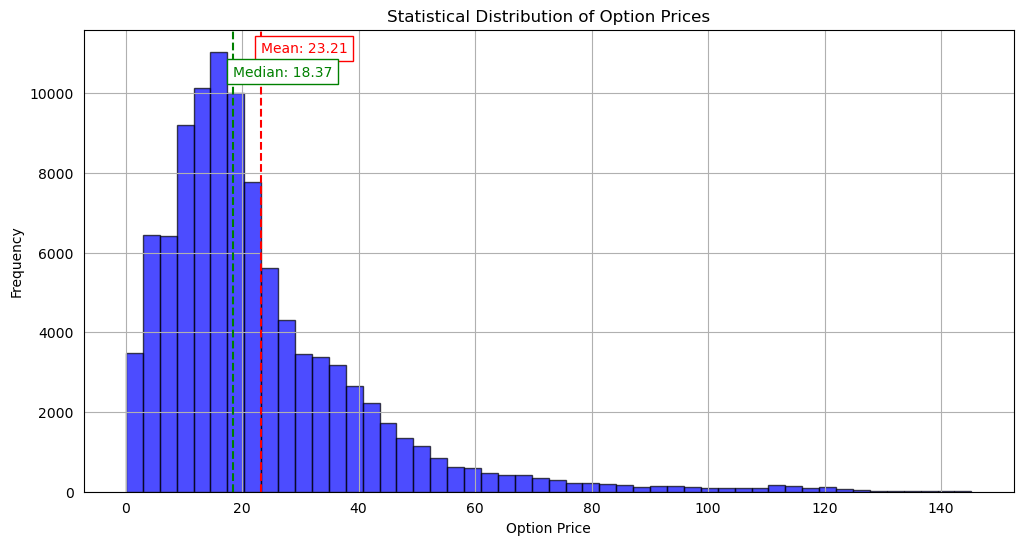

In [26]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',pricing_method = 'Monte Carlo', SDE_sim_type='Euler-Maruyama',hedging_type='Delta-Hedging',implied_vol=0.2,actual_vol=0.3)
stat_dist = bs.plot_option_price_distribution()


### The Greeks


From the famous partial differential equation, we can derive the Greeks (i.e. the sensitivity of the option price to the its variables). Below a summary table, we will treat some of them with more care and show the full derivation.

| Greek    | Symbol                                 | Call                                                          | Put                                                         
|----------|----------------------------------------|---------------------------------------------------------------|----------
| **Delta**| $\frac{\partial V}{\partial S}$        | $N(d_{+})$                                                    | $-N(-d_{+}) = N(d_{+}) - 1$                                 |
| **Gamma**| $\frac{\partial^2 V}{\partial S^2}$    | $\frac{N'(d_{+})}{S\sigma \sqrt{T-t}}$                        | $\frac{N'(d_{+})}{S\sigma \sqrt{T-t}}$                      |
| **Vega** | $\frac{\partial V}{\partial \sigma}$   | $S N'(d_{+}) \sqrt{T-t}$                                      | $S N'(d_{+}) \sqrt{T-t}$                                    |
| **Theta**| $\frac{\partial V}{\partial t}$        | $-\frac{S N'(d_{+}) \sigma}{2 \sqrt{T-t}} - r K e^{-r(T-t)} N(d_{-})$ | $-\frac{S N'(d_{+}) \sigma}{2 \sqrt{T-t}} + r K e^{-r(T-t)} N(-d_{-})$ |
| **Rho**  | $\frac{\partial V}{\partial r}$        | $K(T-t) e^{-r(T-t)} N(d_{-})$                                 | $-K(T-t) e^{-r(T-t)} N(-d_{-})$                             |


### Derivation of the Greeks:

In this section, I will derive several Greeks, using the Black-Scholes model that takes into account of continuous dividend yield, derived from the following partial differential equation:


The formula for a call option, including a continuous dividend yield D is:

\begin{equation}
C(S,t): = Sexp(-D(T-t)N(d_{1})-Eexp(-r(T-t)N(d_{2})
\end{equation}

Starting from the formula for call options, the put options can be derived through put-call parity and applying the cumulative distribution function properties such as:

$ N(-x) = 1 - N(x)$



We can also retrieve our standard results above, through inputting a dividend yield D of zero



### Delta:


$ Δ = {\displaystyle {\frac {\partial C}{\partial S}}}$ 

###### Derivation:

$= {\displaystyle {\frac {\partial}{\partial S}}} [Sexp(-D(T-t)N(d_{1})-Eexp(-r(T-t)N(d_{2})]$

using linearity of the differential operator and the product rule

$= exp(-D(T-t)N(d_{1})+Sexp(-D(T-t)){\displaystyle {\frac {\partial}{\partial S}}}N(d_{1}) - Eexp(-r(T-t)){\displaystyle {\frac {\partial}{\partial S}}}N(d_{2})$

Recalling that $d_{1}=d_{1}(S)$ and $d_{2}=d_{2}(S)$ and the definition of cumulative distribution for a Normal random variable and its relationship with the probability density:

${\displaystyle {\frac {\partial}{\partial x}}}N(x) = \frac {1}{\sqrt{2π}}exp(- \frac {x^{2}}{2}) = n(x)$

Observe also that by definition of $d_{2} = d_{1} - σ\sqrt{T-t}$

$ {\displaystyle {\frac {\partial d_{1}}{\partial S}}} = {\displaystyle {\frac {\partial }{\partial S}}} \frac {log(S/E + r-D+ \frac {1}{2}σ^2(T-t)} {σ \sqrt{T-t}}$

$ = \frac{1}{Sσ\sqrt{T-t}} = {\displaystyle {\frac {\partial d_{2}}{\partial S}}}$ 

We can also express $d_{2}$ in terms of $d_{1}$ so with some manipulation:

$ exp(- \frac {d^2_{2}}{2}) = exp[\frac{(- d_{1} - σ\sqrt{T-t})^2}{2}] = exp[-\frac {d^2_{1}}{2} - \frac {-σ^2(T-t)}{2} + d_{1}σ \sqrt{T-t}] $

and by definition of $d_{1}$ and using properties of logarithms:

$ = exp(- \frac {σ^2(T-t)}{2} + log(\frac {S}{E} + (r-D +\frac {1}{2}) = \frac {S}{E} exp(r(T-t))exp(-D(T-t))$


Then substituting our results into the previous expression for delta,

$ Δ = {\displaystyle {\frac {\partial C}{\partial S}}} = exp(-D(T-t))N(d_{1})+Sexp(D(T-t))\frac {1}{\sqrt{2π}}exp(\frac {d_1^2}{2}){\frac {\partial d_{1}}{\partial S}} - Eexp(-r(T-t))\frac {1}{\sqrt{2π}}exp(\frac {d_2^2}{2}){\frac {\partial d_{2}}{\partial S}} $

$ = exp(-D(T-t))N(d_{1}) +  {\displaystyle {\frac {\partial d_{1}}{\partial S}}}\frac {1}{\sqrt{2π}} exp(- \frac {d^2_{1}}{2}) Sexp(-D(T-t)) - {\displaystyle {\frac {\partial d_{1}}{\partial S}}} Sexp(-r(T-t))exp(r(T-t))exp(-D(T-t))$

$ = exp(-D(T-t))N(d_{1}) + $



Therefore:

$ Δ = {\displaystyle {\frac {\partial C}{\partial S}}} = exp(-D(T-t))N(d_{1})$


### Gamma:

${\displaystyle \Gamma ={\frac {\partial \Delta }{\partial S}}={\frac {\partial ^{2}V}{\partial S^{2}}}}$


###### Derivation:

${\displaystyle \Gamma ={\frac {\partial \Delta }{\partial S}}={\frac {\partial }{\partial S}}}[exp(-D(T-t)N(d_{1}) = exp(-D(T-t) {\displaystyle {\frac {\partial }{\partial S}}}N(d_{1}) = exp(-D(T-t)){\displaystyle {\frac {\partial N}{\partial d_{1}}}}{\displaystyle {\frac {\partial d_{1}}{\partial S}}}$

and recalling the definition of the ${\displaystyle {\frac {\partial d_{1}}{\partial S}}} = \frac{1}{Sσ\sqrt{T-t}}$ and the probability density function of a normal $n(x)$, we have: 

$ = \frac{exp(-D(T-t))}{Sσ\sqrt{T-t}} \frac{1}{\sqrt{2π}} \frac{exp(-d^2_{1})}{2} = \frac{exp(-D(T-t))}{Sσ\sqrt{T-t}}n(d_{1})$


### Vega:

${\displaystyle {\mathcal {V}}={\frac {\partial C}{\partial \sigma }}}$

###### Derivation:

${\displaystyle {\frac {\partial C}{\partial σ}}} = {\displaystyle {\frac {\partial }{\partial σ}}} [Sexp(-D(T-t))N(d_{1}) - Eexp(-r(T-t))N(d_{2})] $

and with linearity and chain rule:

$ = Sexp(-D(T-t)){\displaystyle {\frac {\partial }{\partial σ}}}N(d_{1}(σ)) - Eexp(-r(T-t)){\displaystyle {\frac {\partial }{\partial σ}}}N(d_{2}(σ))$

and recalling again the definition of the cumulative distribution function for a Normal random variable and its relationship with the probability density function:

$ = Sexp(-D(T-t))\frac {1}{\sqrt{2π}}exp(\frac {d_1^2}{2}){\displaystyle {\frac {\partial d_{1}}{\partial σ}}} - Eexp(-r(T-t))\frac {1}{\sqrt{2π}}exp(\frac {d_2^2}{2}){\displaystyle {\frac {\partial d_{2}}{\partial σ}}}$


Noticing also that:

$ {\displaystyle {\frac {\partial d_{1}}{\partial σ}}} = {\displaystyle {\frac {\partial }{\partial σ}}} \frac{log(S/E) + (r - D + \frac{1}{2}σ^2)(T-t)}{σ\sqrt{T-t}} = {\displaystyle {\frac {\partial }{\partial σ}}}\frac{1}{2}[\frac{σ(T-t)}{\sqrt{T-t}}] = \frac{T-t}{2\sqrt{T-t}}$

and since $d_{2} = d_{1} - σ\sqrt{T-t}$, then:

$ {\displaystyle {\frac {\partial d_{2}}{\partial σ}}} = {\displaystyle {\frac {\partial }{\partial σ}}} (d_{1}- σ\sqrt{T-t}) = {\displaystyle {\frac {\partial d_{1}}{\partial σ}}} - \sqrt{T-t}$

Using a similar calculation as the one implemented for delta:

$ exp(- \frac{d^2_{2}}{2}) = \frac{S}{E} exp(r(T-t))exp(-D(T-t))$

At this point, Vega is given by:

$ Vega = {\displaystyle {\frac {\partial C}{\partial σ}}} = Sexp(-D(T-t))\frac {1}{\sqrt{2π}}exp(\frac {d_1^2}{2}){\displaystyle {\frac {\partial d_{1}}{\partial σ}}} - Eexp(-r(T-t))\frac {1}{\sqrt{2π}}exp(\frac {d_1^2}{2}) ({\displaystyle {\frac {\partial d_{1}}{\partial σ}}} - \sqrt{T-t})$

and after substituting our findings:

$ = \frac{1}{\sqrt{2π}}exp(-\frac{d^2_{2}}{2}) {\displaystyle {\frac {\partial d_{1}}{\partial σ}}}(Sexp(-D(T-t))-Eexp(-r(T-t)) \frac{S}{E}exp(r(T-t))exp(-D(T-t)) $


$ = \frac{1}{\sqrt{2π}}exp(-\frac{d^2_{2}}{2}) {\displaystyle {\frac {\partial d_{1}}{\partial σ}}}(Sexp(-D(T-t))-Sexp(-D(T-t)) - \frac{T-t}{\sqrt{2π}}Sexp(-D(T-t)) exp (- \frac{d_1^2}{2})$

Hence, Vega is:

$ Vega = {\displaystyle {\frac {\partial C}{\partial σ}}} = - \frac{T-t}{\sqrt{2π}}Sexp(-D(T-t)) exp (- \frac{d_1^2}{2})$


### Theta:

$ Theta  = {\displaystyle \Theta =-{\frac {\partial V}{\partial \tau }}}$



### Vanna (DvegaDspot or DdeltaDvol):

${\displaystyle {\text{Vanna}}={\frac {\partial \Delta }{\partial \sigma }}={\frac {\partial {\mathcal {V}}}{\partial S}}={\frac {\partial ^{2}V}{\partial S\,\partial \sigma }}}$



### Zomma (DGammaDvol)

${\displaystyle {\text{Zomma}}={\frac {\partial \Gamma }{\partial \sigma }}={\frac {\partial {\text{vanna}}}{\partial S}}={\frac {\partial ^{3}V}{\partial S^{2}\,\partial \sigma }}}$



### Color (DgammaDtime or Gamma Decay)

${\displaystyle {\text{Color}}={\frac {\partial \Gamma }{\partial \tau }}={\frac {\partial ^{3}V}{\partial S^{2}\,\partial \tau }}}$


### Ultima (DvommaDvol)


${\displaystyle {\text{Ultima}}={\frac {\partial {\text{vomma}}}{\partial \sigma }}={\frac {\partial ^{3}V}{\partial \sigma ^{3}}}}$


### Computed Greeks

In this section, I would like to show you the Black-Scholes Greeks computational results.

In [27]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps=1000, nsim=10000, number_shares=1, option_type='Call', pricing_method = 'Monte Carlo', SDE_sim_type='Euler-Maruyama', hedging_type='Actual', implied_vol=0.4, actual_vol=0.4)
delta_greeks = bs.delta_greeks()
print("Delta:")
print(delta_greeks[0])
print("Elasticity:")
print(delta_greeks[1])
print("Charm - DdeltaDtime:")
print(delta_greeks[2])
print("Vanna - DdeltaDvol:")
print(delta_greeks[3])



Delta:
0.627409464153284
Elasticity:
3.5511939175072382
Charm - DdeltaDtime:
0.0074601292939103685
Vanna - DdeltaDvol:
0.11190193940865557


In [28]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps=1000, nsim=10000, number_shares=1, option_type='Call', pricing_method = 'Monte Carlo', SDE_sim_type='Euler-Maruyama', hedging_type='Actual', implied_vol=0.4, actual_vol=0.4)
gamma_greeks = bs.gamma_greeks()
print("Gamma:")
print(gamma_greeks[0])
print("Zomma:")
print(gamma_greeks[1])
print("Speed:")
print(gamma_greeks[2])
print("Color:")
print(gamma_greeks[3])


Gamma:
0.009460495798345486
Zomma:
-0.02422773845857539
Speed:
-0.00017147148634501195
Color:
0.010164120173347432


In [29]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps=1000, nsim=10000, number_shares=1, option_type='Call', pricing_method = 'Monte Carlo', SDE_sim_type='Euler-Maruyama', hedging_type='Actual', implied_vol=0.4, actual_vol=0.4)
vega_greeks = bs.vega_greeks()

print("Vega:")
print(vega_greeks[0])
print("Vomma:")
print(vega_greeks[1])
print("Theta:")
print(vega_greeks[2])
print("Rho:")
print(vega_greeks[3])


Vega:
37.84198319338195
Vomma:
-2.305995850846713
Theta:
-9.804296386931975
Rho:
44.71799496511172


## 1.5 Optimal Hedging

In this section, I am going to present the concept of Delta Hedging and recall the earlier definitions of volatility (Actual vs Implied) and use the simulated paths against the option. First, a table of all the simulated metrics along with the Greeks, and the portfolio simulated statistics.


In [30]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Actual',implied_vol=0.2,actual_vol=0.3)
delta_hedg = bs.option_sim_data_generator()

delta_hedg

Time Step  Underlying Price  Option Price    Delta  Elasticity    Charm  \
0         0.000         100.00000      10.45058  0.62425     5.97337  0.03464   
1         0.001         101.58745      11.48481  0.64400     5.69640  0.05181   
2         0.002         102.30314      11.96598  0.65268     5.58009  0.05978   
3         0.003         102.11266      11.83703  0.65038     5.61056  0.05765   
4         0.004         101.97157      11.74193  0.64868     5.63335  0.05607   
...         ...               ...           ...      ...         ...      ...   
996       0.996         127.67676      33.24019  0.87099     3.34552  0.38572   
997       0.997         126.59426      32.22322  0.86493     3.39801  0.37135   
998       0.998         125.43519      31.14069  0.85815     3.45666  0.35593   
999       0.999         125.34411      31.05592  0.85761     3.46138  0.35472   
1000      1.000         126.02156      31.68749  0.86162     3.42666  0.36374   

        Vanna    Gamma    Zomma    Speed    Color  Replicating Cashflow  \
0    -0.30289  0.01265 -0.04194 -0.00026  0.01321               0.00000   
1    -0.48302  0.01223 -0.03972 -0.00027  0.01253               2.00597   
2    -0.56774  0.01203 -0.03866 -0.00027  0.01220               0.88824   
3    -0.54499  0.01209 -0.03894 -0.00027  0.01229              -0.23459   
4    -0.52823  0.01212 -0.03915 -0.00027  0.01235              -0.17416   
...       ...      ...      ...      ...      ...                   ...   
996  -4.09689  0.00549 -0.00110 -0.00021  0.00060               0.21270   
997  -3.94821  0.00572 -0.00219 -0.00021  0.00094              -0.76821   
998  -3.78757  0.00597 -0.00343 -0.00022  0.00133              -0.84946   
999  -3.77489  0.00599 -0.00353 -0.00022  0.00136              -0.06825   
1000 -3.86902  0.00584 -0.00279 -0.00021  0.00113               0.50490   

      Cash Account  Portfolio  Cumulative P&L     Interest   Delta %  \
0         51.97459  -51.97459         0.00000  0.00000e+00  62.42517   
1         53.98316  -53.93731         0.04586  2.29287e-06  64.39980   
2         54.87410  -54.80529         0.06882  3.44096e-06  65.26805   
3         54.64226  -54.57532         0.06694  3.34698e-06  65.03831   
4         54.47083  -54.40450         0.06633  3.31676e-06  64.86752   
...            ...        ...             ...          ...       ...   
996       87.91995  -77.96558         9.95437  4.97731e-04  87.09946   
997       87.15614  -77.27149         9.88465  4.94245e-04  86.49263   
998       86.31104  -76.50205         9.80899  4.90462e-04  85.81543   
999       86.24711  -76.44042         9.80669  4.90347e-04  85.76098   
1000      86.75632  -76.89474         9.86158  4.93092e-04  86.16162   

      Total Delta Position Contract Adjustments  
0                      NaN       Long nan Stock  
1                     -2.0       Long 2.0 Stock  
2                     -0.9       Long 0.9 Stock  
3                      0.2      Short 0.2 Stock  
4                      0.2      Short 0.2 Stock  
...                    ...                  ...  
996                   -0.2       Long 0.2 Stock  
997                    0.6      Short 0.6 Stock  
998                    0.7      Short 0.7 Stock  
999                    0.1      Short 0.1 Stock  
1000                  -0.4       Long 0.4 Stock  

[1001 rows x 19 columns]

### Hedging with Actual Volatility

In this scenario, we have our estimates of volatility $V^a$ and we believe that this will be higher than implied volatility $V^i$ (whatever has been priced from the market), so we are seeking profits from the discrepancy: $V^a - V^i$

The delta hedging portfolio is then constructed in the following manner:

- Buy an option and delta-replicate: cash from buying $V^i$ and selling $\Delta ^a$ quantity of the stock

So, we have 

\begin{equation}
\Pi = -V^i + \Delta^ a S
\end{equation}


In order to realize the profit, below the mark-to-market logic:

\begin{equation}
\int_{t_{0}}^T d(e^{-rt})(V^i - V^a)) = V^i - V^a 
\end{equation}


By continually selling stock we replicate a short position in a correctly priced option $V^a$

At time $t$:

##### Option: $V^i$

#####  Stock: $- \Delta ^a S$

#####  Cash: $- V^i+\Delta ^a S$


At time $t+dt$

##### Option: $V^i +dV^i $

#####  Stock: $- \Delta ^a S - \Delta ^a dS $

#####  Cash: $(- V^i+\Delta ^a S)(1+rdt)$


### Mark to Market Profits Mathematical Results:

\begin{equation}
\displaystyle{dV^i - \Delta ^a dS - (V^i - \Delta ^a S)rdt}
\end{equation}

\begin{equation}
\displaystyle{dV^a - \Delta ^a dS - (V^a - \Delta ^a S)rdt= 0}
\end{equation}

When 
\begin{equation}
dV^i - dV^a + r( V^a -\Delta ^a S)dt - r(V^i- \Delta ^a S) dt
\end{equation}

\begin{equation}
dV^i -dV^a - r(V^i-V^a)dt
\end{equation}

By utilising the integrating factor:

\begin{equation}
e^{rt} d[e^{-rt}(V^i-V^a)]
\end{equation}

we then obtain:

\begin{equation}
d(e^{-rt}V) = e^{-rt}dV -re^{-rt}Vdt = e^{-rt}(dV-rVdt)
\end{equation}


When present-valuing the incremental profit to $t_0$, we obtain:

$ \displaystyle {e^{-r(t-t_{0}} e^{rt} d(e^{-rt}(V^i-V^a)) = e^{rt_0}d(e^{-rt}(V^i-V^a))}$

The total profit is therefore the integration (in continuous-time) or summation (in discrete time) of the differentials, which gives:

$ e^{rt_0}\int_{t_{0}}^T d(e^{-rt}(V^i - V^a)) = V^i - V^a $

which is known quantity.


Below some visualizations for the simulated asset paths, and option price in the first place, then you can visualize the cumulative Profit and Loss (here we are not taking into account of transaction costs) of the hedging strategy with Actual volatility under the condition that the implied volatility is lower. We will take a look at the relationship between the Greeks (Delta and Gamma) with the P&L.

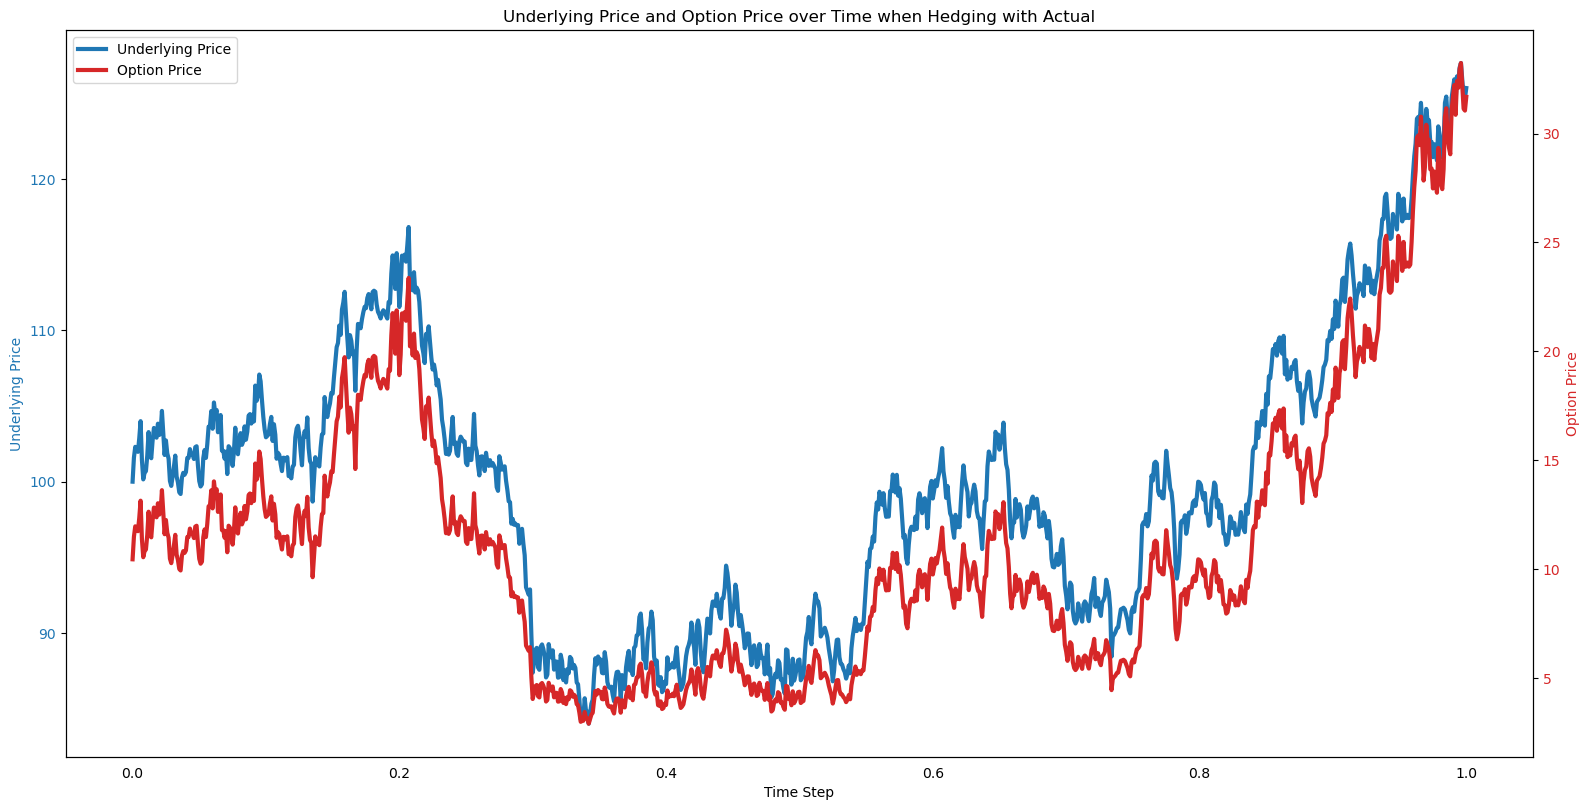

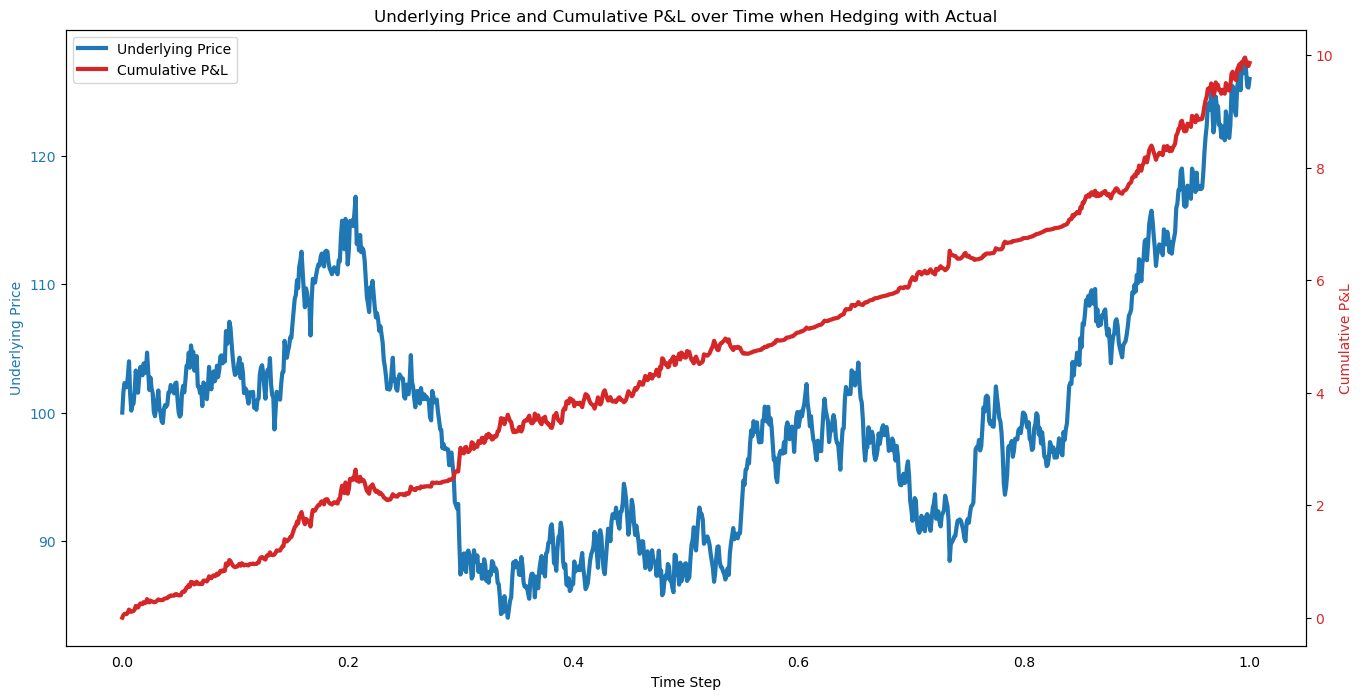

In [31]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Actual',implied_vol=0.2,actual_vol=0.3)
option_df = bs.option_sim_data_generator()
d = bs.delta_hedging_plots()
d


 Deltas DataFrame across 1 simulations, when hedging with Actual


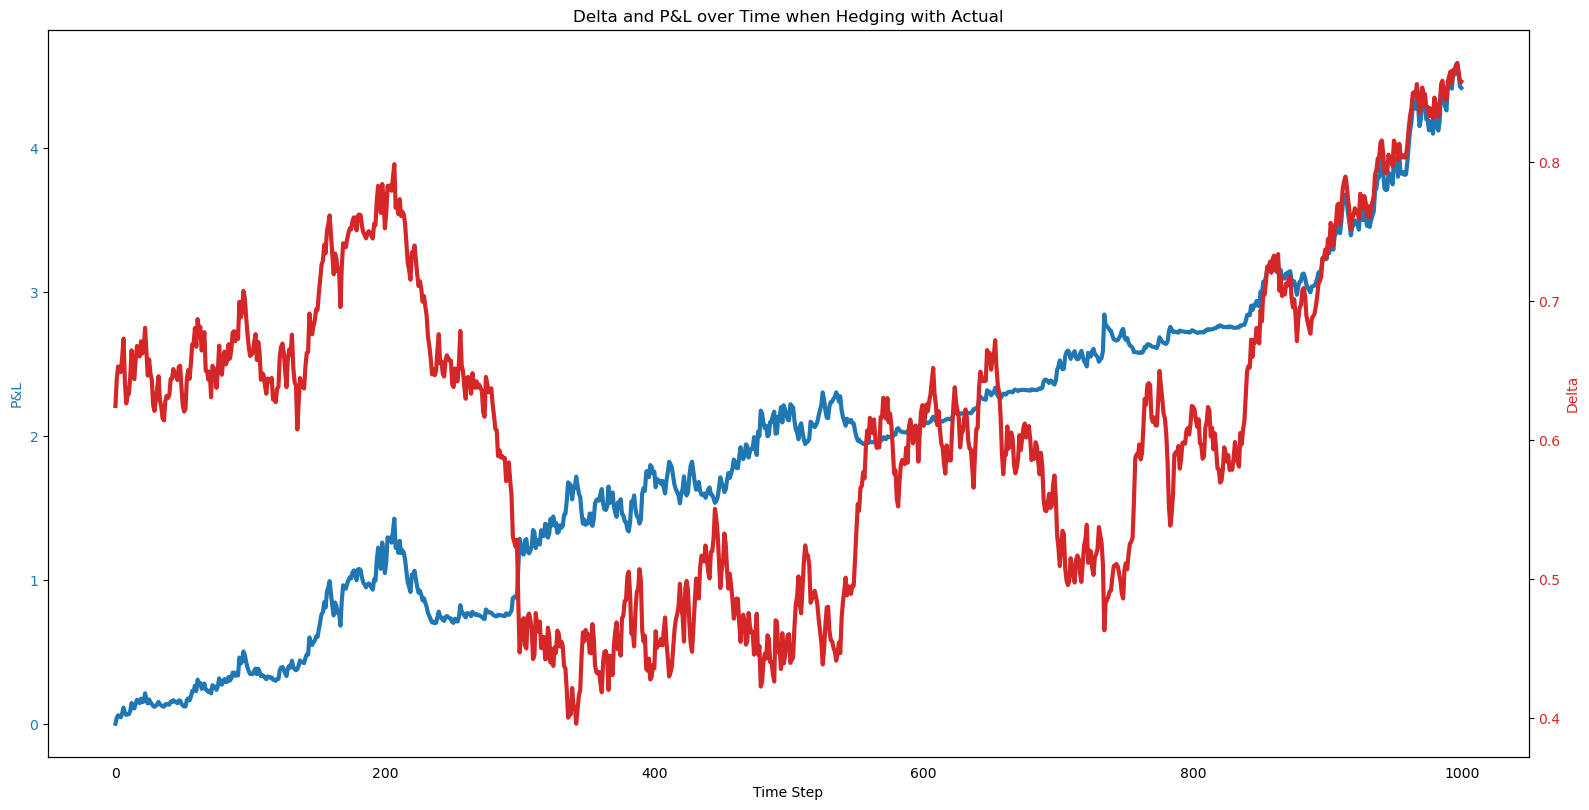

In [32]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',SDE_sim_type='Euler-Maruyama',pricing_method = 'Black Scholes',hedging_type='Actual',implied_vol=0.2,actual_vol=0.3)
deltapandlchart = bs.delta_pandl()

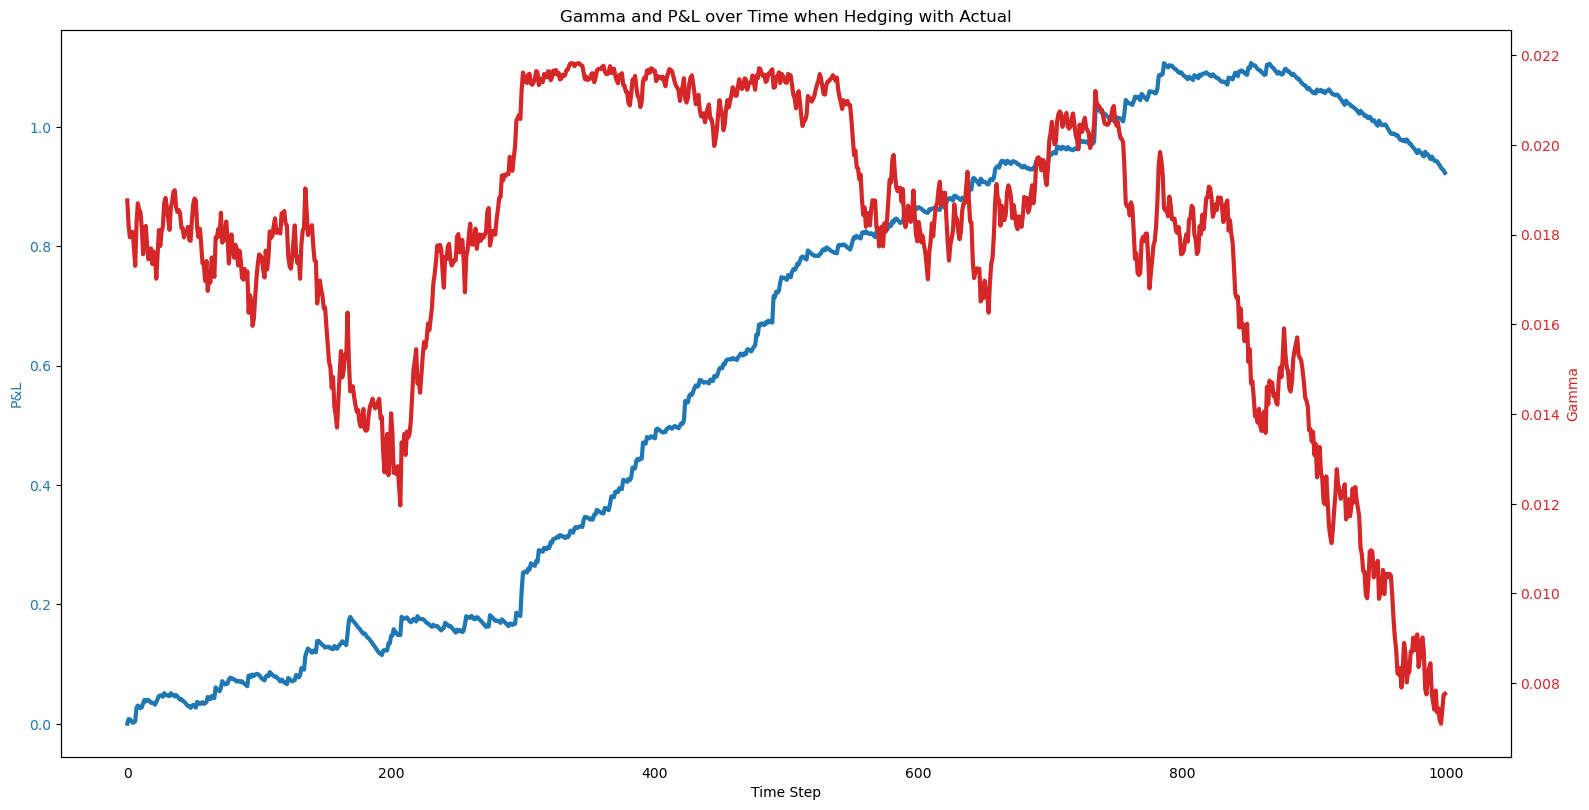

In [33]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',SDE_sim_type='Euler-Maruyama',pricing_method = 'Black Scholes', hedging_type='Actual',implied_vol=0.2,actual_vol=0.2)
gammapandlchart = bs.gamma_pandl()
gammapandlchart

#### Multiple Simulations and Results for Actual Volatility Hedging 

We are also interested in the statistical significance of the result, and visualize profit and losses distributions across a variety of simulations. That is the goal of this section, where I am presenting results across multiple simulations when hedging with actual volatility.

I will highlight the fact that when hedging with actual volatility, the distribution tends to have almost non-zero values which then translates into almost zero losses (again without taking into account of transaction costs). The median is also pretty close to the mean, which translates into a more centered distribution and therefore a safer option, compared to hedging with implied that will be treated later.

In [34]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Exact GBM',hedging_type='Actual',implied_vol=0.2,actual_vol=0.3)
mult_underlying_sim = pd.DataFrame(bs.multiple_MonteCarlo_simulator())
mult_underlying_sim

0          1          2          3          4          5   \
0     101.59504  100.70196   99.80899   99.85693  100.87283  101.10687   
1     101.67964  100.80174  100.46492  100.30424   99.34385  102.19531   
2     102.71807  102.83563  100.20648  100.60964   98.94344  103.16665   
3     103.62977  103.69594  100.34565   99.14973   98.76557  104.98198   
4     105.76313  102.76782  100.62048   99.01399   99.09442  104.60976   
...         ...        ...        ...        ...        ...        ...   
996    79.71595  118.58656   88.88263  105.50062  125.98799  137.36486   
997    79.83465  121.10362   88.59671  104.43625  126.99366  139.07936   
998    78.99271  122.15616   88.06570  105.86053  127.01126  137.88595   
999    79.50023  122.74011   88.30086  107.09970  126.34198  136.67306   
1000   79.88778  122.48707   87.69950  107.61512  127.74414  138.59640   

            6         7          8          9   ...         90         91  \
0     97.54512  98.75059  100.43734  100.09686  ...   99.56607  102.30132   
1     96.89543  97.23379  100.82093   99.95978  ...   99.39391  103.31639   
2     97.90247  94.20998  101.31540   99.02690  ...  100.16890  103.56911   
3     98.05850  93.88377  100.74627   97.48834  ...   97.55077  102.92652   
4     98.84851  94.55200   99.38109   96.68438  ...   97.47743  101.22269   
...        ...       ...        ...        ...  ...        ...        ...   
996   83.89824  81.74827  149.79363   74.35858  ...  131.63738   92.34624   
997   84.25797  82.40179  151.94670   74.45724  ...  131.09613   92.47130   
998   83.47499  82.05753  152.45153   75.53252  ...  131.39803   93.47405   
999   83.45302  82.46614  152.02263   75.41006  ...  131.71950   94.76349   
1000  82.06681  81.75975  151.27600   74.30768  ...  129.00663   94.28613   

             92         93         94         95         96         97  \
0      99.05208  100.30900  101.33647   99.57643   98.84243   98.95878   
1      98.96962  102.08124  102.40804   98.62198   97.87666  101.05030   
2      97.98188  101.25087  100.14809   98.34741   97.61982  101.43005   
3      98.28456   99.45170  100.04164   98.99581   96.51050  101.57306   
4      98.48400   98.35290  102.03291   97.37990   96.89432  102.20317   
...         ...        ...        ...        ...        ...        ...   
996   121.94736  102.67755   91.83593  227.36613  190.21929   88.12517   
997   123.28278  102.59644   92.32911  223.93408  190.14406   88.27574   
998   123.24144  103.20109   91.74249  222.71558  189.82948   87.43540   
999   122.41809  103.28714   89.84679  222.01965  191.78110   87.09343   
1000  121.82739  101.24278   90.25471  221.36103  192.60809   87.11426   

             98        99  
0      99.19887  99.48375  
1      98.24607  97.36127  
2      95.10945  94.69146  
3      95.73835  94.50763  
4      96.23321  94.56066  
...         ...       ...  
996   206.91527  75.09937  
997   204.33376  75.42883  
998   205.13278  75.45772  
999   202.59103  74.93602  
1000  204.42461  75.25705  

[1001 rows x 100 columns]

In [35]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',pricing_method = 'Black Scholes', hedging_type='Actual',implied_vol=0.2,actual_vol=0.3)
multiple_sim_delta = bs.multiple_sim_delta()
multiple_sim_delta

 Deltas DataFrame across 100 simulations, when hedging with Actual


0        1        2        3        4        5        6        7   \
0     0.64409  0.63307  0.62183  0.62244  0.63519  0.63809  0.59244  0.60825   
1     0.64512  0.63431   0.6301  0.62809   0.6159  0.65138  0.58377  0.58829   
2     0.65765  0.65905  0.62686  0.63191  0.61074  0.66297  0.59716  0.54691   
3     0.66841  0.66918  0.62861   0.6134  0.60844  0.68393  0.59921  0.54232   
4     0.69267  0.65824  0.63205  0.61166  0.61269  0.67971  0.60952  0.55169   
...       ...      ...      ...      ...      ...      ...      ...      ...   
996   0.33033   0.8119  0.46964  0.68975  0.86142  0.91542  0.39414  0.36126   
997   0.33213  0.83019  0.46537  0.67773  0.86719  0.92165  0.39964  0.37125   
998    0.3194  0.83738  0.45741  0.69375  0.86729  0.91736  0.38766  0.36599   
999   0.32706  0.84126  0.46094  0.70723  0.86348  0.91278  0.38733  0.37223   
1000  0.33293  0.83959  0.45191   0.7127  0.87136  0.91994  0.36613  0.36144   

           8        9   ...       90       91       92       93       94  \
0     0.62976  0.62548  ...  0.61874  0.65266  0.61215  0.62815  0.64092   
1     0.63455  0.62374  ...  0.61654  0.66473  0.61108     0.65  0.65394   
2     0.64066  0.61182  ...  0.62638   0.6677  0.59821  0.63987  0.62612   
3     0.63362  0.59168  ...  0.59251  0.66013  0.60218  0.61728  0.62478   
4     0.61637  0.58093  ...  0.59154  0.63952  0.60478  0.60307  0.64942   
...       ...      ...  ...      ...      ...      ...      ...      ...   
996   0.95191  0.25114  ...   0.8912  0.52044  0.83598  0.65717  0.51307   
997   0.95648  0.25255  ...  0.88862  0.52223   0.8448   0.6562  0.52019   
998   0.95749  0.26806  ...  0.89006  0.53654  0.84453  0.66338  0.51172   
999   0.95663  0.26628  ...  0.89159  0.55463  0.83913  0.66439  0.48396   
1000   0.9551  0.25041  ...  0.87812  0.54797  0.83517  0.63977  0.48998   

           95       96       97       98       99  
0     0.61887  0.60944  0.61094  0.61404  0.61769  
1     0.60658  0.59682  0.63739  0.60167  0.58999  
2       0.603  0.59343  0.64207  0.55943  0.55363  
3     0.61142  0.57858  0.64382  0.56808  0.55107  
4     0.59024  0.58375  0.65148  0.57483  0.55181  
...       ...      ...      ...      ...      ...  
996   0.99887  0.99305   0.4583  0.99693  0.26178  
997   0.99867  0.99303  0.46056  0.99652  0.26655  
998   0.99859  0.99292  0.44793  0.99665  0.26697  
999   0.99854  0.99356  0.44276  0.99621  0.25943  
1000  0.99849  0.99382  0.44308  0.99653  0.26406  

[1001 rows x 100 columns]

In [36]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',pricing_method = 'Black Scholes', hedging_type='Actual',implied_vol=0.2,actual_vol=0.3)
pandl = bs.multiple_pandlsim()
pandl

0        1        2        3        4        5        6        7   \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1    -0.00077 -0.00087  0.00893  0.00452 -0.00819  0.02886  0.00383  0.01285   
2     0.02939  0.06903  0.00294  0.00717 -0.01261  0.05895  0.00403  0.11979   
3     0.05942  0.09735  0.00244  0.00073  -0.0159  0.13908  0.00169  0.12725   
4     0.16401  0.07091  0.00455 -0.00263 -0.01579  0.12258  0.00552  0.11067   
...       ...      ...      ...      ...      ...      ...      ...      ...   
996   4.21737  1.89137  3.22586  0.35999  3.77284  2.28236  3.73702  3.62597   
997   4.20257   2.0973  3.24309  0.32145  3.84417  2.38105  3.70237  3.55946   
998   4.30298   2.1755  3.27929  0.38737  3.84136  2.31185   3.7801  3.59448   
999    4.2451  2.21612  3.26152  0.44989  3.79046  2.23953  3.78058  3.55188   
1000  4.20074  2.19373  3.30447  0.47383  3.89233  2.35344  3.93382  3.62774   

           8        9   ...       90       91       92       93       94  \
0         0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
1     0.00457 -0.00423  ... -0.00399   0.0325 -0.00302  0.05172  0.02955   
2     0.01281 -0.01009  ...  0.00597  0.03816 -0.00215  0.03459  0.01252   
3     0.00147  0.00042  ...  0.03324  0.01786 -0.00379  0.02571  0.00858   
4    -0.00714  0.00731  ...  0.03108 -0.00946 -0.00555  0.02465  0.06799   
...       ...      ...  ...      ...      ...      ...      ...      ...   
996    5.2592  4.60963  ...  2.01388  2.38449  4.20267  3.03006  3.09268   
997   5.34072  4.59652  ...  1.97429  2.37749  4.30366  3.02493  3.07174   
998    5.3544  4.47241  ...  1.99063  2.34723  4.29665  3.04182  3.09653   
999   5.33452  4.48626  ...  2.00817  2.32194  4.23391  3.04159  3.21675   
1000  5.30306   4.6285  ...  1.83738  2.33262  4.18731  3.01111  3.19303   

           95       96       97       98       99  
0         0.0      0.0      0.0      0.0      0.0  
1    -0.00337  0.00141  0.05159 -0.00102  0.02113  
2    -0.00622 -0.00016   0.0574  0.09058  0.10297  
3    -0.00323  0.01268   0.0579   0.0799  0.10527  
4     0.00951   0.0079  0.07251  0.07243  0.10177  
...       ...      ...      ...      ...      ...  
996   2.63657  4.32077  3.18927  2.25575  4.37079  
997   2.62785  4.31535  3.17711  2.24309  4.33022  
998   2.62136  4.30831  3.24024  2.24101  4.32553  
999   2.61551  4.31689  3.26488  2.22778  4.39001  
1000  2.60968  4.31718   3.2614  2.22982  4.35041  

[1001 rows x 100 columns]

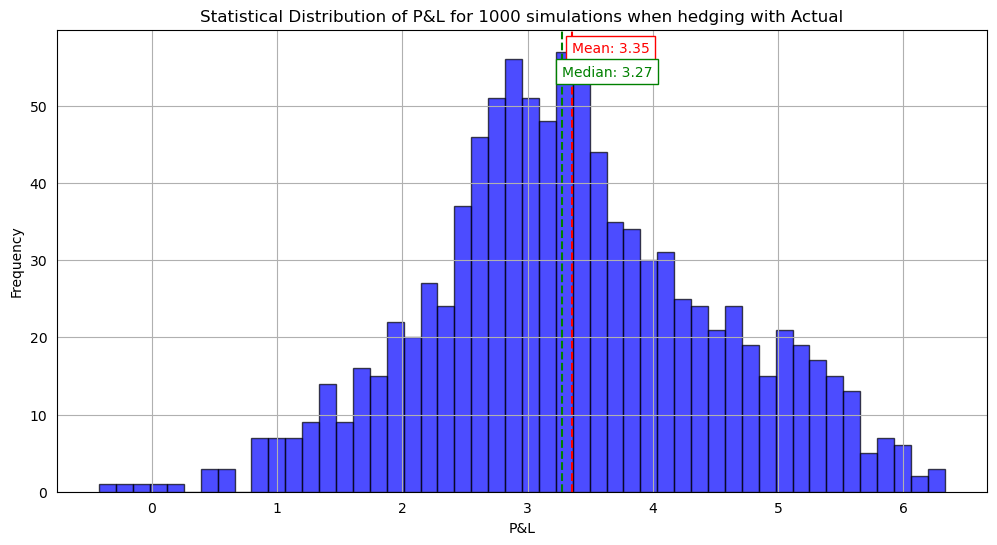

In [37]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1000, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Actual',implied_vol=0.2,actual_vol=0.3)
stat_dist = bs.pandl_distribution()

### Hedging with Implied Volatility

In this instance, we are therefore interested in profiting from implied volatility, so we believe the market is correct (i.e. it is a Sell Side business). We will touch upon the convexity of payoffs from Gamma, as the change in P&L gains curvature and loses from time decay, as:

$
P\&L = \frac{1}{2} \Gamma \Delta S^2
$

The convexity of payoffs applies even when hedged:

$\displaystyle{V(S+\Delta S,t+ \Delta t) = V(S,t)+ \frac{\partial V}{\partial t} + \frac{\partial V}{\partial S} \Delta S + \frac{1}{2}\frac{\partial ^2 V}{\partial S^2} \Delta S^2}$


$\displaystyle{d(V-\Delta S) = \frac{1}{2}\Gamma S^2 \sigma ^2 \Delta t +\Theta \Delta t}$

where:

- the gain from the curvature is $\frac{1}{2}\Gamma (\Delta S)^2$

- time decay is $\Theta \Delta t$ 

and so the below ratio is proportional to variance:

$ \frac{(\Delta S)^2}{S} = r^2 ≈ \sigma ^2 \Delta t$


#### Mark to Market Mathematical Profits:

Consider P&L from a hedged position in an option, where an option price has already been decomposed into Greeks as follows:

\begin{equation}
P\&L_{\Delta t, \Delta S} = \Delta (\Delta S) + \frac{1}{2} \Gamma (\Delta S)^2 + \Theta \Delta t - \Delta (\Delta S)
\end{equation}

Take into consideration of the Theta defined in a Black-Scholes sense:

$\Theta_{i} = -\frac{1}{2} \sigma _i ^2 S^2 \Gamma _i$

By substituting this into the previous equation, we obtain:

\begin{equation}
P\&L_{\Delta t, \Delta S} = \frac{1}{2} \Gamma (\Delta S)^2 + -\frac{1}{2} \sigma _i ^2 S^2 \Gamma _i \Delta t 
\end{equation}

\begin{equation}
= \displaystyle{\frac{1}{2} \Gamma S^2[(\frac{\Delta S}{S})^2 - \sigma _i ^2 \Delta t]}
\end{equation}

So the total profit and loss when hedging wth implied volatility is:

\begin{equation}
\frac{1}{2}(\sigma _a ^2 - \sigma _i ^2)\int_{t_{0}}^T e^{-r(t-t_0)}S_t ^2 \Gamma _i dt
\end{equation}


We will analyse that using implied volatility $sigma _i as a prediction, while the asset evolves according to its own volatility \sigma _a, then our P&L result is not certain.  

In [38]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Exact GBM',hedging_type='Implied',implied_vol=0.2,actual_vol=0.3)
option_df = bs.option_sim_data_generator()
option_df



Time Step  Underlying Price  Option Price    Delta  Elasticity    Charm  \
0         0.000         101.59504      11.48986  0.66608     5.88960  0.10427   
1         0.001         102.30871      11.96975  0.67872     5.80120  0.11754   
2         0.002         102.11379      11.83779  0.67530     5.82517  0.11389   
3         0.003         101.96821      11.73967  0.67273     5.84316  0.11117   
4         0.004         102.85874      12.34570  0.68826     5.73429  0.12797   
...         ...               ...           ...      ...         ...      ...   
996       0.996         126.77638      32.39393  0.93776     3.67002  0.64060   
997       0.997         125.61529      31.30845  0.93192     3.73905  0.61622   
998       0.998         125.51846      31.21823  0.93142     3.74492  0.61417   
999       0.999         126.19302      31.84770  0.93489     3.70439  0.62838   
1000      1.000         127.87058      33.42285  0.94286     3.60723  0.66335   

        Vanna    Gamma    Zomma    Speed    Color  Replicating Cashflow  \
0    -0.72586  0.01791 -0.08073 -0.00055  0.01704               0.00000   
1    -0.85261  0.01751 -0.07680 -0.00057  0.01624               1.29290   
2    -0.81769  0.01762 -0.07789 -0.00056  0.01646              -0.34953   
3    -0.79175  0.01770 -0.07869 -0.00056  0.01662              -0.26212   
4    -0.95236  0.01719 -0.07368 -0.00058  0.01560               1.59802   
...       ...      ...      ...      ...      ...                   ...   
996  -5.95997  0.00483  0.02545 -0.00033 -0.00485              -0.64087   
997  -5.71894  0.00523  0.02414 -0.00035 -0.00457              -0.73372   
998  -5.69874  0.00527  0.02401 -0.00035 -0.00454              -0.06379   
999  -5.83915  0.00503  0.02483 -0.00034 -0.00471               0.43815   
1000 -6.18505  0.00448  0.02641 -0.00031 -0.00506               1.01947   

      Cash Account  Portfolio  Cumulative P&L     Interest   Delta %  \
0         56.18086  -56.18086         0.00000  0.00000e+00  66.60829   
1         57.47656  -57.46923         0.00734  3.66785e-07  67.87202   
2         57.12991  -57.11937         0.01054  5.27146e-07  67.52972   
3         56.87065  -56.85706         0.01359  6.79327e-07  67.27266   
4         58.47151  -58.44813         0.02338  1.16908e-06  68.82627   
...            ...        ...             ...          ...       ...   
996       97.21917  -86.49243        10.72674  5.36350e-04  93.77643   
997       96.49031  -85.75537        10.73495  5.36761e-04  93.19233   
998       96.43135  -85.69156        10.73980  5.37003e-04  93.14151   
999       96.87432  -86.12852        10.74580  5.37303e-04  93.48871   
1000      97.89863  -87.14117        10.75746  5.37886e-04  94.28598   

      Total Delta Position Contract Adjustments  
0                      NaN       Long nan Stock  
1                     -1.3       Long 1.3 Stock  
2                      0.3      Short 0.3 Stock  
3                      0.3      Short 0.3 Stock  
4                     -1.6       Long 1.6 Stock  
...                    ...                  ...  
996                    0.5      Short 0.5 Stock  
997                    0.6      Short 0.6 Stock  
998                    0.1      Short 0.1 Stock  
999                   -0.3       Long 0.3 Stock  
1000                  -0.8       Long 0.8 Stock  

[1001 rows x 19 columns]

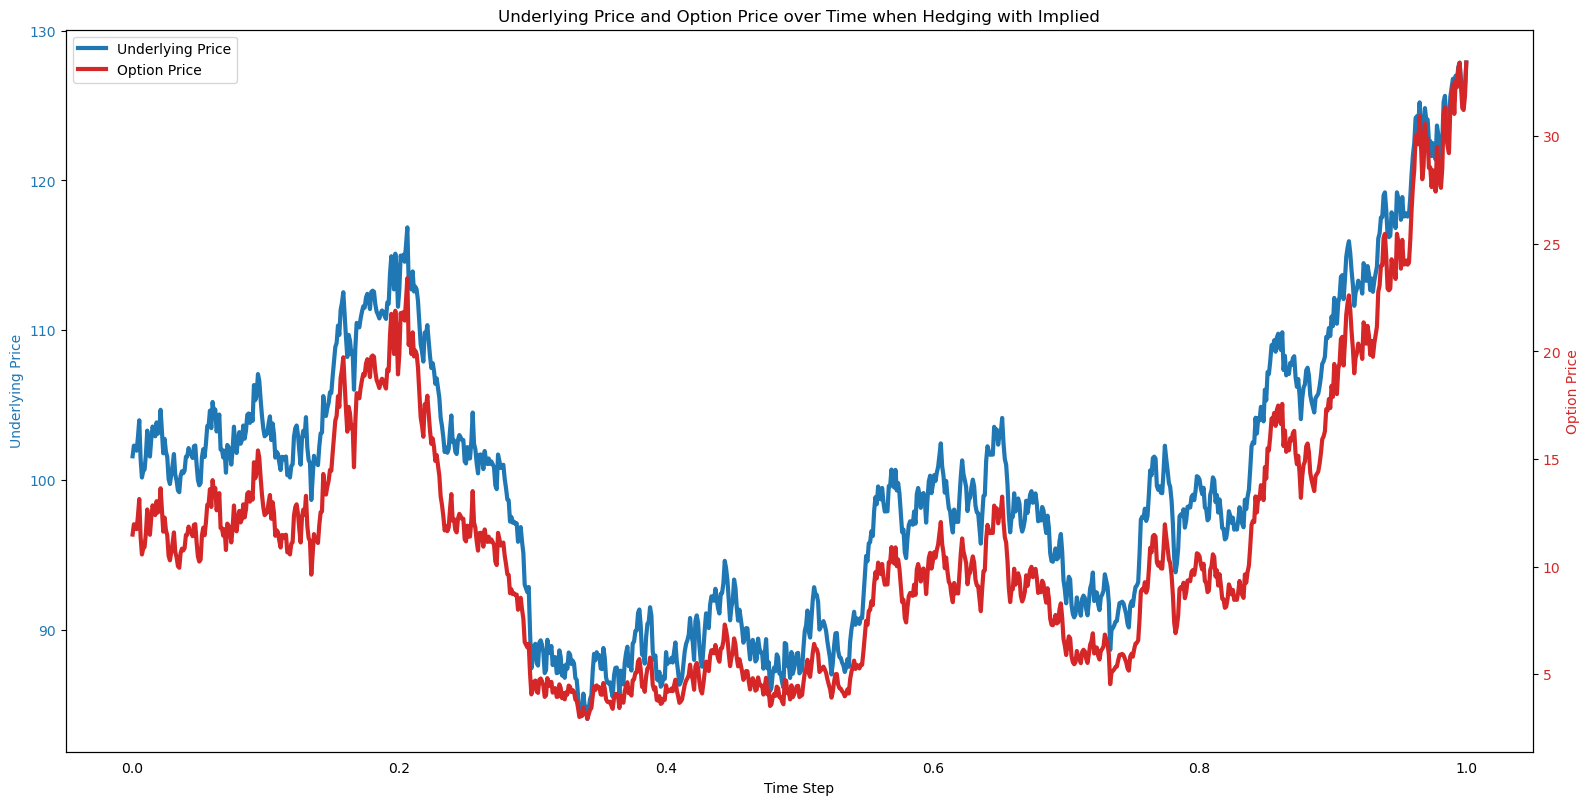

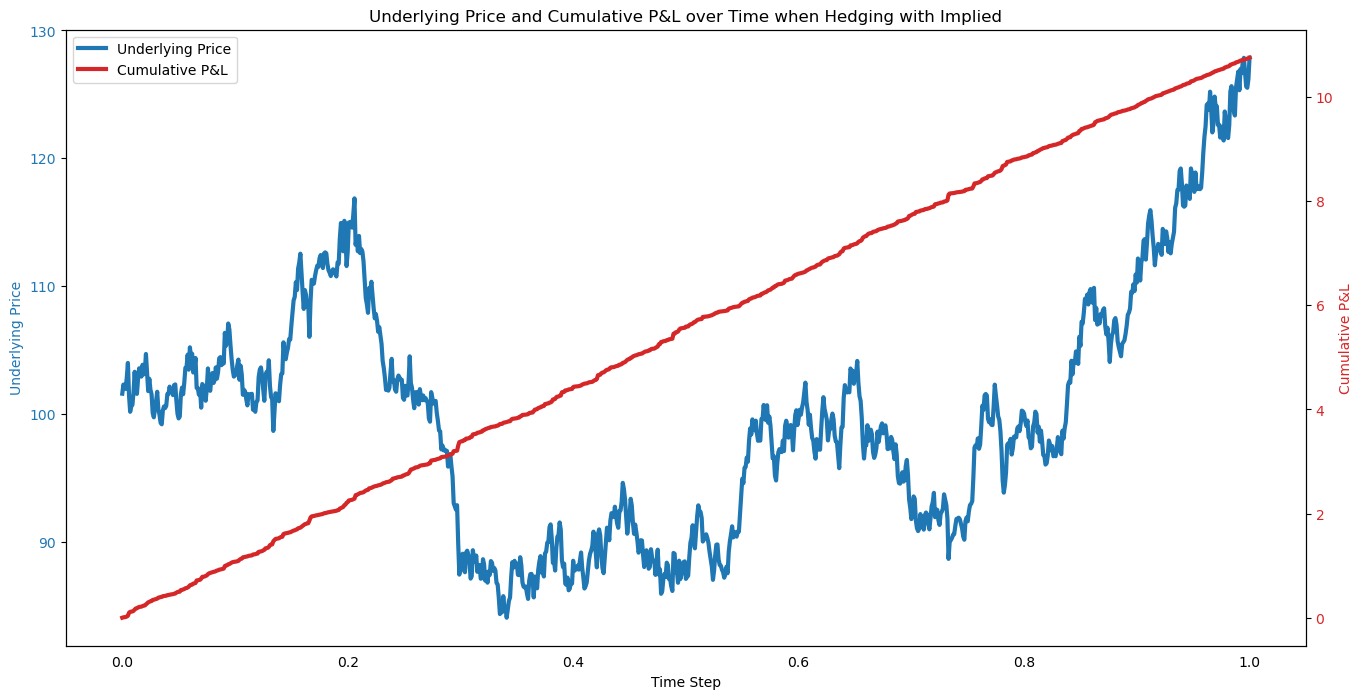

In [39]:
i = bs.delta_hedging_plots()
i

 Deltas DataFrame across 1 simulations, when hedging with Implied


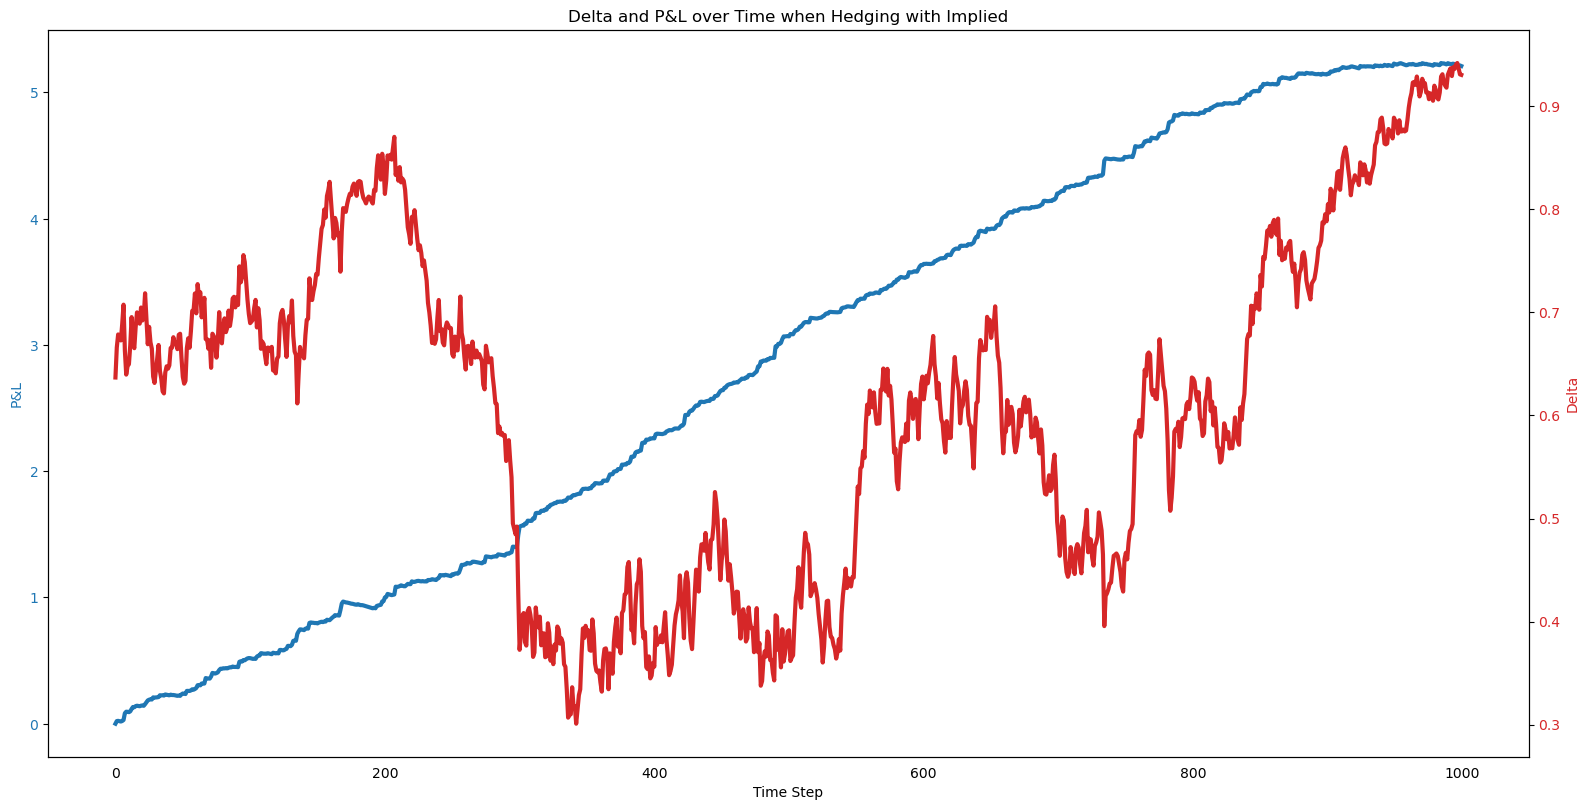

In [40]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',SDE_sim_type='Euler-Maruyama',pricing_method = 'Black Scholes',hedging_type='Implied',implied_vol=0.2,actual_vol=0.3)
deltapandlchart = bs.delta_pandl()

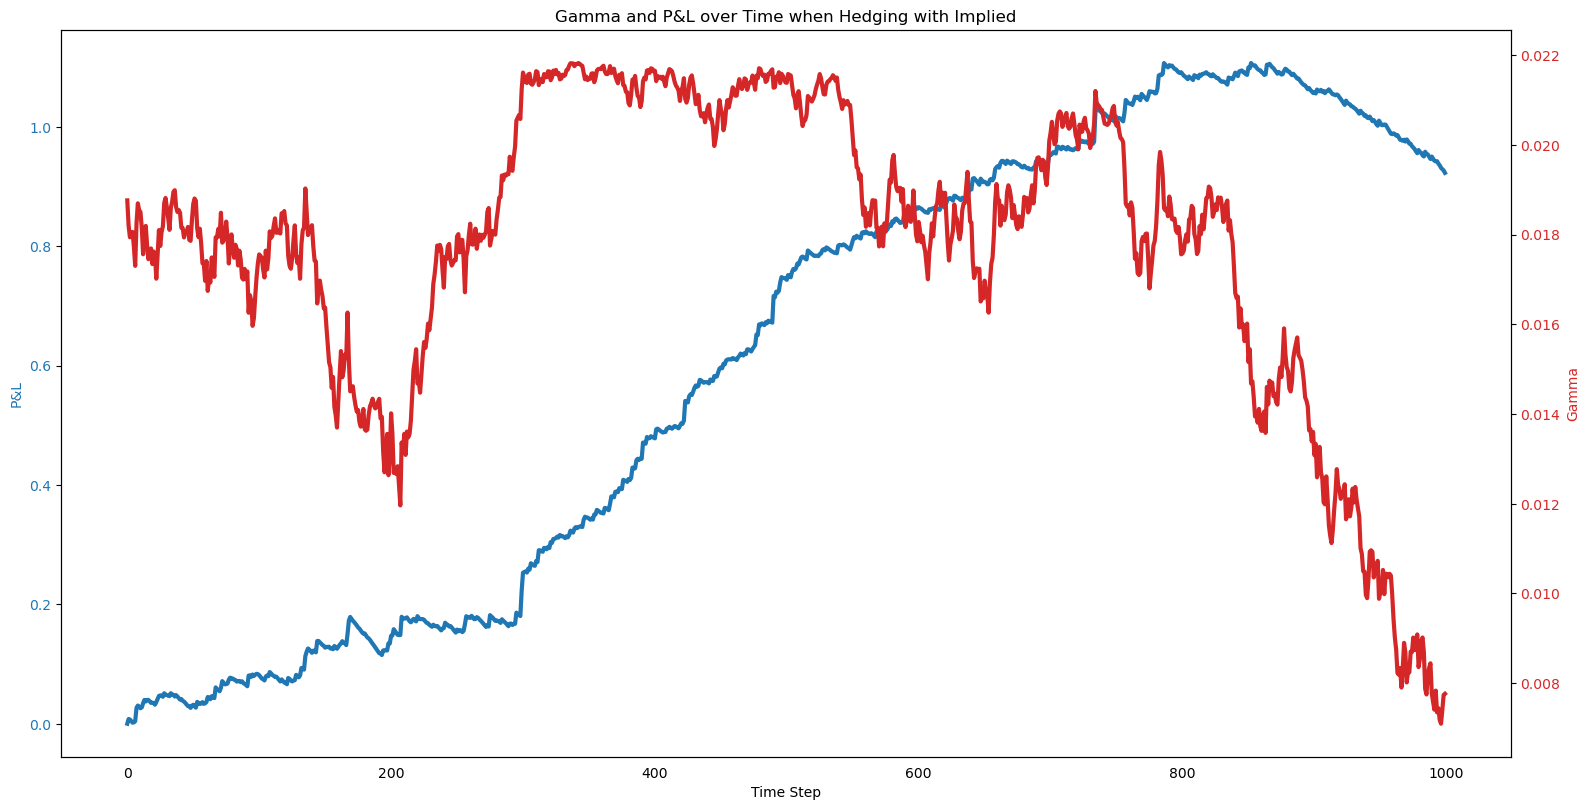

In [41]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',SDE_sim_type='Euler-Maruyama',pricing_method = 'Black Scholes', hedging_type='Implied',implied_vol=0.2,actual_vol=0.2)
gammapandlchart = bs.gamma_pandl()
gammapandlchart

## Multiple Simulations across Implied Volatility Hedging

We are also interested in the statistical significance of the result, and visualize profit and losses distributions across a variety of simulations. That is the goal of this section, where I am presenting results across multiple simulations when hedging with implied volatility.

I will highlight the fact that when hedging with implied volatility, the distribution tends to have longer tails compared to hedging with Actual and more extreme values around the negatives, which then makes this approach less safe than hedging with actual. This translates into potential higher  losses (again without taking into account of transaction costs). The median is not so close to the mean, which translates into a less centered distribution. However, the profits can also reach higher values, so there is more variability and less predictability in the hedging strategy.

Therefore, there is more uncertainty.

In [42]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',pricing_method = 'Black Scholes', hedging_type='Implied',implied_vol=0.2,actual_vol=0.3)
multiple_sim_delta = bs.multiple_sim_delta()
multiple_sim_delta

 Deltas DataFrame across 100 simulations, when hedging with Implied


0        1        2        3        4        5        6        7   \
0     0.66608  0.64987  0.63324  0.63414  0.65301  0.65728  0.58929    0.613   
1      0.6676   0.6517   0.6455  0.64251  0.62441  0.67673  0.57625  0.58306   
2     0.68584  0.68787  0.64069  0.64817  0.61673  0.69353  0.59639  0.52065   
3     0.70134  0.70245  0.64328  0.62069  0.61329  0.72344  0.59947  0.51374   
4      0.7357   0.6867  0.64837  0.61808  0.61963  0.71747  0.61489  0.52786   
...       ...      ...      ...      ...      ...      ...      ...      ...   
996   0.21667  0.88539  0.40545  0.73162  0.93385  0.97365  0.29881  0.25539   
997   0.21886  0.90446  0.39922  0.71465  0.93881  0.97722  0.30628  0.26835   
998   0.20353   0.9116  0.38766  0.73721  0.93889  0.97478  0.29009  0.26149   
999   0.21271  0.91536  0.39277  0.75583  0.93563  0.97207  0.28964  0.26964   
1000  0.21984  0.91374   0.3797   0.7633  0.94229  0.97626  0.26168  0.25561   

           8        9   ...       90       91       92       93       94  \
0     0.64499  0.63865  ...  0.62864  0.67859  0.61882   0.6426  0.66143   
1     0.65206  0.63608  ...  0.62537  0.69607  0.61723  0.67472  0.68046   
2     0.66105  0.61833  ...  0.63999  0.70033  0.59796  0.65989   0.6396   
3     0.65069  0.58816  ...   0.5894  0.68943  0.60391  0.62647  0.63761   
4     0.62512  0.57198  ...  0.58794  0.65938  0.60781  0.60525  0.67387   
...       ...      ...  ...      ...      ...      ...      ...      ...   
996   0.99112  0.12895  ...  0.95768  0.48081  0.91022  0.68514  0.46978   
997   0.99269  0.13035  ...  0.95579   0.4835  0.91873  0.68373  0.48044   
998   0.99302  0.14616  ...  0.95686  0.50501  0.91847  0.69411  0.46775   
999   0.99274  0.14431  ...  0.95796  0.53231   0.9133  0.69557  0.42649   
1000  0.99223  0.12823  ...  0.94776  0.52226  0.90942  0.65974  0.43539   

           95       96       97       98       99  
0     0.62884  0.61477  0.61702  0.62164  0.62708  
1      0.6105  0.59588  0.65625  0.60316  0.58562  
2     0.60514  0.59078  0.66312  0.53955  0.53079  
3     0.61773  0.56844  0.66569   0.5526  0.52693  
4     0.58599  0.57623  0.67687  0.56278  0.52805  
...       ...      ...      ...      ...      ...  
996       1.0  0.99982  0.38895  0.99997  0.13967  
997   0.99999  0.99982  0.39223  0.99996  0.14459  
998   0.99999  0.99981  0.37397  0.99996  0.14503  
999   0.99999  0.99984  0.36657  0.99995  0.13727  
1000  0.99999  0.99986  0.36702  0.99996  0.14202  

[1001 rows x 100 columns]

In [43]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',pricing_method = 'Black Scholes', hedging_type='Implied',implied_vol=0.2,actual_vol=0.3)
pandl = bs.multiple_pandlsim()
pandl

0        1        2        3        4        5        6        7   \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1    -0.00274 -0.00264  0.00139 -0.00077  0.01896  0.00788   0.0018  0.02003   
2     0.00396  0.03179  -0.0007  -0.0026   0.0179  0.01322  0.00961  0.11117   
3     0.00816  0.03518  -0.0032  0.01461  0.01564  0.03772  0.00739   0.1102   
4      0.0423  0.03945 -0.00519   0.0122  0.01414  0.03572  0.01103  0.11285   
...       ...      ...      ...      ...      ...      ...      ...      ...   
996   5.16146  1.06758  5.06534 -0.21695  3.75255 -0.76993  5.00891  3.70266   
997   5.16055  1.08814  5.06441 -0.21112  3.75058 -0.77132  5.00889  3.70576   
998     5.166  1.08776  5.06568 -0.19796  3.74606 -0.77444  5.01385  3.70578   
999   5.16734  1.08465  5.06454 -0.18949  3.74263 -0.77735  5.01253   3.7063   
1000   5.1677  1.08061  5.06671 -0.19083  3.74287 -0.77773  5.03069  3.71009   

           8        9   ...       90       91       92       93       94  \
0         0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
1    -0.00134 -0.00249  ... -0.00234  0.00605 -0.00251  0.02602  0.00746   
2    -0.00185  0.00309  ...  0.00074  0.00362  0.00441   0.0293  0.05022   
3    -0.00169  0.02359  ...  0.06357  0.00413  0.00284  0.05633  0.04765   
4     0.01292  0.02766  ...  0.06119  0.02657  0.00073  0.06533  0.08143   
...       ...      ...  ...      ...      ...      ...      ...      ...   
996   4.03717   4.4984  ... -0.05087  3.47024  5.05531  5.58848  4.73373   
997   4.03403  4.49781  ... -0.05481  3.46832  5.05667  5.58535  4.73427   
998   4.02922  4.50556  ... -0.05908  3.47703  5.05222  5.58532  4.73584   
999   4.02438  4.50495  ... -0.06335  3.49248  5.04987  5.58215  4.77282   
1000  4.01967  4.51319  ... -0.05441  3.49255  5.04659  5.61514  4.77273   

           95       96       97       98       99  
0         0.0      0.0      0.0      0.0      0.0  
1     0.00609  0.00654  0.03885  0.00618  0.04101  
2      0.0043  0.00473   0.0374  0.10242   0.1112  
3     0.00589  0.01464  0.03479  0.10434   0.1094  
4      0.0288  0.01381  0.03551  0.10461   0.1073  
...       ...      ...      ...      ...      ...  
996  -0.92927  1.13902   4.5708 -1.69597  3.58839  
997  -0.93398  1.13421  4.56932 -1.70063  3.58854  
998  -0.93869   1.1294  4.57525  -1.7053  3.58787  
999   -0.9434  1.12463  4.57486 -1.70995  3.58923  
1000 -0.94811  1.11982  4.57324 -1.71461  3.58935  

[1001 rows x 100 columns]

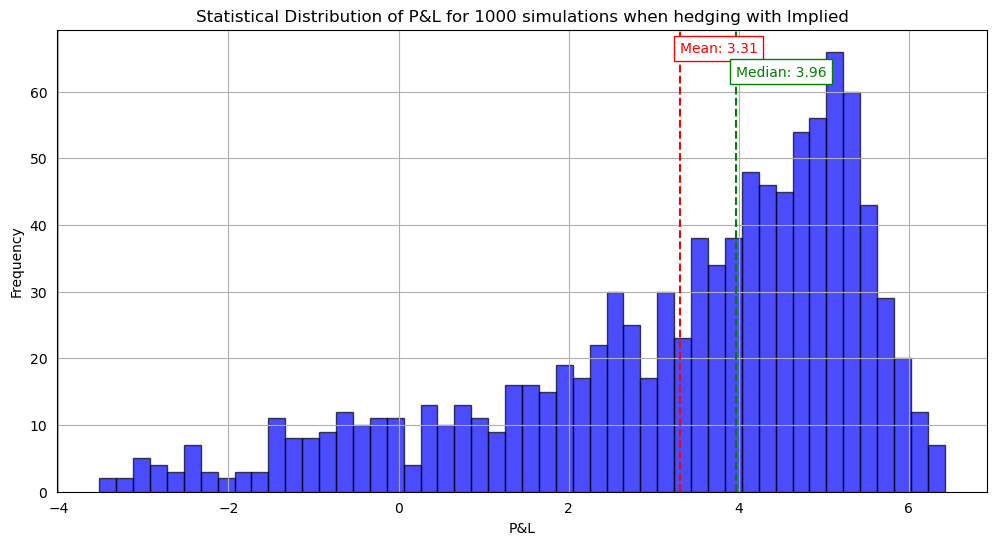

In [44]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1000, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Implied',implied_vol=0.2,actual_vol=0.3)
stat_dist = bs.pandl_distribution()

### Delta Hedging

Recalling the Black-Scholes derivation argument, here we do not have a view on the volatility, however equating implied and actual, we do agree on a single view of volatility, and therefore apply the standard hedging argument.

In [45]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Delta-Hedging',implied_vol=0.2,actual_vol=0.3)
option_df = bs.option_sim_data_generator()
option_df



Time Step  Underlying Price  Option Price    Delta  Elasticity    Charm  \
0         0.000         100.00000      10.45058  0.63683     6.09373  0.07572   
1         0.001         101.58745      11.48481  0.66595     5.89055  0.10413   
2         0.002         102.30314      11.96598  0.67862     5.80189  0.11744   
3         0.003         102.11266      11.83703  0.67528     5.82531  0.11387   
4         0.004         101.97157      11.74193  0.67279     5.84274  0.11123   
...         ...               ...           ...      ...         ...      ...   
996       0.996         127.67676      33.24019  0.94199     3.61820  0.65934   
997       0.997         126.59426      32.22322  0.93688     3.68068  0.63679   
998       0.998         125.43519      31.14069  0.93098     3.74998  0.61241   
999       0.999         125.34411      31.05592  0.93049     3.75554  0.61049   
1000      1.000         126.02156      31.68749  0.93402     3.71461  0.62478   

        Vanna    Gamma    Zomma    Speed    Color  Replicating Cashflow  \
0    -0.45433  0.01876 -0.08889 -0.00052  0.01872               0.00000   
1    -0.72453  0.01791 -0.08077 -0.00055  0.01705               2.95786   
2    -0.85161  0.01751 -0.07683 -0.00057  0.01624               1.29676   
3    -0.81749  0.01762 -0.07790 -0.00056  0.01646              -0.34162   
4    -0.79235  0.01770 -0.07868 -0.00056  0.01662              -0.25403   
...       ...      ...      ...      ...      ...                   ...   
996  -6.14533  0.00454  0.02626 -0.00032 -0.00502               0.17677   
997  -5.92231  0.00490  0.02527 -0.00033 -0.00481              -0.64648   
998  -5.68136  0.00529  0.02390 -0.00036 -0.00452              -0.74043   
999  -5.66234  0.00533  0.02378 -0.00036 -0.00449              -0.06063   
1000 -5.80353  0.00509  0.02463 -0.00034 -0.00467               0.44459   

      Cash Account  Portfolio  Cumulative P&L     Interest   Delta %  \
0         53.23248  -53.23248         0.00000  0.00000e+00  63.68307   
1         56.19300  -56.16705         0.02595  1.29757e-06  66.59471   
2         57.49258  -57.45926         0.03331  1.66572e-06  67.86227   
3         57.15383  -57.11732         0.03651  1.82538e-06  67.52772   
4         56.90266  -56.86312         0.03954  1.97705e-06  67.27860   
...            ...        ...             ...          ...       ...   
996       97.76009  -87.02941        10.73068  5.36547e-04  94.19850   
997       97.11849  -86.38020        10.73830  5.36928e-04  93.68783   
998       96.38292  -85.63639        10.74653  5.37340e-04  93.09755   
999       96.32711  -85.57574        10.75137  5.37582e-04  93.04917   
1000      96.77651  -86.01912        10.75739  5.37883e-04  93.40196   

      Total Delta Position Contract Adjustments  
0                      NaN       Long nan Stock  
1                     -2.9       Long 2.9 Stock  
2                     -1.3       Long 1.3 Stock  
3                      0.3      Short 0.3 Stock  
4                      0.2      Short 0.2 Stock  
...                    ...                  ...  
996                   -0.1       Long 0.1 Stock  
997                    0.5      Short 0.5 Stock  
998                    0.6      Short 0.6 Stock  
999                    0.0       Long 0.0 Stock  
1000                  -0.4       Long 0.4 Stock  

[1001 rows x 19 columns]

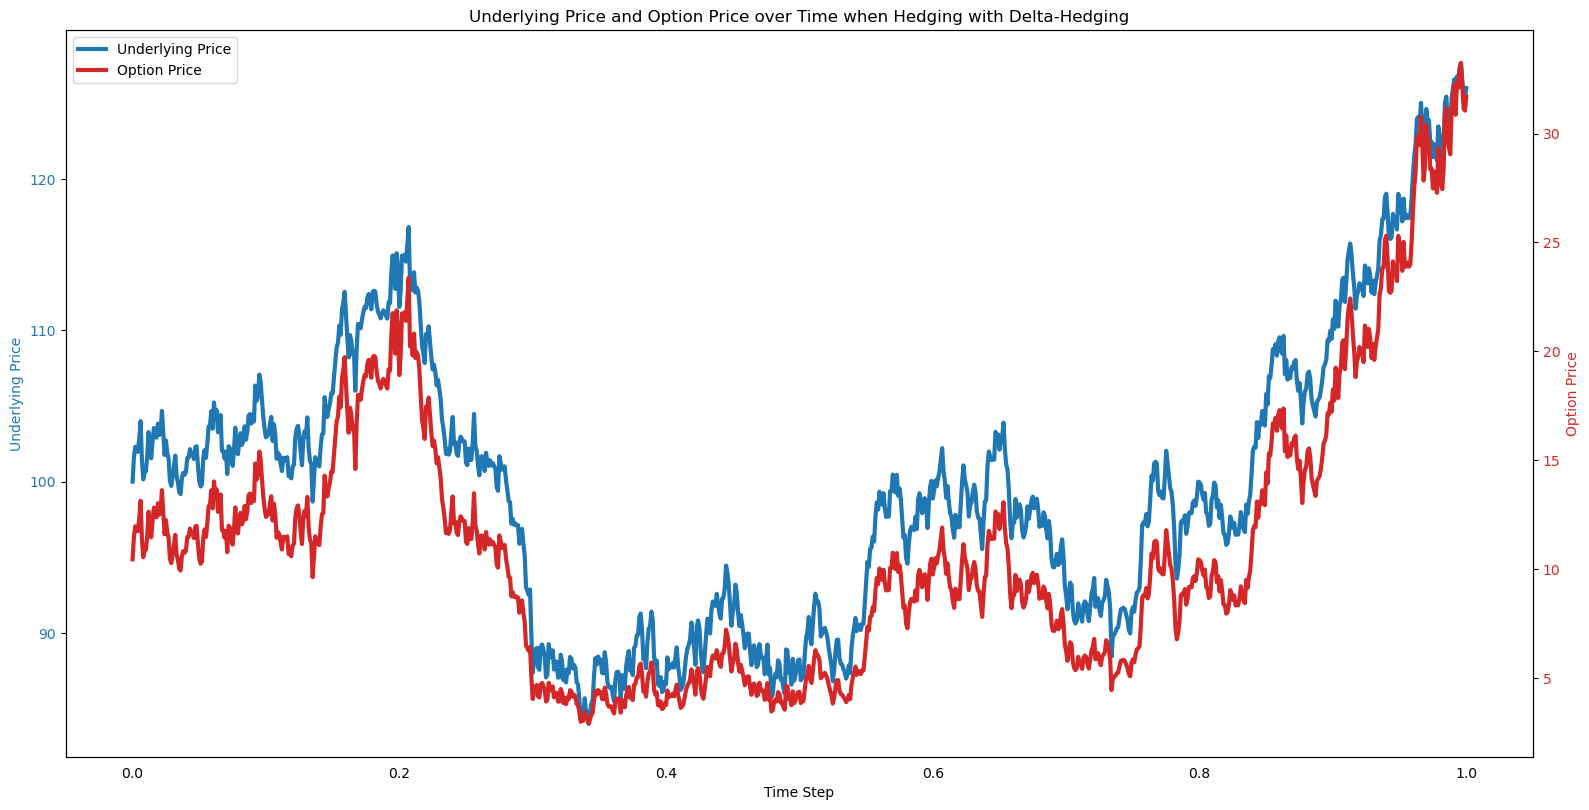

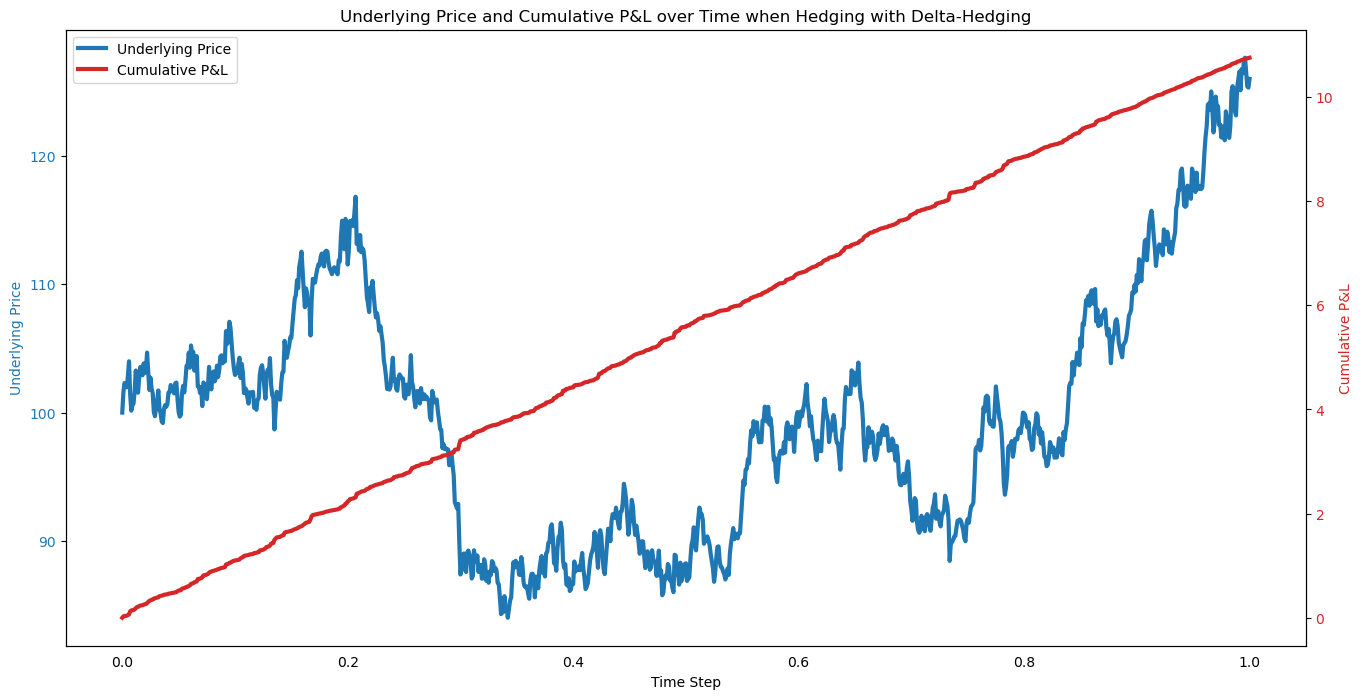

In [46]:
d = bs.delta_hedging_plots()
d

 Deltas DataFrame across 1 simulations, when hedging with Delta-Hedging


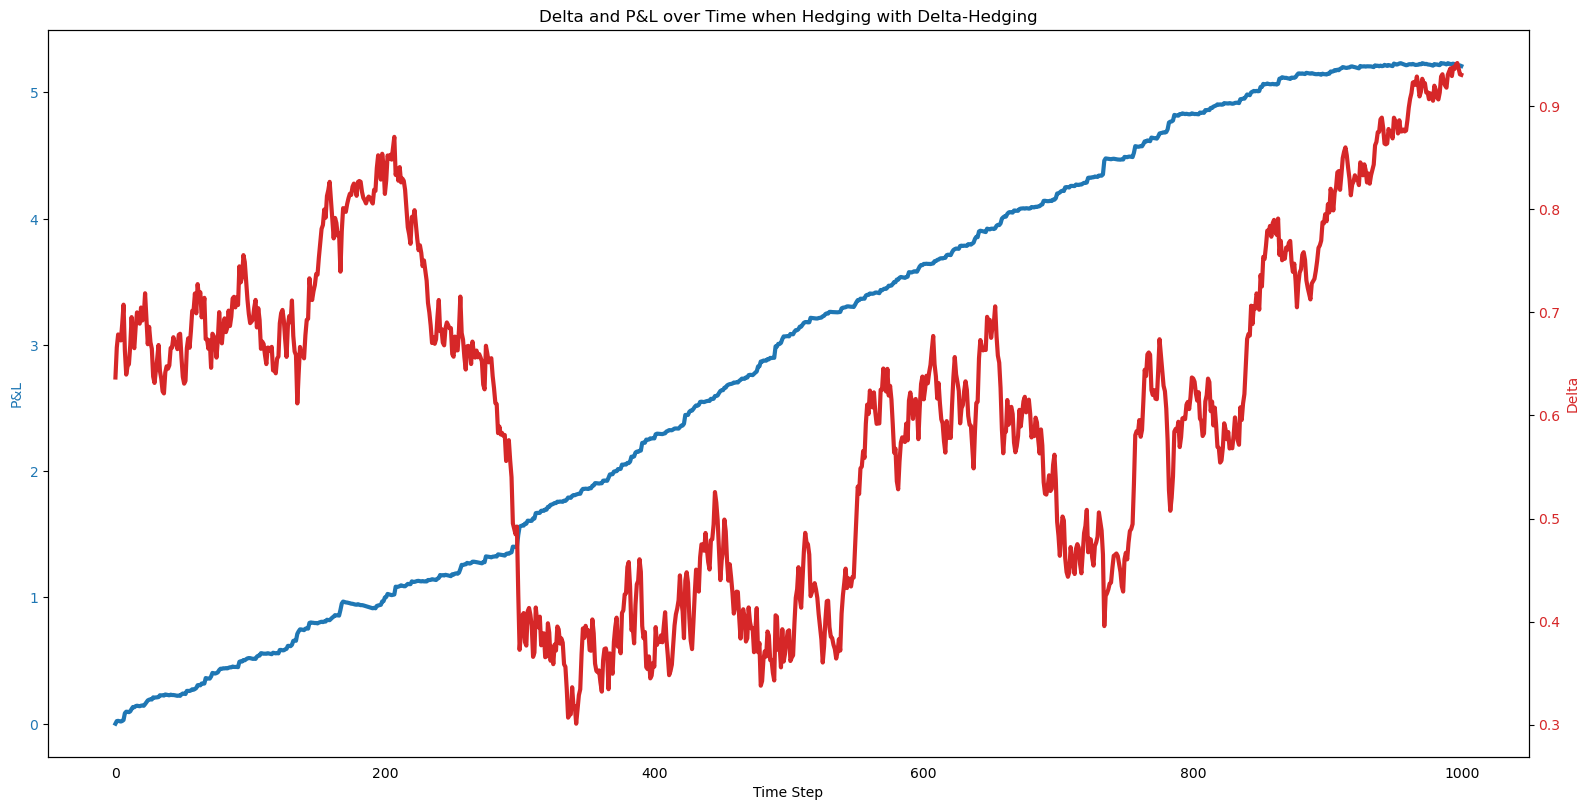

In [47]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',SDE_sim_type='Euler-Maruyama',pricing_method = 'Black Scholes',hedging_type='Delta-Hedging',implied_vol=0.2,actual_vol=0.3)
deltapandlchart = bs.delta_pandl()

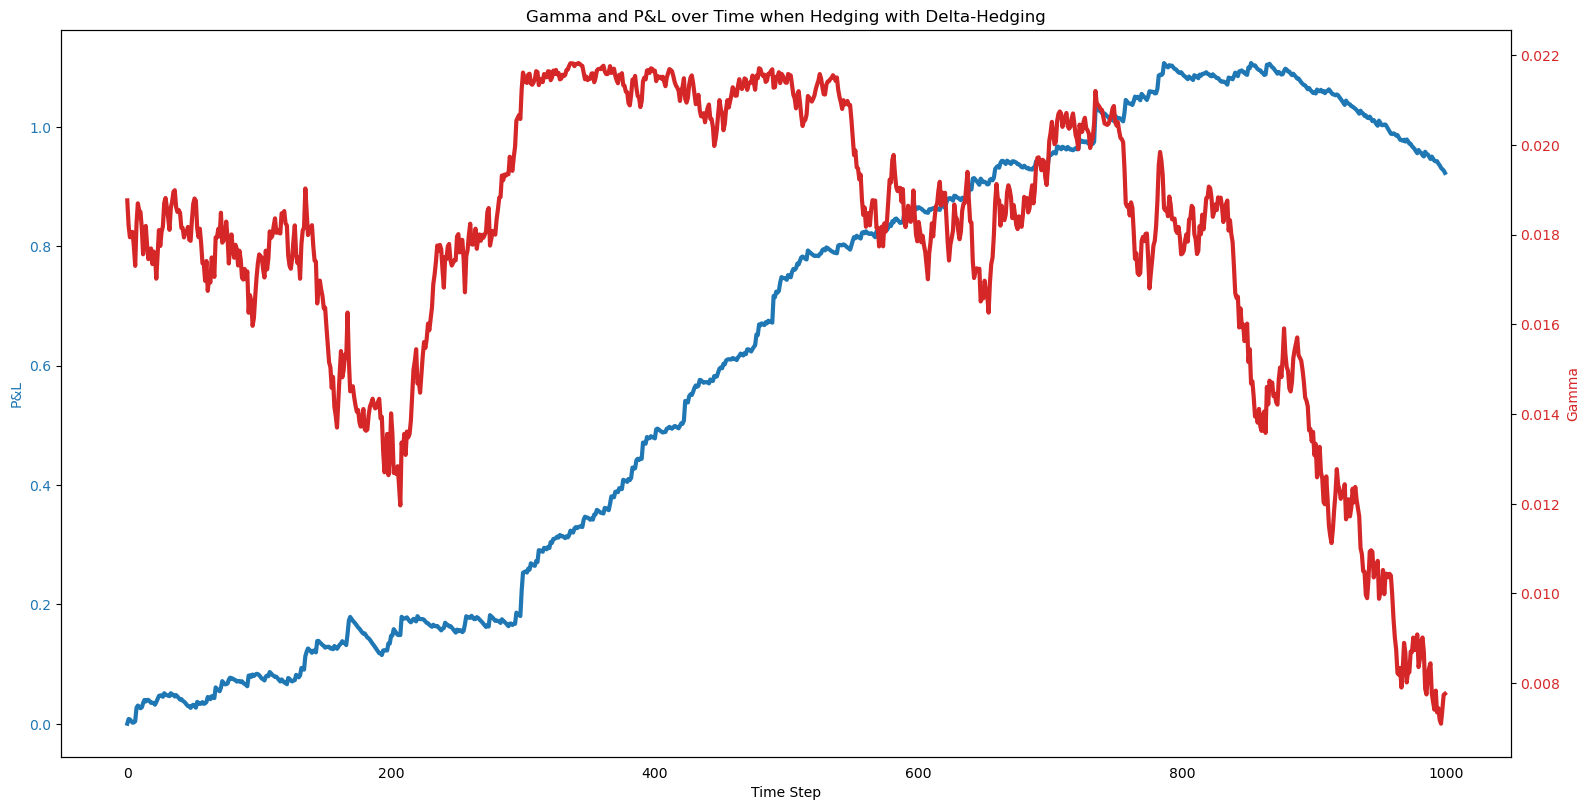

In [48]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',SDE_sim_type='Euler-Maruyama',pricing_method = 'Black Scholes', hedging_type='Delta-Hedging',implied_vol=0.2,actual_vol=0.2)
gammapandlchart = bs.gamma_pandl()
gammapandlchart

### Multiple Simulations across Delta Hedging


We are also interested in the statistical significance of the result, and visualize profit and losses distributions across a variety of simulations. That is the goal of this section, where I am presenting results across multiple simulations when performing delta hedging.

The results are less glamorous than the first two, as this is technically a neutral strategy, not seeking to maximise profits at the market expense or to condition your view based on implied. The distribution indeed is less impactful in terms of profits.

In [49]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Exact GBM',implied_vol=0.2,actual_vol=0.2)
mult_underlying_sim = pd.DataFrame(bs.multiple_MonteCarlo_simulator())
mult_underlying_sim

0          1          2          3          4          5   \
0    100.00000  100.00000  100.00000  100.00000  100.00000  100.00000   
1    101.05997  100.47134   99.87754   99.90955  100.58436  100.73886   
2    101.12076  100.54236  100.31835  100.21191   99.56487  101.46268   
3    101.81047  101.88603  100.15077  100.41969   99.30144  102.10730   
4    102.41499  102.45666  100.24811   99.44583   99.18696  103.29944   
..         ...        ...        ...        ...        ...        ...   
995   88.33195  116.54211   95.33639  105.34833  120.36486  126.47692   
996   88.49591  116.36467   95.01219  106.66532  119.72242  126.26955   
997   88.27873  115.09749   94.99464  106.57425  119.76869  126.89870   
998   88.37042  116.71449   94.79503  105.85878  120.40910  127.95400   
999   87.74994  117.39328   94.41954  106.81967  120.42584  127.22485   

            6          7          8          9   ...         90         91  \
0    100.00000  100.00000  100.00000  100.00000  ...  100.00000  100.00000   
1     98.34799   99.16681  100.29592  100.06954  ...   99.71508  101.52183   
2     97.91443   98.14810  100.55548   99.98279  ...   99.60469  102.19481   
3     98.59392   96.08554  100.88815   99.36247  ...  100.12509  102.36603   
4     98.70319   95.86784  100.51397   98.32984  ...   98.36190  101.94607   
..         ...        ...        ...        ...  ...        ...        ...   
995   90.19401   88.06959  132.59048   83.47029  ...  123.08444   96.50920   
996   90.45521   88.86621  132.99695   84.07898  ...  122.90113   97.32631   
997   91.29655   89.73179  134.40625   84.23678  ...  123.24091   97.21306   
998   91.56122   90.21230  135.69129   84.31517  ...  122.90815   97.30530   
999   90.99561   89.96473  135.99767   85.12507  ...  123.10237   98.00951   

            92         93         94         95         96         97  \
0    100.00000  100.00000  100.00000  100.00000  100.00000  100.00000   
1     99.37004  100.21068  100.89008   99.72202   99.22879   99.30722   
2     99.31950  101.38539  101.60228   99.08637   98.58387  100.69653   
3     98.66000  100.83806  100.09551   98.90683   98.41578  100.95303   
4     98.86747   99.63748  100.02921   99.34475   97.67053  101.05257   
..         ...        ...        ...        ...        ...        ...   
995  117.51759  102.80584   97.01831  179.03939  155.10685   93.11941   
996  116.72927  103.54686   97.04837  177.39324  154.97657   93.31972   
997  117.02888  104.60794   96.90167  177.58964  157.58824   94.43733   
998  117.88407  104.55771   97.25219  175.79718  157.55404   94.54922   
999  117.86321  104.97219   96.84348  175.16593  157.38747   93.95071   

            98         99  
0    100.00000  100.00000  
1     99.46876   99.65994  
2     98.83340   98.23176  
3     96.70012   96.41548  
4     97.12951   96.29507  
..         ...        ...  
995  167.97283   85.93002  
996  167.45537   85.48539  
997  166.57284   84.80403  
998  165.18644   85.05547  
999  165.62393   85.08115  

[1000 rows x 100 columns]

In [50]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 100, number_shares = 1, option_type='Call',SDE_sim_type='Exact GBM',pricing_method = 'Black Scholes', hedging_type='Delta-Hedging',implied_vol=0.2,actual_vol=0.2)
multiple_sim_delta = bs.multiple_sim_delta()
multiple_sim_delta

 Deltas DataFrame across 100 simulations, when hedging with Delta-Hedging


0        1        2        3        4        5        6        7   \
0     0.65643  0.64554  0.63444  0.63504  0.64764  0.65051  0.60532  0.62099   
1      0.6575  0.64682  0.64267  0.64067  0.62862  0.66368  0.59677  0.60127   
2     0.66991  0.67129  0.63951   0.6445  0.62357  0.67515  0.61011  0.56019   
3     0.68055  0.68131  0.64129  0.62625  0.62134  0.69584   0.6122  0.55568   
4     0.70447  0.67059  0.64474  0.62457   0.6256  0.69173  0.62245  0.56506   
...       ...      ...      ...      ...      ...      ...      ...      ...   
996   0.39248  0.85338  0.53584  0.74579  0.89487  0.93835  0.45921  0.42507   
997   0.39444   0.8689  0.53162  0.73487  0.89964  0.94323  0.46493  0.43554   
998   0.38095  0.87496   0.5237   0.7495  0.89974   0.9399  0.45263  0.43011   
999   0.38916  0.87823  0.52729  0.76172  0.89663  0.93632  0.45234  0.43667   
1000  0.39544  0.87686  0.51827  0.76668  0.90312  0.94195  0.43036  0.42546   

           8        9   ...       90       91       92       93       94  \
0     0.64227  0.63804  ...  0.63138  0.66489  0.62485  0.64068   0.6533   
1     0.64706  0.63638  ...  0.62925  0.67684  0.62385  0.66232   0.6662   
2     0.65315  0.62463  ...  0.63904  0.67981  0.61115  0.65236  0.63878   
3     0.64624  0.60473  ...  0.60555   0.6724  0.61513  0.63008   0.6375   
4     0.62924  0.59411  ...  0.60464  0.65212  0.61776  0.61607  0.66189   
...       ...      ...  ...      ...      ...      ...      ...      ...   
996   0.96636  0.30686  ...   0.9191  0.58604  0.87373  0.71596  0.57883   
997   0.96977  0.30846  ...  0.91705  0.58785  0.88113  0.71511  0.58586   
998   0.97053  0.32553  ...  0.91823  0.60184  0.88093  0.72177  0.57761   
999    0.9699  0.32363  ...  0.91947   0.6194  0.87645  0.72274  0.55026   
1000  0.96878  0.30625  ...  0.90862  0.61303  0.87316  0.70004  0.55628   

           95       96       97       98       99  
0     0.63151  0.62217  0.62366  0.62672  0.63034  
1     0.61939  0.60972  0.64987  0.61453  0.60295  
2      0.6159  0.60641  0.65454  0.57265  0.56688  
3     0.62429  0.59173  0.65632   0.5813  0.56439  
4     0.60335  0.59691  0.66392  0.58806  0.56518  
...       ...      ...      ...      ...      ...  
996   0.99936  0.99568  0.52449  0.99817  0.31856  
997   0.99924  0.99567  0.52681  0.99791  0.32383  
998   0.99919   0.9956  0.51416    0.998  0.32434  
999   0.99916  0.99602    0.509  0.99772  0.31612  
1000  0.99913  0.99619  0.50937  0.99793  0.32125  

[1001 rows x 100 columns]

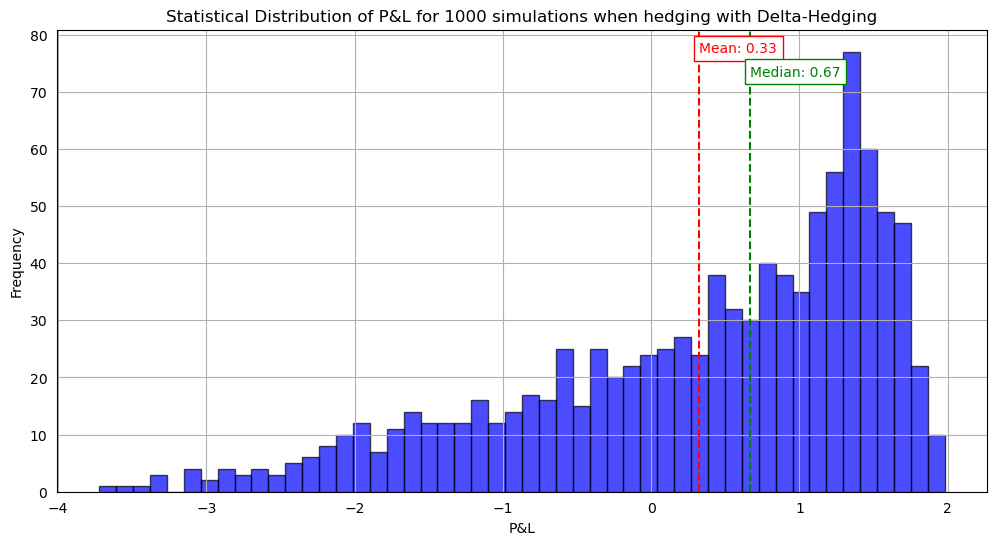

In [51]:
bs = BlackScholes(spot=100, strike=100, r=0.05, T=1, timesteps = 1000, nsim= 1000, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Delta-Hedging',implied_vol=0.2,actual_vol=0.2)
stat_dist = bs.pandl_distribution()

### Simulated Greeks over Time


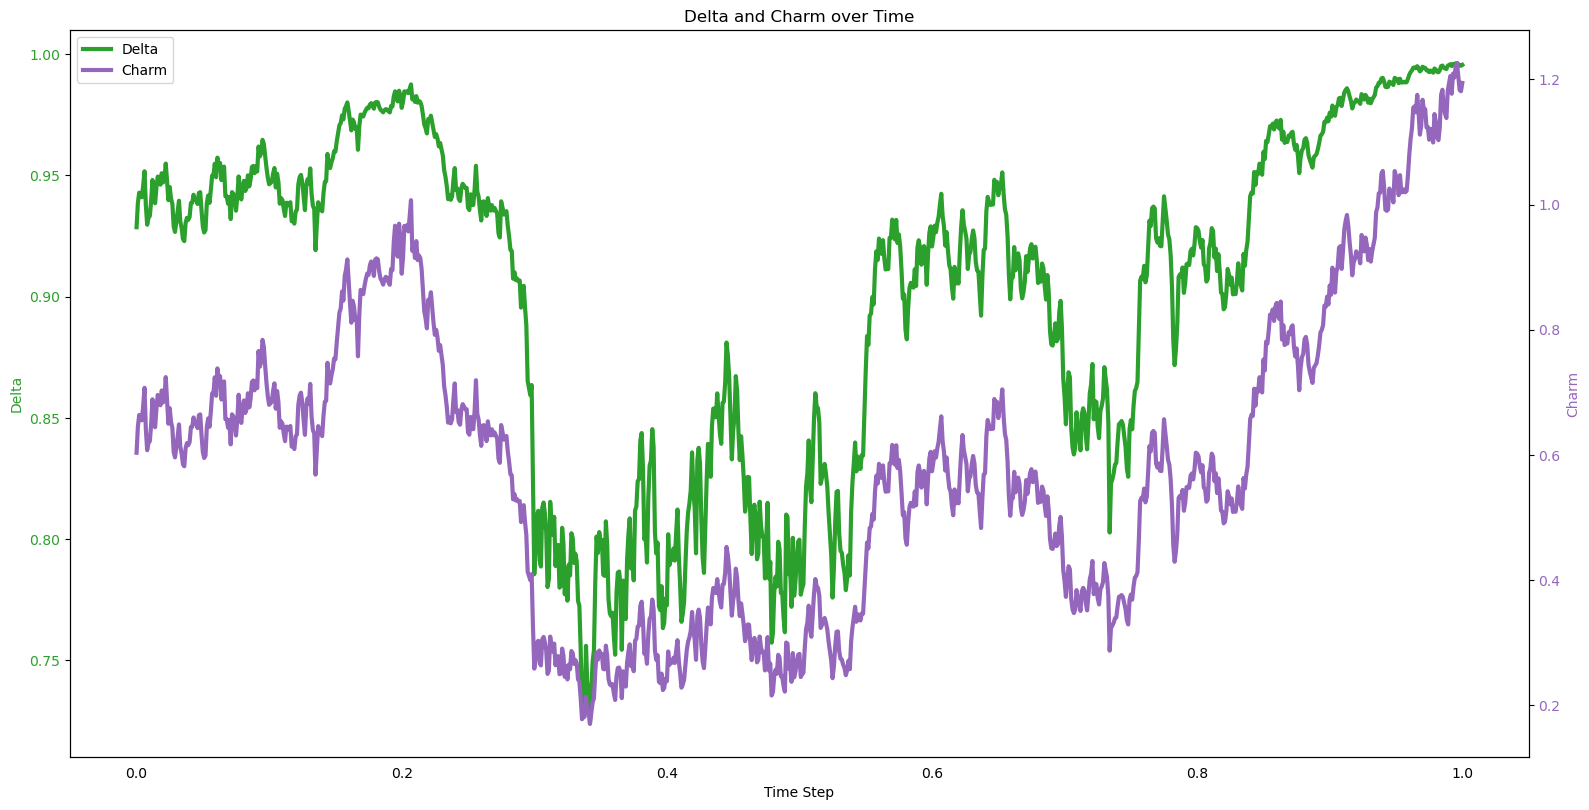

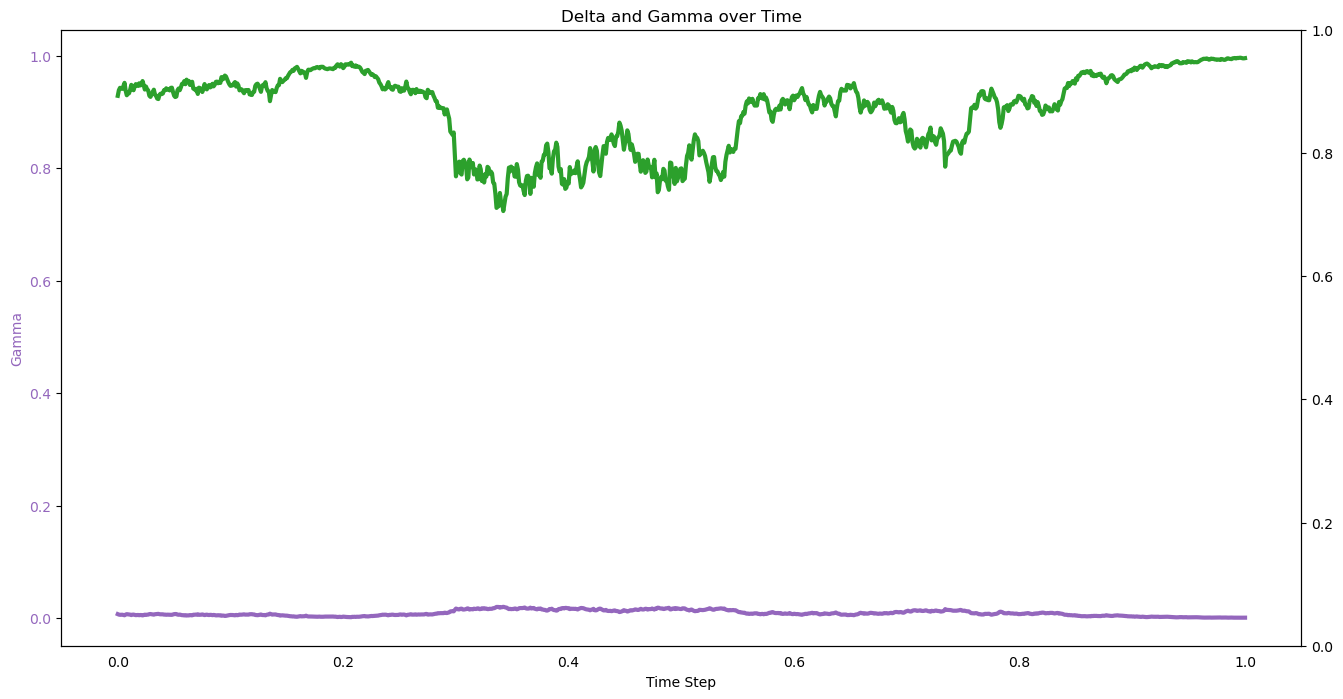

In [52]:
bs = BlackScholes(spot=100, strike=80, r=0.05, T=1, timesteps = 1000, nsim= 1, number_shares = 1, option_type='Call',pricing_method = 'Black Scholes', SDE_sim_type='Euler-Maruyama',hedging_type='Delta-Hedging',implied_vol=0.2,actual_vol=0.3)
option_df = bs.option_sim_data_generator()
g = bs.greeks_plot_generator()
g



## 1.6 A Panoramic View on Merton Jump Diffusion Process


Empirically, we have observed that stock returns tend to have fat tails, inconsistent with the Black-Scholes model’s assumptions. Therefore in 1976, Merton developed the Jump Diffusion model to address significant random jumps that occur in stock prices. Stock prices tend to follow a log-normal random walk, however unprecedented events can shock their dynamics causing a jump. This is the fat tailed, where returns of a greater magnitude occur with a higher probability that the one predicted by the Gaussian density. 

The goal of this section is to enlighten about the Merton Jump Diffusion and propose an alternative solution to continuous-time delta hedging with the established Black-Scholes assumptions for the underlying path, and to take into account of unpredictable jumps that belong to the innermost nature of stock prices. 

### Counting Process

A counting process is a random process that represents the total number of occurrences that have taken place in the interval $[0; t]$ : $q (t)$ is an integer value quantity with $q (0) = 0$

A counting process $N(t)$ is called a Poisson process with non-negative intensity (or mean arrival rate) ${\displaystyle \lambda}$ of an event in a time interval dt if $N(0)=0$.

The number of jumps in a finite time horizon t has a Poisson distribution with parameter ${\displaystyle \lambda t}$

### Poisson Process 

A Poisson process, also called Poisson point process is a type of random mathematical object that consists of points randomly located on a mathematical space with the essential feature that the points occur independently of one another.

A Poisson point process is characterized via the Poisson distribution

The Poisson distribution is the probability distribution of a random variable

${\displaystyle \mathbb{P}\{N=n\}={\frac {\lambda ^{n}}{n!}}e^{-\lambda }}$

⁠

### Compound Poisson Process

A compound Poisson process is a continuous-time stochastic process with jumps occurring at random times, arriving randomly according to a Poisson process and the size of the jumps is also random, with a specified probability distribution. In the Merton Jump Diffusion process, the jumps are modelled as Normal, with a mean and a standard deviation of jumps.

In general, a compound Poisson process, parameterised by a rate ${\displaystyle \lambda >0}$ and jump size distribution $G$, is a process ${\displaystyle \{\,X(t):t\geq 0\,\}}$ given by:
\begin{equation}
Y(t)=\sum _{i=1}^{N(t)}D_{i}
\end{equation}

where, ${\displaystyle \{\,N(t):t\geq 0\,\}}$ is the counting variable of a Poisson process with rate  ${\displaystyle \lambda}$ and ${\displaystyle \{\,D_{i}:i\geq 1\,\}}$ are independent and identically distributed random variables, with distribution function G, which are also independent of 
${\displaystyle \{\,N(t):t\geq 0\,\}.\,}$


### Model Derivation for Merton Jump Diffusion

In MJD model, changes in the asset price consist of normal (continuous diffusion) component that is modeled by a Brownian motion with drift process and abnormal (discontinuous, i.e. jump) component that is modeled by a compound Poisson process. Asset price jumps are assumed to occur independently and identically. The probability that an asset price jumps during a small time interval

$\mathbb{P}\left(\text{an asset price jumps once in } dt\right) = \mathbb{P}\left(\Delta N = 1 \text{ in } dt\right) \approx \lambda dt$


### Merton Jump Diffusion Process

The Merton Jump Diffusion model superimposes a jump component on a diffusion component. The standard Jump-Diffusion SDE will be given by:

\begin{equation}
dS = a(S,t)dt + b(S,t)dW +c(S,t)dq
\end{equation}

where $A(S,t)$ is the drift term, $b(S,t)$ is the diffusion and $c(S,t)$ is the jump term.



In [55]:
class Merton_Jump:
    """This class will produce the underlying path according to the Merton Jump Diffusion Model, 
    and the relative Option Pricing Engine, equipped with the calculation of the Greeks
    """
    
    def __init__(self, T, mean_jumps, std_jumps, lambd, vol, timesteps, Npaths, spot, strike, r, option_type, hedging_type, implied_vol, actual_vol=None):
        # Compound Poisson Process Settings
        self.T = T
        self.mean_jumps = mean_jumps
        self.std_jumps = std_jumps
        self.lambd = lambd
        
        # Merton Jump Diffusion Settings
        self.Npaths = int(Npaths)  # Ensure this is an integer
        self.spot = spot
        self.strike = strike
        self.r = r
        self.ts = int(timesteps)  # Ensure this is an integer
        self.vol = vol
        self.option_type = option_type
        self.hedging_type = hedging_type
        self.implied_vol = implied_vol
        self.actual_vol = actual_vol if actual_vol is not None else vol

        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
    
    # Generate Merton Jump Path
    def merton_jump_path_generator(self):
        size = (self.ts, self.Npaths)
        dt = self.T / self.ts 
        
        poisson_rv = np.multiply(np.random.poisson(self.lambd * dt, size=size),
                                 np.random.normal(self.mean_jumps, self.std_jumps, size=size)).cumsum(axis=0)
        gbm_term = np.cumsum(((self.r - self.vol**2 / 2 - self.lambd * (self.mean_jumps + self.std_jumps**2 * 0.5)) * dt + 
                              self.actual_vol * np.sqrt(dt) * 
                              np.random.normal(size=size)), axis=0)
        
        merton_S = np.exp(gbm_term + poisson_rv) * self.spot
        
        return merton_S

    
    # Plot Merton Paths
    def plot_merton_paths(self):
        m = self.merton_jump_path_generator()
        plt.plot(m)
        plt.xlabel('Days')
        plt.ylabel('Stock Price')
        plt.title('Jump Diffusion Process')
        plt.show()
    
    # Plot Distribution of Merton Paths
    def plot_dist_merton_paths(self):
        m = self.merton_jump_path_generator()
        plt.hist(m[-1], bins=50, label='Merton Jump Diffusion Underlying Prices Distribution')
        plt.xlabel('Price')
        plt.ylabel('Occurrences')
        plt.title('Distribution of Merton Jump Diffusion Simulated Prices')
        plt.legend()
        plt.show()
        
    
    


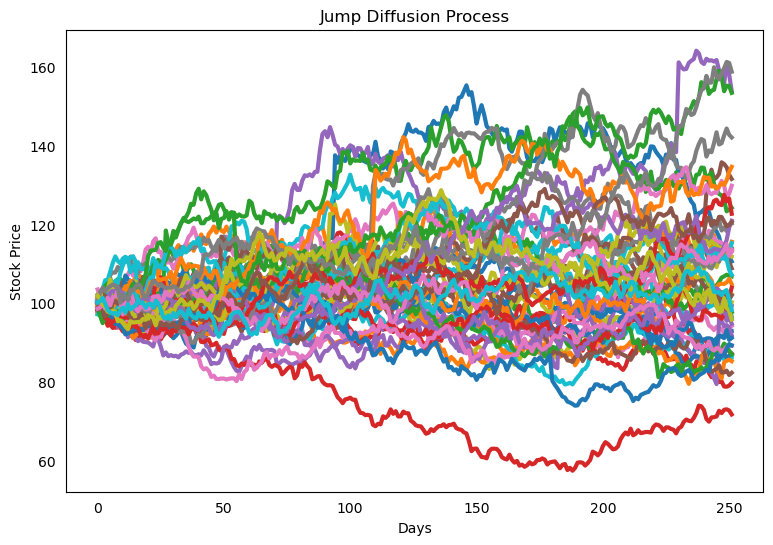

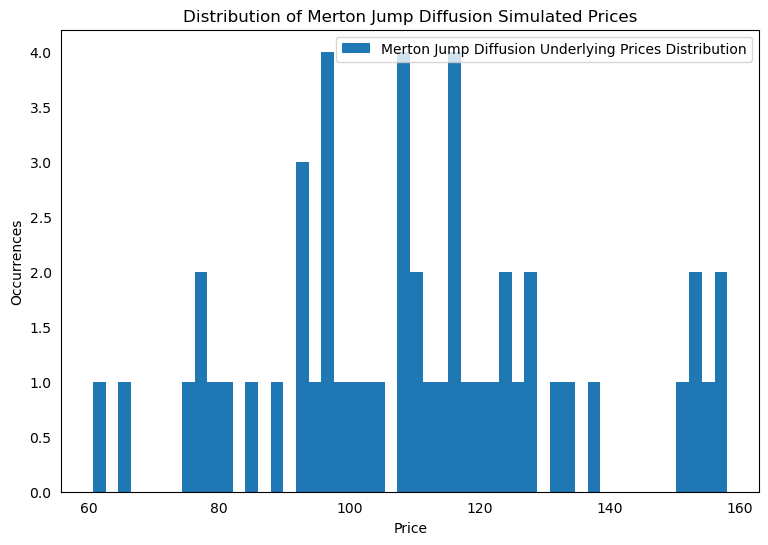

In [56]:
# Parameters for Merton Jump Diffusion Model
T = 1.0  # Maturity in years
mean_jumps = 0.02  # Mean of jump size
std_jumps = 0.1  # Standard deviation of jump size
lambd = 0.5  # Intensity of jumps (average number of jumps per year)
risk_f = 0.05  # Risk-free rate
vol = 0.2  # Volatility
timesteps = 252  # Number of time steps
Npaths = 50  # Number of paths to simulate
spot = 100  # Initial stock price
strike = 100  # Option strike price
r = 0.05  # Interest rate
option_type = "Call"  # Option type (call/put)
hedging_type = "delta"  # Hedging strategy (delta/gamma)
implied_vol = 0.2  # Implied volatility

# Create an instance of Merton_Jump
merton_jump = Merton_Jump(T, mean_jumps, std_jumps, lambd, vol, timesteps, Npaths, spot, strike, r, option_type, hedging_type, implied_vol)


# Plot paths generated by the Merton Jump Diffusion model
merton_jump.plot_merton_paths()

# Plot distribution of final prices from Merton Jump Diffusion model
merton_jump.plot_dist_merton_paths()


## References:

- Bruno Dupire (1994). "Pricing with a Smile".
- Derman, E., Iraj Kani (1994). ""Riding on a Smile."
- Itô, Kiyoshi (1951). "On a formula concerning stochastic differentials"
- Kiyosi Itô (1944). Stochastic Integral
- Kloeden, P.E. & Platen, E. (1992). Numerical Solution of Stochastic Differential Equations
- Mil'shtein, G. N. (1974). "Approximate integration of stochastic differential equations"
- Botev, Z.; Ridder, A. (2017). "Variance Reduction"
- Introduction to Merton Jump Diffusion Model, Kazuhisa Matsuda
- Ross, S.M. (1995) Stochastic Processes.
- Black, Fischer; Scholes, Myron (1973). "The Pricing of Options and Corporate Liabilities". Journal of Political Economy.
- Optimal Delta Hedging for Options, John Hull and Alan White, 2017
- Mandelbrot & Hudson, "The (Mis)Behavior of Markets" Basic Books, 2006